<a href="https://colab.research.google.com/github/khannaprachi/Artificial_Intelligence_Projects/blob/main/Capstone_FlightPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install keras-tuner
!pip install datasets
!pip install prophet
!pip install pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.1 MB/s eta 0:00:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from transformers import TimeSeriesTransformerModel,  TimeSeriesTransformerConfig
from datasets import Dataset, DatasetDict

import tensorflow as tf

import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from prophet import Prophet

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math

from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

from prettytable import PrettyTable

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
air_landings_df = pd.read_csv('/content/drive/MyDrive/MSAAI - 590 Capstone/Team 1/Code/Se\'Lina/data/air-traffic-landings-statistics.csv')
air_landings_df.head(5)

Activity Period                        Operating Airline  \
0           200204                             ATA Airlines   
1           200204                             ATA Airlines   
2           200204                             ATA Airlines   
3           200204  Aeroflot Russian International Airlines   
4           200204                               Air Canada   

  Operating Airline IATA Code                        Published Airline  \
0                          TZ                             ATA Airlines   
1                          TZ                             ATA Airlines   
2                          TZ                             ATA Airlines   
3                         NaN  Aeroflot Russian International Airlines   
4                          AC                               Air Canada   

  Published Airline IATA Code    GEO Summary GEO Region Landing Aircraft Type  \
0                          TZ       Domestic         US             Passenger   
1                          TZ       Domestic         US             Passenger   
2                          TZ       Domestic         US             Passenger   
3                         NaN  International     Europe             Passenger   
4                          AC  International     Canada             Passenger   

  Aircraft Body Type Aircraft Manufacturer Aircraft Model Aircraft Version  \
0        Narrow Body                Boeing            757              200   
1        Narrow Body                Boeing            757              300   
2          Wide Body              Lockheed          L1011                0   
3          Wide Body                Boeing            777                0   
4        Narrow Body                Boeing            737              200   

   Landing Count  Total Landed Weight  
0             83             16434000  
1              3               672000  
2             27              9666000  
3              9              4139946  
4              5               525000

In [ ]:
air_passenger_df = pd.read_csv('/content/drive/MyDrive/MSAAI - 590 Capstone/Team 1/Code/Se\'Lina/data/air-traffic-passenger-statistics.csv')
air_passenger_df.head(5)

Activity Period Operating Airline Operating Airline IATA Code  \
0           200507      ATA Airlines                          TZ   
1           200507      ATA Airlines                          TZ   
2           200507      ATA Airlines                          TZ   
3           200507        Air Canada                          AC   
4           200507        Air Canada                          AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3        Air Canada                          AC  International     Canada   
4        Air Canada                          AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Deplaned            Low Fare  Terminal 1             B   
1           Enplaned            Low Fare  Terminal 1             B   
2     Thru / Transit            Low Fare  Terminal 1             B   
3           Deplaned               Other  Terminal 1             B   
4           Enplaned               Other  Terminal 1             B   

   Passenger Count  
0            27271  
1            29131  
2             5415  
3            35156  
4            34090

# EDA

In [ ]:
def convert_datetime(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y%m')
    return df

In [ ]:
air_passenger_df = convert_datetime(air_passenger_df, 'Activity Period')

# Extract year from 'Activity Period'
air_passenger_df['Year'] = air_passenger_df['Activity Period'].dt.year
air_passenger_df['Month'] = air_passenger_df['Activity Period'].dt.month
air_passenger_df.head(5)

Activity Period Operating Airline Operating Airline IATA Code  \
0      2005-07-01      ATA Airlines                          TZ   
1      2005-07-01      ATA Airlines                          TZ   
2      2005-07-01      ATA Airlines                          TZ   
3      2005-07-01        Air Canada                          AC   
4      2005-07-01        Air Canada                          AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3        Air Canada                          AC  International     Canada   
4        Air Canada                          AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Deplaned            Low Fare  Terminal 1             B   
1           Enplaned            Low Fare  Terminal 1             B   
2     Thru / Transit            Low Fare  Terminal 1             B   
3           Deplaned               Other  Terminal 1             B   
4           Enplaned               Other  Terminal 1             B   

   Passenger Count  Year  Month  
0            27271  2005      7  
1            29131  2005      7  
2             5415  2005      7  
3            35156  2005      7  
4            34090  2005      7

In [ ]:
air_passenger_df.shape

(18885, 14)

In [ ]:
air_passenger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18885 entries, 0 to 18884
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Activity Period              18885 non-null  datetime64[ns]
 1   Operating Airline            18885 non-null  object        
 2   Operating Airline IATA Code  18822 non-null  object        
 3   Published Airline            18885 non-null  object        
 4   Published Airline IATA Code  18822 non-null  object        
 5   GEO Summary                  18885 non-null  object        
 6   GEO Region                   18885 non-null  object        
 7   Activity Type Code           18885 non-null  object        
 8   Price Category Code          18885 non-null  object        
 9   Terminal                     18885 non-null  object        
 10  Boarding Area                18885 non-null  object        
 11  Passenger Count              18885 non-nu

## Check for Nulls

In [ ]:
air_passenger_df.isnull().sum()

Activity Period                 0
Operating Airline               0
Operating Airline IATA Code    63
Published Airline               0
Published Airline IATA Code    63
GEO Summary                     0
GEO Region                      0
Activity Type Code              0
Price Category Code             0
Terminal                        0
Boarding Area                   0
Passenger Count                 0
Year                            0
Month                           0
dtype: int64

In [ ]:
# Get the Null Rows
air_passenger_df[air_passenger_df.isnull().any(axis=1)]['Operating Airline'].unique()

array(['Boeing Company', 'Servisair', 'Pacific Aviation', 'Swissport USA',
       'Trego Dugan Aviation'], dtype=object)

## Fill Missing Values
The entries that have missing IATA codes because they represent companies that provide aviation-related services but do not operate as airlines. These entities, such as Swissport USA, Pacific Aviation, Trego Dugan Aviation, Servisair, and Boeing Company, offer services like ground handling, cargo handling, and manufacturing, rather than transporting passengers or cargo via scheduled flights. Hence, they do not have IATA codes, which are specifically assigned to airlines for identification purposes.

N/A (Not Applicible will Replace the Nulls)



In [ ]:
#Take mode for the missing values
air_passenger_df['Operating Airline IATA Code'].fillna("N/A", inplace=True)
air_passenger_df['Published Airline IATA Code'].fillna("N/A", inplace=True)

In [ ]:
air_passenger_df.isnull().sum()

Activity Period                0
Operating Airline              0
Operating Airline IATA Code    0
Published Airline              0
Published Airline IATA Code    0
GEO Summary                    0
GEO Region                     0
Activity Type Code             0
Price Category Code            0
Terminal                       0
Boarding Area                  0
Passenger Count                0
Year                           0
Month                          0
dtype: int64

## Analyze Duplicate Values

In [ ]:
air_passenger_df.duplicated().sum()

0

In [ ]:
air_passenger_df['Operating Airline'].unique()

array(['ATA Airlines', 'Air Canada', 'Air China', 'Air France',
       'Air New Zealand', 'AirTran Airways', 'Alaska Airlines',
       'All Nippon Airways', 'American Airlines',
       'American Eagle Airlines', 'Asiana Airlines',
       'Atlantic Southeast Airlines', 'BelAir Airlines',
       'British Airways', 'Cathay Pacific', 'China Airlines',
       'Delta Air Lines', 'EVA Airways', 'Frontier Airlines',
       'Hawaiian Airlines', 'Horizon Air', 'Icelandair',
       'Independence Air', 'Japan Airlines', 'KLM Royal Dutch Airlines',
       'Korean Air Lines', 'Lufthansa German Airlines', 'Mesa Airlines',
       'Mexicana Airlines', 'Midwest Airlines', 'Northwest Airlines',
       'Philippine Airlines', 'Singapore Airlines', 'SkyWest Airlines',
       'Sun Country Airlines', 'TACA', 'US Airways', 'United Airlines',
       'United Airlines - Pre 07/01/2013', 'Virgin Atlantic',
       'WestJet Airlines', 'Boeing Company', 'Miami Air International',
       'Air Canada Jazz', 'Qantas Air

## Passenger Analysis by Time Variables

In [ ]:
air_passenger_peryear=air_passenger_df.groupby(['Year'])['Passenger Count'].sum().reset_index()
air_passenger_peryear.tail()

Year  Passenger Count
9   2014         47114631
10  2015         50057887
11  2016         53103448
12  2017         55823712
13  2018         27912505

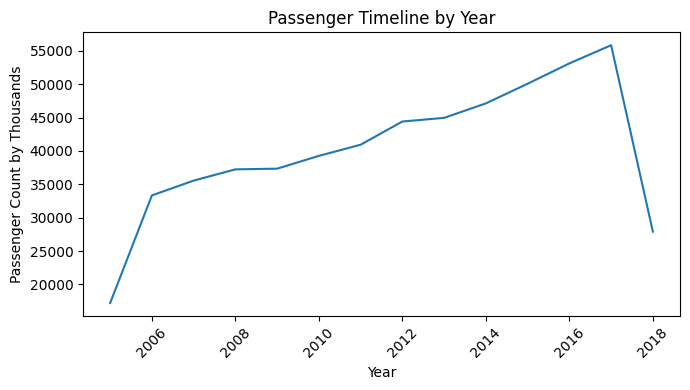

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(air_passenger_peryear['Year'], air_passenger_peryear['Passenger Count']/1000)
plt.title(f'Passenger Timeline by Year')
plt.xlabel('Year')
plt.ylabel('Passenger Count by Thousands')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When analyzing the passenger count trend at San Francisco International Airport (SFO) from 2005 to 2018, the data reveals several key insights:

1. Upward Trend: The number of passengers traveling to and from SFO has shown a consistent upward trend over the years, indicating a growth in air travel demand and SFO's increasing role as a major transportation hub.

2. Peak Year: The peak year for passenger traffic was 2017, with a total of 55,823,712 passengers, marking the highest annual passenger count during this period.

3. Incomplete Data for 2018: The data for 2018 is not for a full year, as it ends in June. This incomplete dataset means that any analysis for 2018 would not provide a full picture and could be misleading if directly compared with complete annual data from other years.



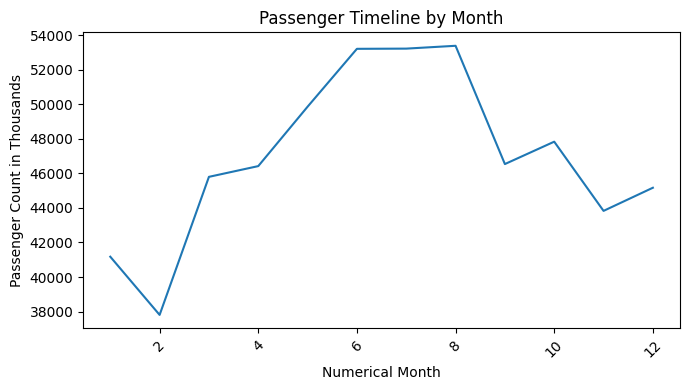

In [ ]:
air_passenger_bymonth=air_passenger_df.groupby(['Month'])['Passenger Count'].sum().reset_index()
plt.figure(figsize=(7, 4))
plt.plot(air_passenger_bymonth['Month'], air_passenger_bymonth['Passenger Count']/1000)
plt.title(f'Passenger Timeline by Month')
plt.xlabel('Numerical Month')
plt.ylabel('Passenger Count in Thousands')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When analyzing the passenger count by month, it has been observed that the maximum travel occurs from June through August. This period aligns with the summer months, which is a peak travel time due to several reasons:

1. Summer Vacations: Many people take advantage of the warmer weather and school holidays to travel for leisure, resulting in a significant increase in passenger traffic.

2. Tourist Season: San Francisco and its surrounding areas are popular tourist destinations. The summer months attract a large number of visitors, further boosting the passenger counts.

3. Family Travel: Families often plan trips during the summer when children are out of school, leading to an uptick in travel activity.



In [ ]:
# Store Summed Passenger Count by Year and Month into DF
air_passenger_byyearmonth=air_passenger_df.groupby(['Year', 'Month'])['Passenger Count'].sum().reset_index()
air_passenger_byyearmonth.head()

Year  Month  Passenger Count
0  2005      7          3225769
1  2005      8          3195866
2  2005      9          2740553
3  2005     10          2770715
4  2005     11          2617333

In [ ]:
# Creating a pivot table (crosstab)
pivot_table_yearmonth = air_passenger_byyearmonth.pivot_table(values='Passenger Count', index='Year', columns='Month', aggfunc='sum')
pivot_table_yearmonth.head()

Month         1          2          3          4          5          6   \
Year                                                                      
2005         NaN        NaN        NaN        NaN        NaN        NaN   
2006   2448889.0  2223024.0  2708778.0  2773293.0  2829000.0  3071396.0   
2007   2507430.0  2304990.0  2820085.0  2869247.0  3056934.0  3263621.0   
2008   2670053.0  2595676.0  3127387.0  3029021.0  3305954.0  3453751.0   
2009   2644539.0  2359800.0  2925918.0  3024973.0  3177100.0  3419595.0   

Month         7          8          9          10         11         12  
Year                                                                     
2005   3225769.0  3195866.0  2740553.0  2770715.0  2617333.0  2671797.0  
2006   3227605.0  3143839.0  2720100.0  2834959.0  2653887.0  2698200.0  
2007   3382382.0  3436417.0  2957530.0  3129309.0  2922500.0  2903637.0  
2008   3603946.0  3612297.0  3004720.0  3124451.0  2744485.0  2962937.0  
2009   3649702.0  3650668.0  3191526.0  3249428.0  2971484.0  3074209.0

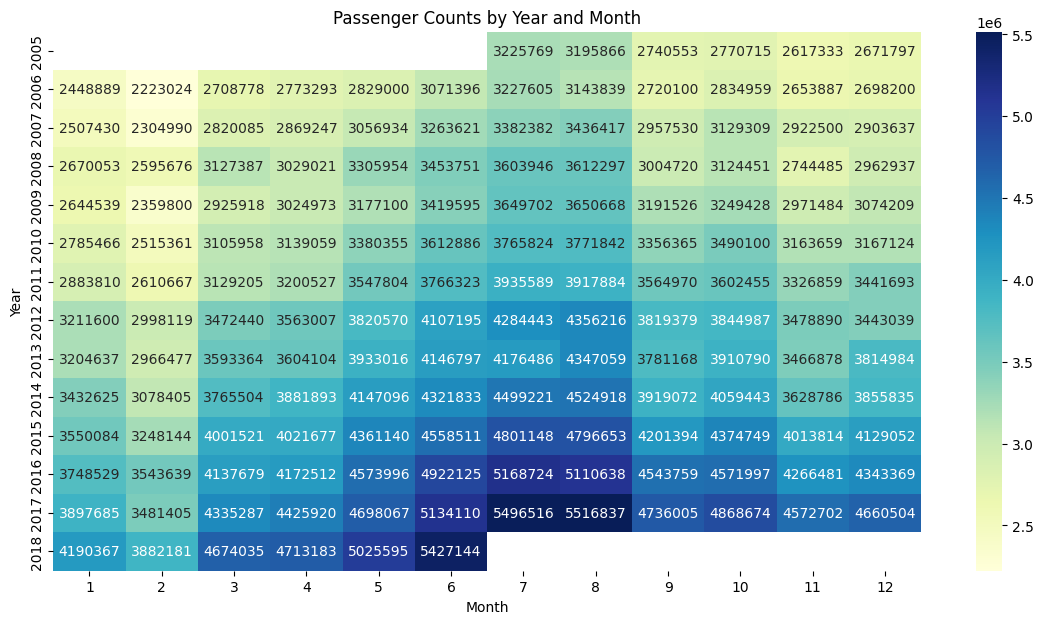

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(pivot_table_yearmonth, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Passenger Counts by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

The analysis of the passenger counts reveals that the darkest blue boxes in the heatmap correspond to July and August of 2017, as well as June of 2018. This observation aligns with the hypothesis that summer months experience peak travel. Additionally, the increasing intensity of the blue color over the years indicates a rise in the number of passengers traveling, supporting the trend that more passengers are flying as time progresses.

In [ ]:
# Create DF With DateTime and Passenger Count
# Group By Activity Period and Sum for Passenger Count
passenger_count_df = air_passenger_df.groupby('Activity Period')['Passenger Count'].sum().reset_index()
passenger_count_df['Activity Period'] = pd.to_datetime(passenger_count_df['Activity Period'], format='%Y%m')
passenger_count_df.set_index('Activity Period', inplace=True)
passenger_count_df.head()

Passenger Count
Activity Period                 
2005-07-01               3225769
2005-08-01               3195866
2005-09-01               2740553
2005-10-01               2770715
2005-11-01               2617333

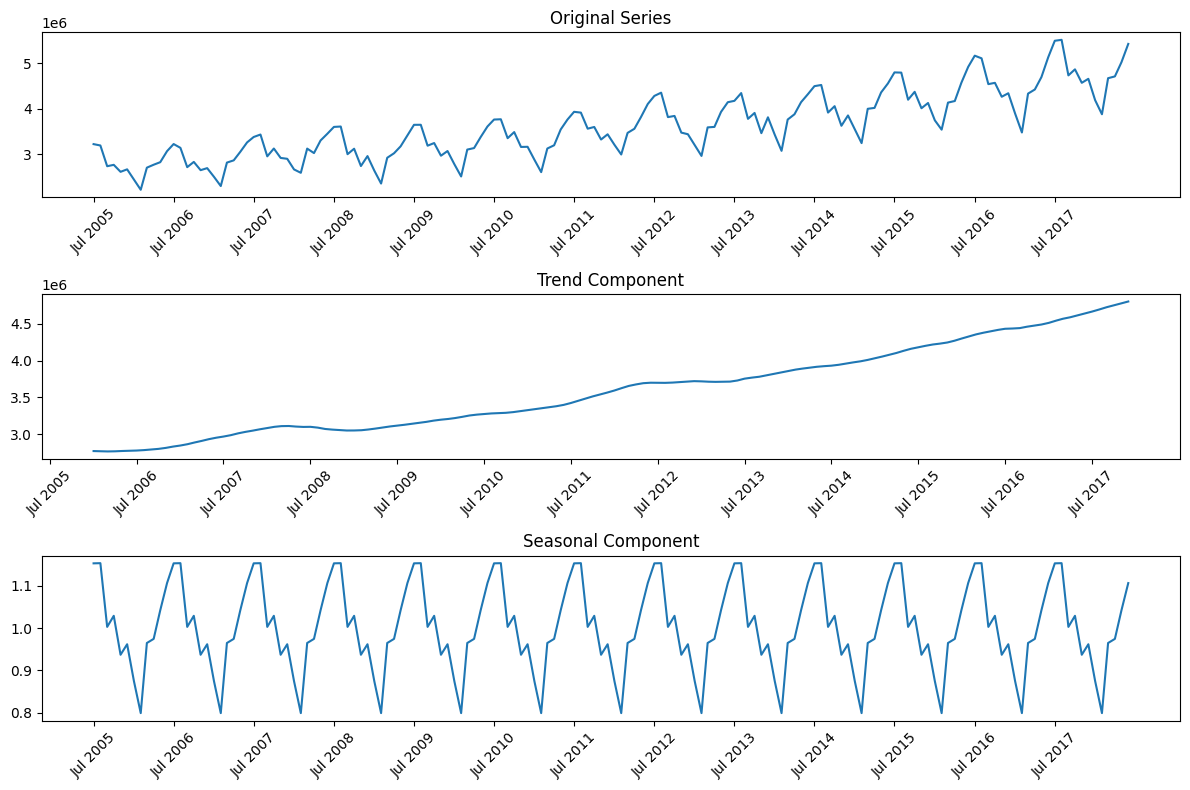

In [ ]:
# Seasonal decomposition
result = seasonal_decompose(passenger_count_df['Passenger Count'], model='multiplicative')

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(passenger_count_df.index, passenger_count_df['Passenger Count'])
plt.title('Original Series')
plt.xticks(ticks=passenger_count_df.index[::12], labels=[date.strftime('%b %Y') for date in passenger_count_df.index[::12]], rotation=45)


plt.subplot(3, 1, 2)
plt.plot(result.trend)
plt.title('Trend Component')
plt.xticks(ticks=passenger_count_df.index[::12], labels=[date.strftime('%b %Y') for date in passenger_count_df.index[::12]], rotation=45)

plt.subplot(3, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal Component')
plt.xticks(ticks=passenger_count_df.index[::12], labels=[date.strftime('%b %Y') for date in passenger_count_df.index[::12]], rotation=45)

plt.tight_layout()
plt.show()

The 'Trend' Component Shows that the Passenger Count is Increasing Overtime. Whereas the 'Seasonal' Component Shows that Passenger Count Peaks Around July in the Summer Months

## Analyze Passenger Count by Airline

In [ ]:
air_passenger_airlinebyyear=air_passenger_df.groupby(['Year','Operating Airline'])['Passenger Count'].sum().divide(1000).reset_index()
pivot_table_airlinebyyear = pd.pivot_table(air_passenger_airlinebyyear, values='Passenger Count', index='Operating Airline', columns='Year',fill_value=0)
pivot_table_airlinebyyear.loc["United Airlines",:] = pivot_table_airlinebyyear.loc["United Airlines",:] + pivot_table_airlinebyyear.loc["United Airlines - Pre 07/01/2013",:]
pivot_table_airlinebyyear.drop("United Airlines - Pre 07/01/2013",axis=0, inplace=True)
pivot_table_airlinebyyear.head(5)

Year                                        2005     2006    2007     2008  \
Operating Airline                                                            
ABC Aerolineas S.A. de C.V. dba Interjet    0.00    0.000   0.000    0.000   
ATA Airlines                              277.54  105.796   1.362    0.066   
Aer Lingus                                  0.00    0.000  14.709  104.897   
Aeromexico                                  0.00    0.000   0.524    0.000   
Air Berlin                                  0.00    0.000   0.000    0.000   

Year                                        2009    2010    2011    2012  \
Operating Airline                                                          
ABC Aerolineas S.A. de C.V. dba Interjet   0.000   0.000   0.000   0.000   
ATA Airlines                               0.000   0.000   0.000   0.000   
Aer Lingus                                65.033   0.000   0.000   0.000   
Aeromexico                                60.533  77.648  80.171  74.552   
Air Berlin                                 0.000  24.119  29.205  30.223   

Year                                         2013     2014     2015     2016  \
Operating Airline                                                              
ABC Aerolineas S.A. de C.V. dba Interjet    0.000    0.000    0.000    0.000   
ATA Airlines                                0.000    0.000    0.000    0.000   
Aer Lingus                                  0.000   86.838  134.582  142.382   
Aeromexico                                118.783  243.923  263.919  277.196   
Air Berlin                                  0.000    0.000    0.000   52.484   

Year                                         2017     2018  
Operating Airline                                           
ABC Aerolineas S.A. de C.V. dba Interjet    0.000   15.585  
ATA Airlines                                0.000    0.000  
Aer Lingus                                153.383   75.867  
Aeromexico                                326.365  149.332  
Air Berlin                                 99.124    0.000

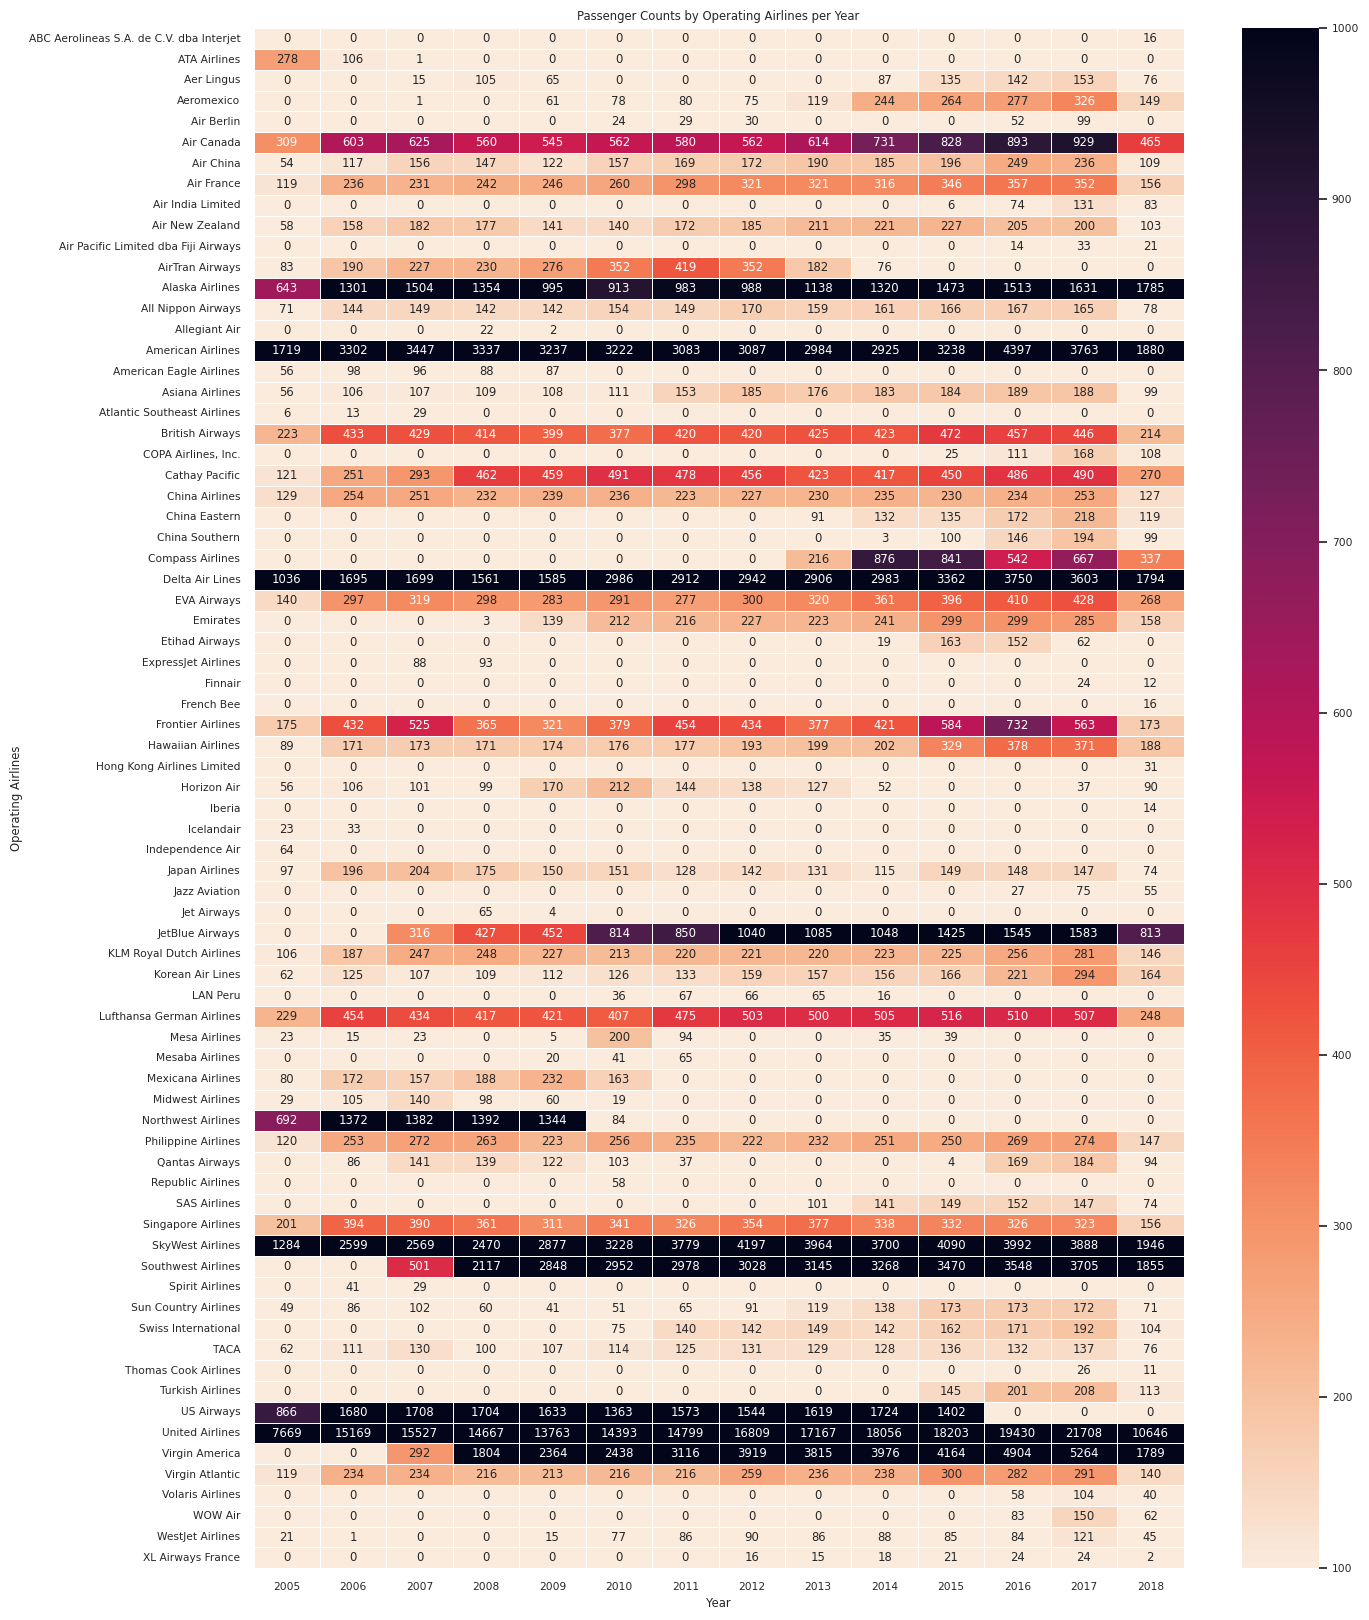

In [ ]:
#dropping the small airlines
smallest_airlines = pivot_table_airlinebyyear[pivot_table_airlinebyyear.sum(axis=1)<13]
pivot_table = pivot_table_airlinebyyear.drop(smallest_airlines.index, axis=0)
sns.set(font_scale=0.7)
plt.figure(figsize=(15, 20))
#sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap=sns.cm.rocket_r)
sns.heatmap(pivot_table, annot=True, linewidths=.5, vmin=100, vmax=1000, fmt='.0f', cmap=sns.cm.rocket_r)
plt.title('Passenger Counts by Operating Airlines per Year')
plt.xlabel('Year')
plt.ylabel('Operating Airlines')
plt.show()


The heatmap illustrates the distribution of passenger travel across various airlines, with darker shades indicating higher travel volumes. The top ten airlines are:

1. United Airlines
2. SkyWest Airlines
3. American Airlines
4. Virgin America
5. Delta Air Lines
6. Southwest Airlines
7. Alaska Airlines
8. US Airways
9. JetBlue Airways
10. Air Canada

In [ ]:
#Top 10 airlines
air_passenger_avg = pivot_table_airlinebyyear.mean(axis=1)
air_passenger_avgTop10 = air_passenger_avg.nlargest(10).to_frame().mul(1000).astype("int64")
air_passenger_avgTop10.columns = ["Mean no. of passengers per year"]
sum_of_all = air_passenger_avgTop10.loc[:,"Mean no. of passengers per year"].sum()
air_passenger_avgTop10.loc[:,"Share [%]"] = air_passenger_avgTop10.loc[:,"Mean no. of passengers per year"].div(sum_of_all).mul(100).round(1)
air_passenger_avgTop10

Mean no. of passengers per year  Share [%]
Operating Airline                                             
United Airlines                            15571737       46.7
SkyWest Airlines                            3184454        9.5
American Airlines                           3115884        9.3
Virgin America                              2703137        8.1
Delta Air Lines                             2486702        7.5
Southwest Airlines                          2386783        7.2
Alaska Airlines                             1252873        3.8
US Airways                                  1201186        3.6
JetBlue Airways                              814195        2.4
Air Canada                                   628920        1.9

Top 10 airlines by passenger shows **United Airline** with Highest number of Passenger with average Passenger per year is 15,571,737 and it's share is **46.7%** of overall travel

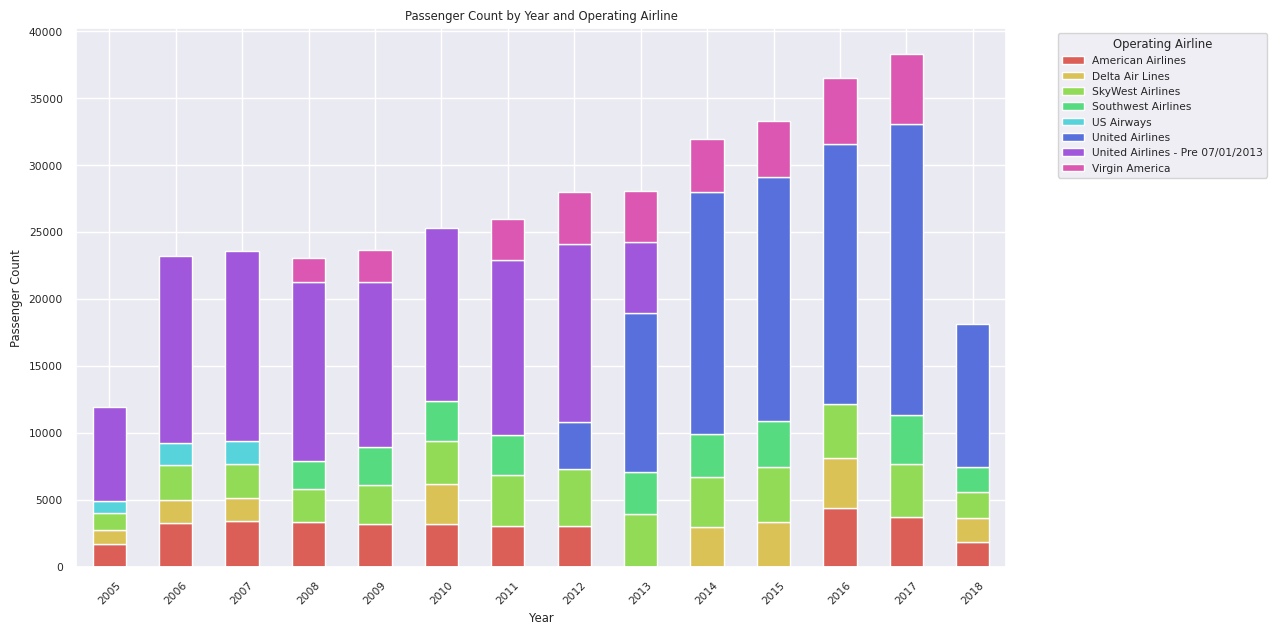

In [ ]:
def get_top_5_airlines(year_df):
    return year_df.sort_values(by='Passenger Count', ascending=False).head(5)

# Apply the function to each year group
top_5_each_year = air_passenger_airlinebyyear.groupby('Year').apply(get_top_5_airlines).reset_index(drop=True)
top_5_each_year.head(5)


# Creating a pivot table for easier plotting
pivot_df = top_5_each_year.pivot(index='Year', columns='Operating Airline', values='Passenger Count')

# Generate a color map with a sufficient number of distinct colors
colors = list(mcolors.CSS4_COLORS.keys())
color_map = colors[:len(pivot_df.columns)]
bright_colors = sns.color_palette("hls", len(pivot_df.columns))

# Plotting the bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 7), color=bright_colors)

plt.title('Passenger Count by Year and Operating Airline')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend(title='Operating Airline')
plt.xticks(rotation=45)
plt.legend(title='Operating Airline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This graph shows Top 5 Airlines for each year. We can see share of United Airlines increasing by year followed by Virgin America, Delta, America, Skywest and Southwest

In [ ]:
air_passenger_combined=air_passenger_df.groupby(['Activity Period','Operating Airline'])['Passenger Count'].sum().reset_index()
air_passenger_combined['Operating Airline'] = air_passenger_combined['Operating Airline'].replace('United Airlines - Pre 07/01/2013', 'United Airlines')
air_passenger_combined.head()

Activity Period Operating Airline  Passenger Count
0      2005-07-01      ATA Airlines            61817
1      2005-07-01        Air Canada            69246
2      2005-07-01         Air China            11763
3      2005-07-01        Air France            23688
4      2005-07-01   Air New Zealand             9960

In [ ]:
def plot_passenger_timeline(df, airline):
    """
    Plots the passenger timeline for a given airline.

    Args:
        df: The dataframe containing passenger data.
        airline: The name of the operating airline.
    """
    airline_data = df[df['Operating Airline'] == airline]
    plt.figure(figsize=(7, 4))
    plt.plot(airline_data['Activity Period'], airline_data['Passenger Count']/1000)
    plt.title(f'Passenger Timeline for {airline}')
    plt.xlabel('Year')
    plt.ylabel('Passenger Count by Thousands')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

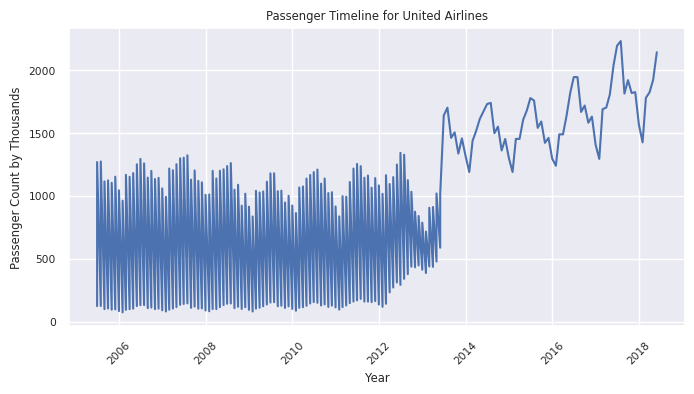

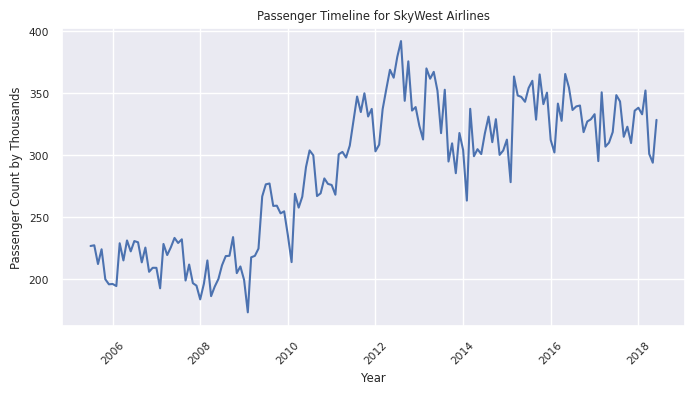

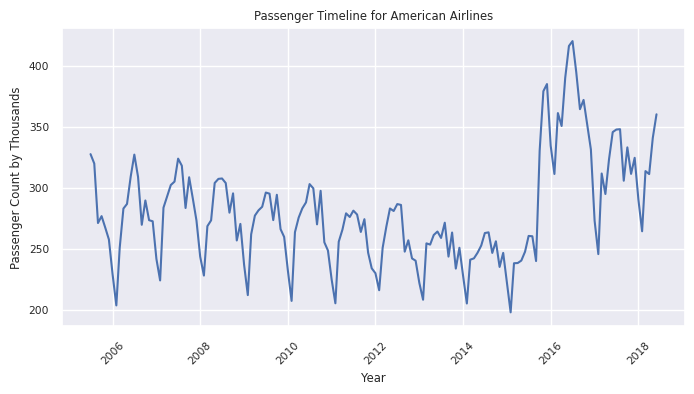

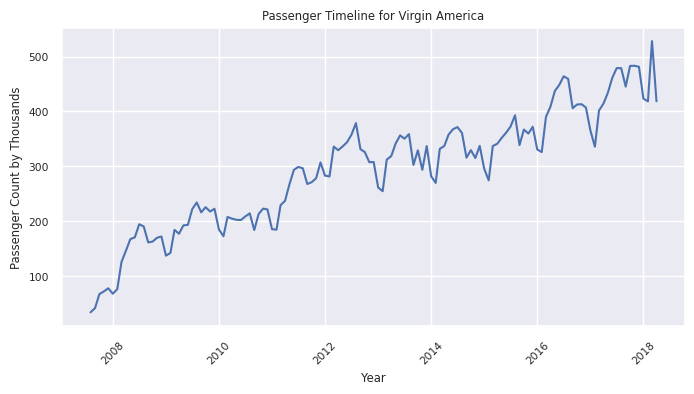

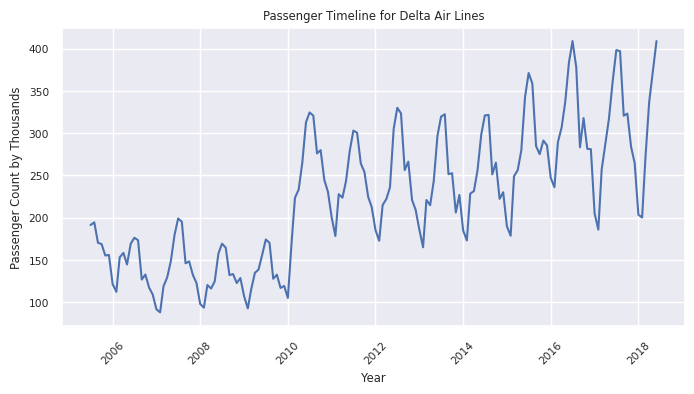

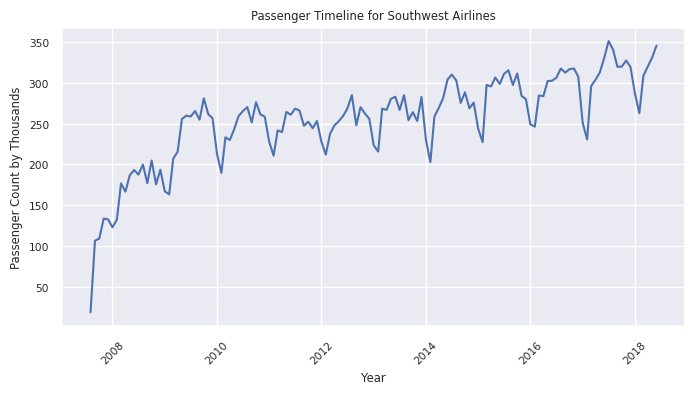

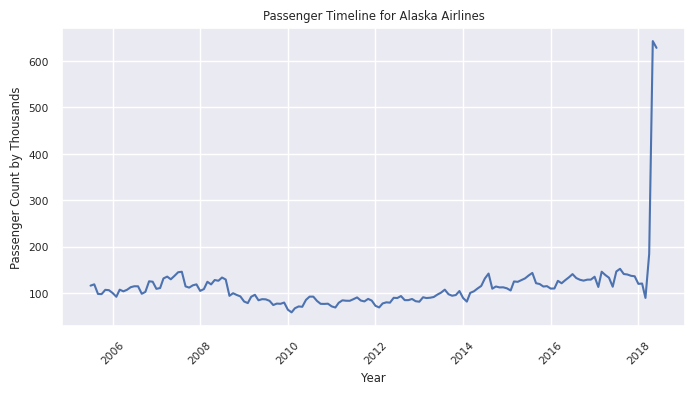

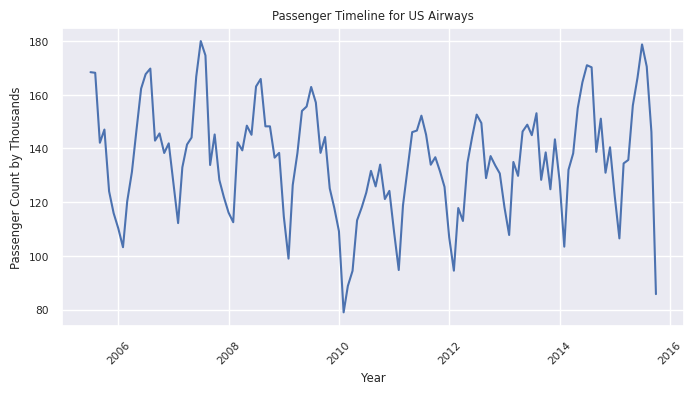

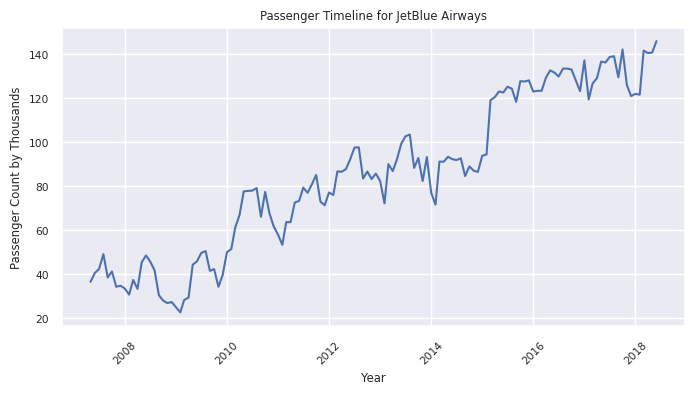

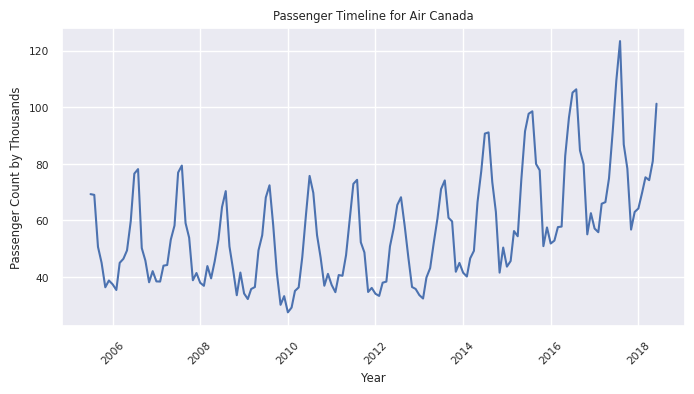

In [ ]:
# Plot Top Ten Airline
for airline in air_passenger_avgTop10.index:
    plot_passenger_timeline(air_passenger_combined, airline)

Airline Passenger Summary:
- United Airlines passenger count shows growth starting 2013 with steady increase
- Skywest Airlines reached maximum Passenger count between 2012-2014 after which we can see slight decrease
- American Airlines show steep increase in Passenger count between 2015-2016 with slight decrease in 2017
- Virgin America show steady increase in Passenger Count
- Delta Airlines shows steady Passenger count between 2010-2014 with increase in numbers starting 2015
- Southwest Airlines shows steady increase in Passenger count
- Alaska Airlines shows steep increase in 2018
- US Airways shows same Passenger Count from 2005 through 2018. No growth in count
- JetBlue Airlines shows steady increase in Passenger Count
Air Canada Passenger Count shows steady growth from 2014 through 2018

# Analyze Passenger Count by Airline Terminal

In [ ]:
air_passenger_airlinebyterminal=air_passenger_df.groupby(['Operating Airline', 'Terminal'])['Passenger Count'].sum().divide(1000).reset_index()
air_passenger_airlinebyterminal = pd.pivot_table(air_passenger_airlinebyterminal, values='Passenger Count', index='Operating Airline', columns='Terminal',fill_value=0)
air_passenger_airlinebyterminal.loc["United Airlines",:] = air_passenger_airlinebyterminal.loc["United Airlines",:] + air_passenger_airlinebyterminal.loc["United Airlines - Pre 07/01/2013",:]
air_passenger_airlinebyterminal.drop("United Airlines - Pre 07/01/2013",axis=0, inplace=True)
smallest_airlines = air_passenger_airlinebyterminal[pivot_table_airlinebyyear.sum(axis=1)<13]
pivot_table = air_passenger_airlinebyterminal.drop(smallest_airlines.index, axis=0)
pivot_table.head()

Terminal                                  International  Other  Terminal 1  \
Operating Airline                                                            
ABC Aerolineas S.A. de C.V. dba Interjet         15.585    0.0       0.000   
ATA Airlines                                      2.081    0.0     382.493   
Aer Lingus                                      777.691    0.0       0.000   
Aeromexico                                     1672.946    0.0       0.000   
Air Berlin                                      235.155    0.0       0.000   

Terminal                                  Terminal 2  Terminal 3  
Operating Airline                                                 
ABC Aerolineas S.A. de C.V. dba Interjet         0.0        0.00  
ATA Airlines                                     0.0        0.19  
Aer Lingus                                       0.0        0.00  
Aeromexico                                       0.0        0.00  
Air Berlin                                       0.0        0.00

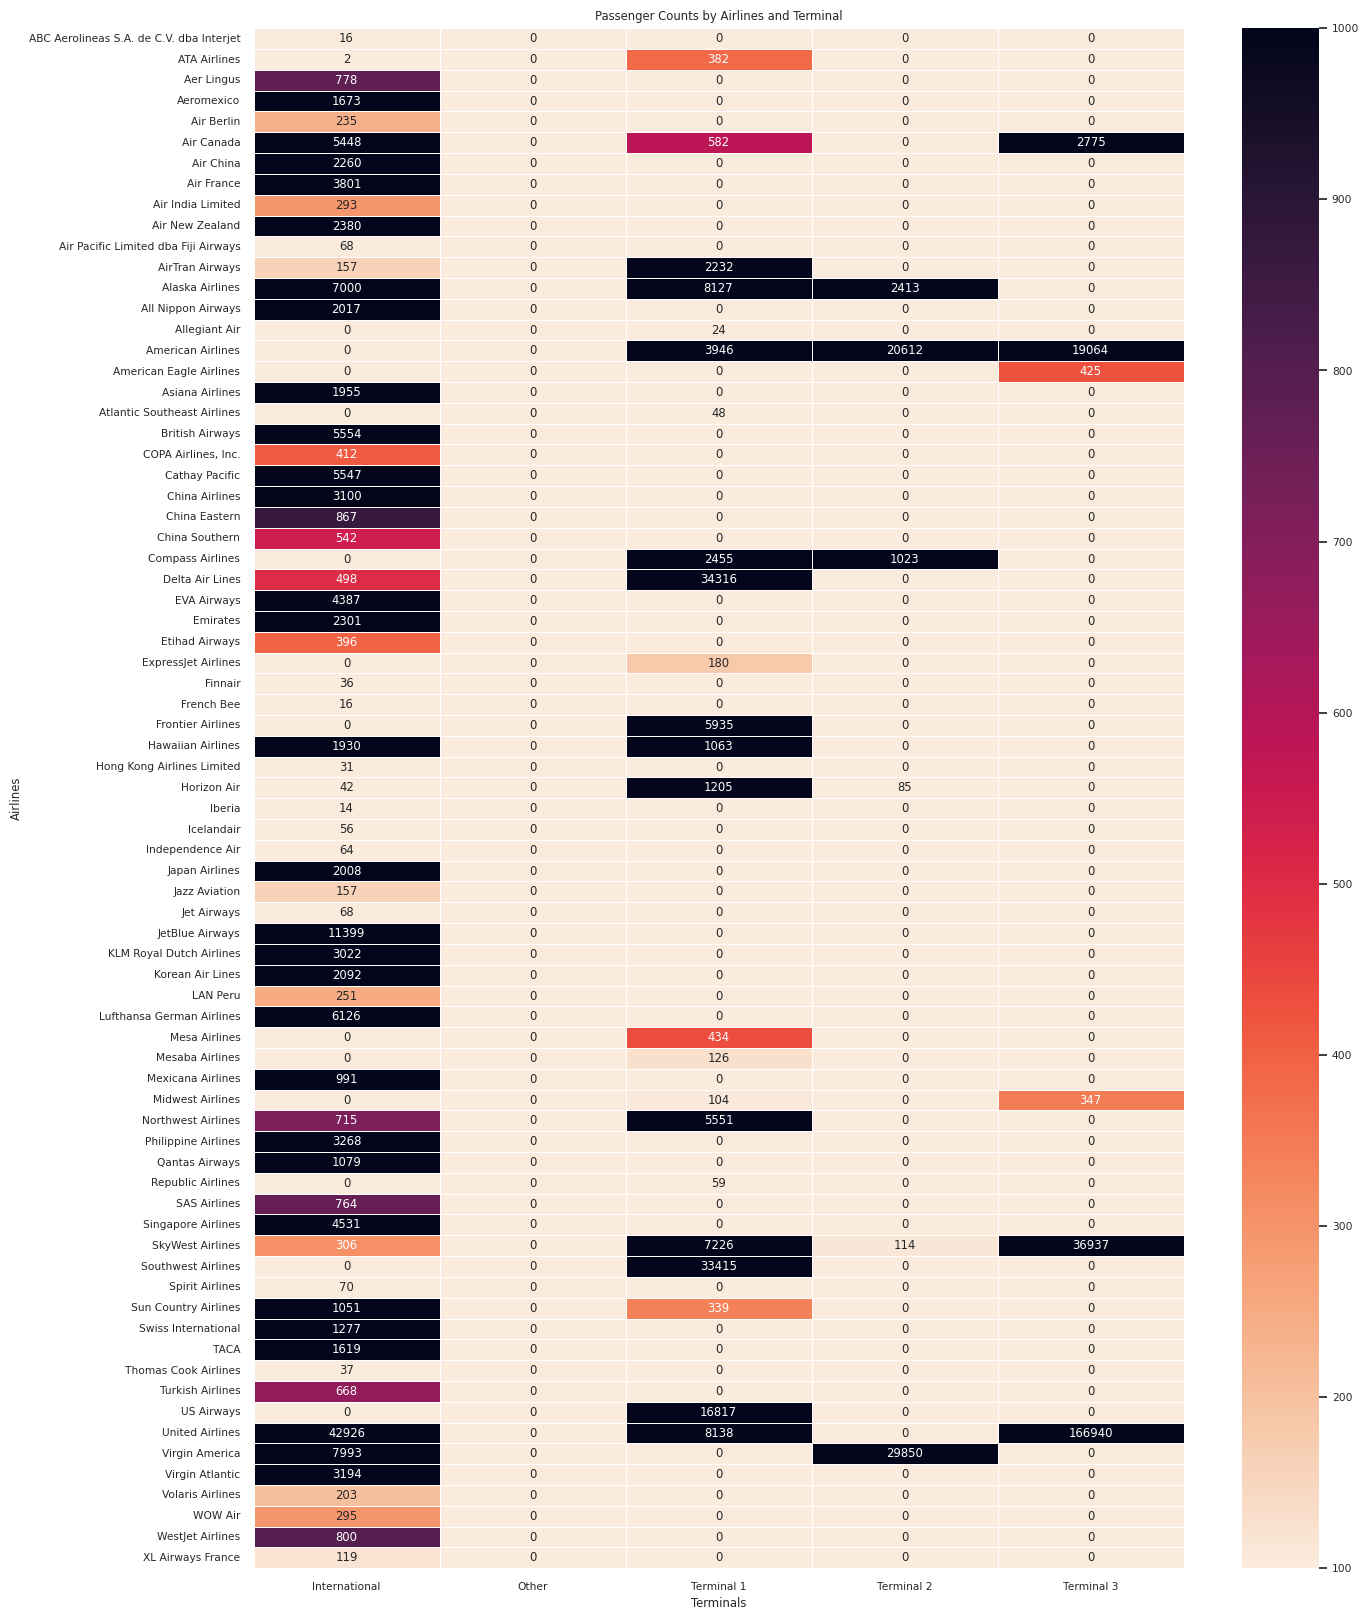

In [ ]:
sns.set(font_scale=0.7)
plt.figure(figsize=(15, 20))
#sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap=sns.cm.rocket_r)
sns.heatmap(pivot_table, annot=True, linewidths=.5, vmin=100, vmax=1000, fmt='.0f', cmap=sns.cm.rocket_r)
plt.title('Passenger Counts by Airlines and Terminal')
plt.xlabel('Terminals')
plt.ylabel('Airlines')
plt.show()

In [ ]:
#Busy airline terminals
air_passenger_airlinebyterminal_avg = air_passenger_airlinebyterminal.mean(axis=0)
air_passenger_airlinebyterminal_avgTop10 = air_passenger_airlinebyterminal_avg.nlargest(10).to_frame().mul(1000).astype("int64")
air_passenger_airlinebyterminal_avgTop10.columns = ["Mean no. of passengers per year"]
sum_of_all = air_passenger_airlinebyterminal_avgTop10.loc[:,"Mean no. of passengers per year"].sum()
air_passenger_airlinebyterminal_avgTop10.loc[:,"Share [%]"] = air_passenger_airlinebyterminal_avgTop10.loc[:,"Mean no. of passengers per year"].div(sum_of_all).mul(100).round(1)
air_passenger_airlinebyterminal_avgTop10

Mean no. of passengers per year  Share [%]
Terminal                                                 
Terminal 3                             2573755       40.1
International                          1715114       26.8
Terminal 1                             1508003       23.5
Terminal 2                              614742        9.6
Other                                        2        0.0

United Airlines is the largest airline in terms of passenger counts as shown in previous analysises. Terminal 3, which primarily serves United Airlines' domestic flights, is the busiest terminal at the airport, followed by the International Terminal.

## Passenger Count by GeoSummary

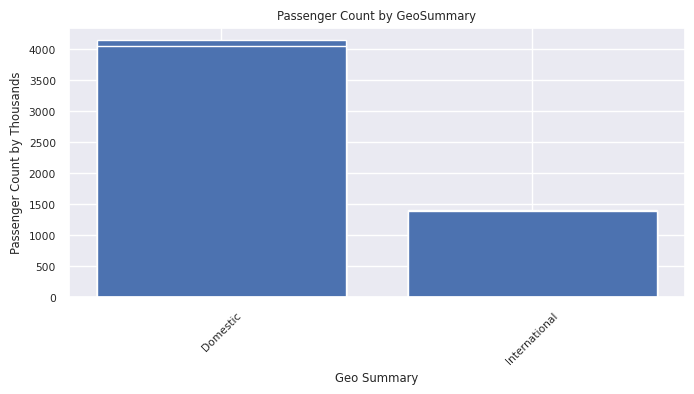

In [ ]:
air_passenger_byGeoSummary=air_passenger_df.groupby(['GEO Summary','Activity Period'])['Passenger Count'].sum().divide(1000).reset_index()
plt.figure(figsize=(7, 4))
plt.bar(air_passenger_byGeoSummary['GEO Summary'], air_passenger_byGeoSummary['Passenger Count'])
plt.title(f'Passenger Count by GeoSummary')
plt.xlabel('Geo Summary')
plt.ylabel('Passenger Count by Thousands')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
air_passenger_byGeoSummarytotal=air_passenger_byGeoSummary.groupby(['GEO Summary'])['Passenger Count'].sum().reset_index()

In [ ]:
air_passenger_byGeoSummarytotal

GEO Summary  Passenger Count
0       Domestic       433645.094
1  International       130577.224

SFO Airport has more Passengers travelling from Domestic flights than  International

In [ ]:
pivot_table_geosummarybyyear = pd.pivot_table(air_passenger_byGeoSummary, values='Passenger Count', index='GEO Summary', columns='Activity Period',fill_value=0)

In [ ]:
pivot_table_geosummarybyyear.head(5)

Activity Period  2005-07-01  2005-08-01  2005-09-01  2005-10-01  2005-11-01  \
GEO Summary                                                                   
Domestic           2425.902    2405.904    2067.923    2095.119    1998.879   
International       799.867     789.962     672.630     675.596     618.454   

Activity Period  2005-12-01  2006-01-01  2006-02-01  2006-03-01  2006-04-01  \
GEO Summary                                                                   
Domestic           2003.840    1777.970    1654.332    2021.211    2060.067   
International       667.957     670.919     568.692     687.567     713.226   

Activity Period  ...  2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
GEO Summary      ...                                                   
Domestic         ...    3579.260    3764.139    3593.895    3590.008   
International    ...    1156.745    1104.535     978.807    1070.496   

Activity Period  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  \
GEO Summary                                                                   
Domestic           3144.332    2963.364    3579.413    3630.813    3818.359   
International      1046.035     918.817    1094.622    1082.370    1207.236   

Activity Period  2018-06-01  
GEO Summary                  
Domestic           4039.838  
International      1387.306  

[2 rows x 156 columns]

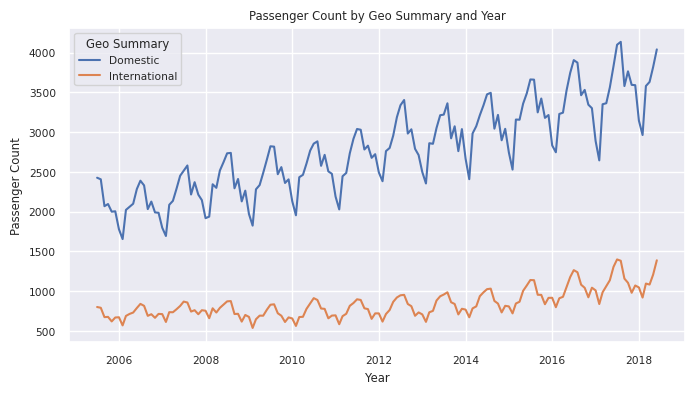

In [ ]:
plt.figure(figsize=(7, 4))
for geo_summary in pivot_table_geosummarybyyear.index:
    plt.plot(pivot_table_geosummarybyyear.columns, pivot_table_geosummarybyyear.loc[geo_summary], label=geo_summary)

plt.title('Passenger Count by Geo Summary and Year')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend(title='Geo Summary')
plt.tight_layout()
plt.show()

Both Domestic and International Flights are Seeing an Increase in Passenger Counts, However, Domestic is Growing at a Faster Rate

## Passenger Count by GEO Region

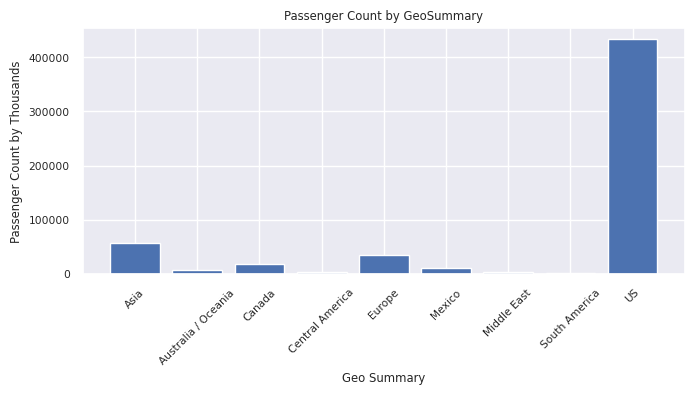

In [ ]:
air_passenger_byGeoRegion=air_passenger_df.groupby(['GEO Region'])['Passenger Count'].sum().divide(1000).reset_index()

plt.figure(figsize=(7, 4))
plt.bar(air_passenger_byGeoRegion['GEO Region'], air_passenger_byGeoRegion['Passenger Count'])
plt.title(f'Passenger Count by GeoSummary')
plt.xlabel('Geo Summary')
plt.ylabel('Passenger Count by Thousands')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature Engineering
## One Hot Encoding of Categorical Variables

In [ ]:
air_passenger_df.head()

Activity Period Operating Airline Operating Airline IATA Code  \
0      2005-07-01      ATA Airlines                          TZ   
1      2005-07-01      ATA Airlines                          TZ   
2      2005-07-01      ATA Airlines                          TZ   
3      2005-07-01        Air Canada                          AC   
4      2005-07-01        Air Canada                          AC   

  Published Airline Published Airline IATA Code    GEO Summary GEO Region  \
0      ATA Airlines                          TZ       Domestic         US   
1      ATA Airlines                          TZ       Domestic         US   
2      ATA Airlines                          TZ       Domestic         US   
3        Air Canada                          AC  International     Canada   
4        Air Canada                          AC  International     Canada   

  Activity Type Code Price Category Code    Terminal Boarding Area  \
0           Deplaned            Low Fare  Terminal 1             B   
1           Enplaned            Low Fare  Terminal 1             B   
2     Thru / Transit            Low Fare  Terminal 1             B   
3           Deplaned               Other  Terminal 1             B   
4           Enplaned               Other  Terminal 1             B   

   Passenger Count  Year  Month  
0            27271  2005      7  
1            29131  2005      7  
2             5415  2005      7  
3            35156  2005      7  
4            34090  2005      7

In [ ]:
air_passenger_df['UnixTime']=air_passenger_df['Activity Period'].astype(int) / 10**9
frequency_encoding = air_passenger_df.groupby(['Year', 'Operating Airline']).size().reset_index(name='Operating Airline Frequency')
# Merge frequency encoding back to the original DataFrame
air_passenger_byairlines_byperiod = air_passenger_df.merge(frequency_encoding, on=['Year', 'Operating Airline'], how='left')
# One-hot encode categorical columns
air_passenger_encoded_df = pd.get_dummies(air_passenger_byairlines_byperiod, columns=['GEO Summary', 'GEO Region', 'Price Category Code', 'Terminal', 'Boarding Area'])
air_passenger_encoded_df=air_passenger_encoded_df.drop(columns=['Operating Airline', 'Published Airline', 'Activity Type Code', 'Operating Airline IATA Code', 'Published Airline IATA Code'])
# Convert all columns to integers, excluding the 'Activity Period' column
columns_to_convert = [col for col in air_passenger_encoded_df.columns if col != 'Activity Period']
air_passenger_encoded_df[columns_to_convert] = air_passenger_encoded_df[columns_to_convert].astype(int)
air_passenger_encoded_df.head(5)

Activity Period  Passenger Count  Year  Month    UnixTime  \
0      2005-07-01            27271  2005      7  1120176000   
1      2005-07-01            29131  2005      7  1120176000   
2      2005-07-01             5415  2005      7  1120176000   
3      2005-07-01            35156  2005      7  1120176000   
4      2005-07-01            34090  2005      7  1120176000   

   Operating Airline Frequency  GEO Summary_Domestic  \
0                           20                     1   
1                           20                     1   
2                           20                     1   
3                           12                     0   
4                           12                     0   

   GEO Summary_International  GEO Region_Asia  GEO Region_Australia / Oceania  \
0                          0                0                               0   
1                          0                0                               0   
2                          0                0                               0   
3                          1                0                               0   
4                          1                0                               0   

   ...  Terminal_Terminal 2  Terminal_Terminal 3  Boarding Area_A  \
0  ...                    0                    0                0   
1  ...                    0                    0                0   
2  ...                    0                    0                0   
3  ...                    0                    0                0   
4  ...                    0                    0                0   

   Boarding Area_B  Boarding Area_C  Boarding Area_D  Boarding Area_E  \
0                1                0                0                0   
1                1                0                0                0   
2                1                0                0                0   
3                1                0                0                0   
4                1                0                0                0   

   Boarding Area_F  Boarding Area_G  Boarding Area_Other  
0                0                0                    0  
1                0                0                    0  
2                0                0                    0  
3                0                0                    0  
4                0                0                    0  

[5 rows x 32 columns]

In [ ]:
air_passenger_encoded_df.shape

(18885, 32)

## Plot Correlation between Passenger Count feature other Features from the Data

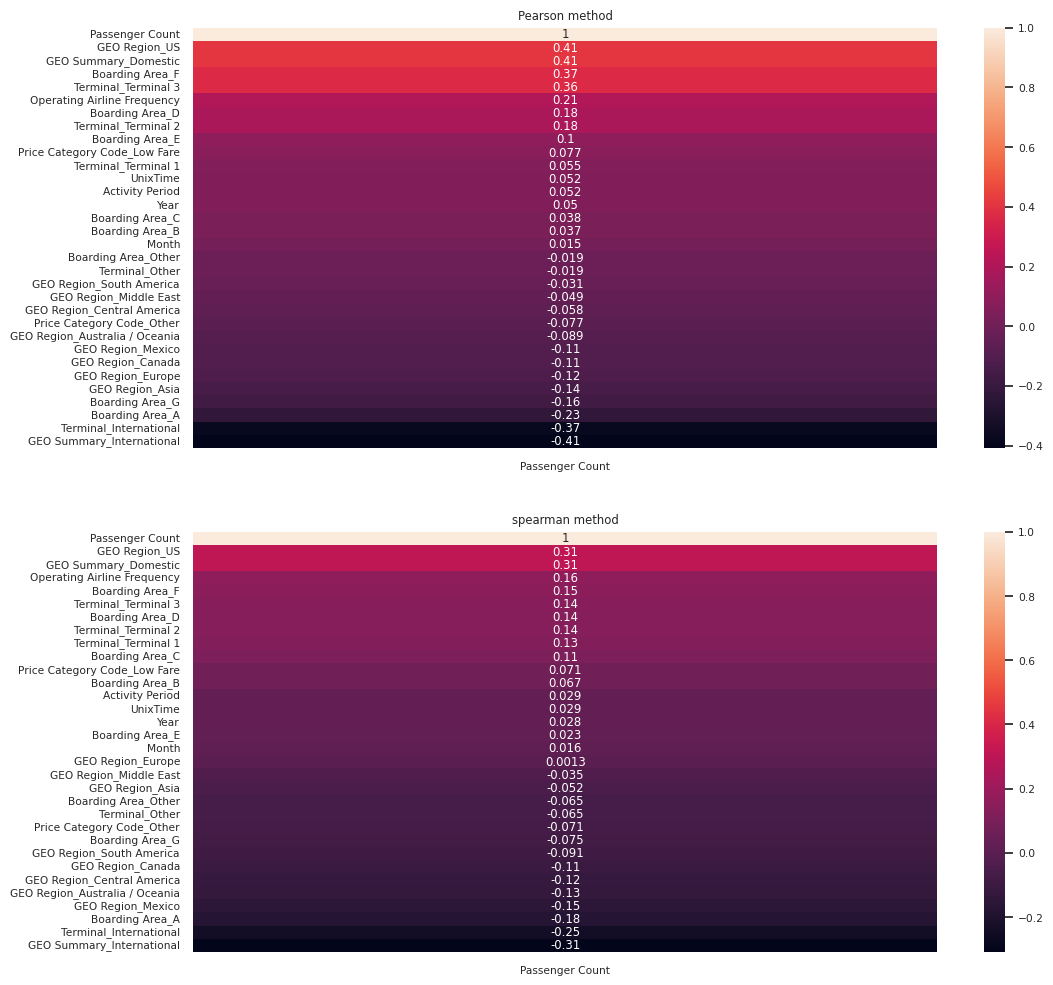

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute correlation matrix
fig, ax = plt.subplots(2,1, figsize=(12, 12))

corr1 = air_passenger_encoded_df.corr('pearson')[['Passenger Count']].sort_values(by='Passenger Count', ascending=False)
corr2 = air_passenger_encoded_df.corr('spearman')[['Passenger Count']].sort_values(by='Passenger Count', ascending=False)

#setting titles for each plot
ax[0].set_title('Pearson method')
ax[1].set_title('spearman method')
## Generating heatmaps of each methods
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)

plt.show()

## Check for Outliers

In [ ]:
numerical_columns=['GEO Summary','GEO Region','Price Category Code','Terminal','Boarding Area']

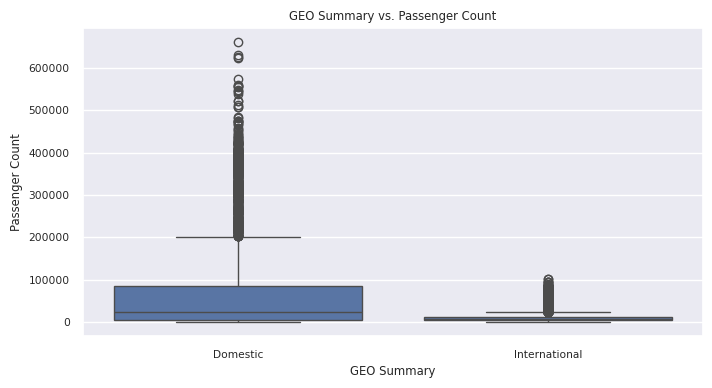

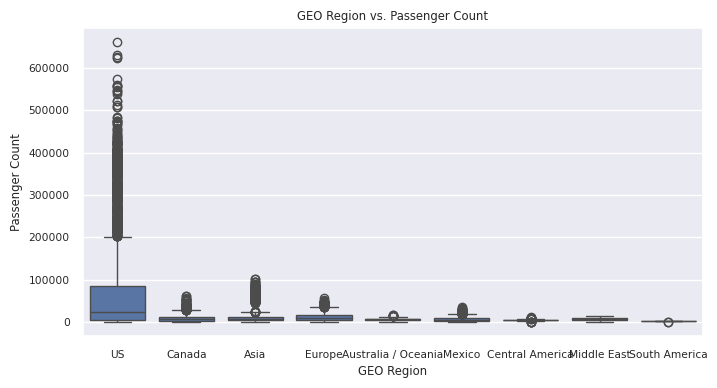

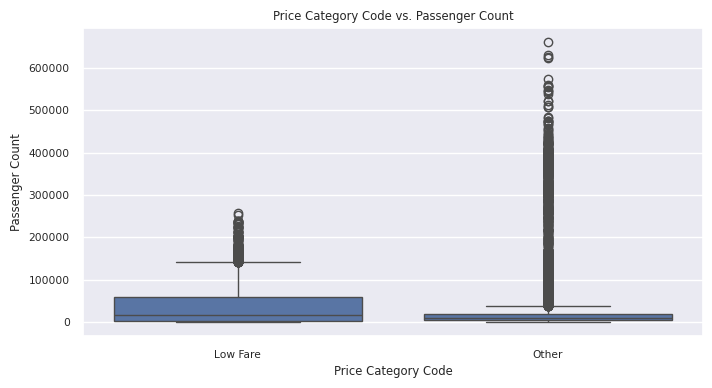

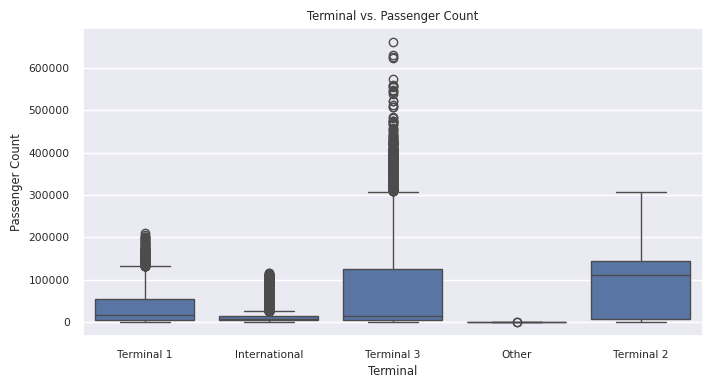

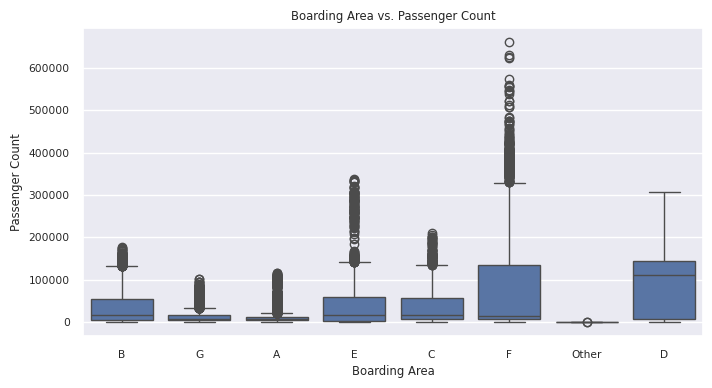

In [ ]:
# Box plot for numerical features vs. Passenger Count
for feature in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=feature, y='Passenger Count', data=air_passenger_df)
    plt.title(f'{feature} vs. Passenger Count')
    plt.show()

# Linear Regression Model

## Predicting Passenger Count by Independent Feature Activity Period

In [ ]:
#air_passenger_df
air_passenger_byperiod=air_passenger_df.groupby(['Activity Period'])['Passenger Count'].sum().reset_index()
air_passenger_byperiod['UnixTime']=air_passenger_byperiod['Activity Period'].astype(int) / 10**9
air_passenger_byperiod.head()

Activity Period  Passenger Count      UnixTime
0      2005-07-01          3225769  1.120176e+09
1      2005-08-01          3195866  1.122854e+09
2      2005-09-01          2740553  1.125533e+09
3      2005-10-01          2770715  1.128125e+09
4      2005-11-01          2617333  1.130803e+09

In [ ]:
air_passenger_byperiod.shape

(156, 3)

### Train Test Split

In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
SEQ_LENGTH = 6 # In Months

In [ ]:
# Prepare sequences for 'Passenger Count' column
X, y = create_sequences(air_passenger_byperiod['Passenger Count'].values, SEQ_LENGTH)

# Convert sequences to DataFrame
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns=['Passenger Count'])

In [ ]:
# lr_model: Split the data into training and temporary sets
X_train_lr, X_temp_lr, y_train_lr, y_temp_lr = train_test_split(X_df, y_df, test_size=0.4, shuffle=False)

# Further split the temporary set into validation and test sets
X_val_lr, X_test_lr, y_val_lr, y_test_lr = train_test_split(X_temp_lr, y_temp_lr, test_size=0.5, shuffle=False)

# Example to check the shapes
print(f'Train X shape (lr_model): {X_train_lr.shape}')
print(f'Train y shape (lr_model): {y_train_lr.shape}')
print(f'Val X shape (lr_model): {X_val_lr.shape}')
print(f'Val y shape (lr_model): {y_val_lr.shape}')
print(f'Test X shape (lr_model): {X_test_lr.shape}')
print(f'Test y shape (lr_model): {y_test_lr.shape}')

Train X shape (lr_model): (90, 6)
Train y shape (lr_model): (90, 1)
Val X shape (lr_model): (30, 6)
Val y shape (lr_model): (30, 1)
Test X shape (lr_model): (30, 6)
Test y shape (lr_model): (30, 1)


In [ ]:
# Example: Check the first sequence in training data
print("First training sequence:")
print(X_train_lr.iloc[0].values)
print("Corresponding label:")
print(y_train_lr.iloc[0].values)

First training sequence:
[3225769 3195866 2740553 2770715 2617333 2671797]
Corresponding label:
[2448889]


### Linear Regression Model (No Optimization)

In [ ]:
# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

LinearRegression()

In [ ]:
# Make predictions on the validation set
y_val_pred = lr_model.predict(X_val_lr)

# Evaluate the model on the validation set
mse_val_lr = mse(y_val_lr, y_val_pred)
r2_val_lr = r2(y_val_lr, y_val_pred)

print("Validation Mean Squared Error:", mse_val_lr)
print("Validation R^2 Score:", r2_val_lr)

Validation Mean Squared Error: 128466878653.38383
Validation R^2 Score: 0.2665519483481409


In [ ]:
# Make predictions on the test set
y_test_pred = lr_model.predict(X_test_lr)

# Evaluate the model on the test set
mse_test_lr = mse(y_test_lr, y_test_pred)
r2_test_lr = r2(y_test_lr, y_test_pred)

print("Test Mean Squared Error:", mse_test_lr)
print("Test R^2 Score:", r2_test_lr)

Test Mean Squared Error: 268771214222.81955
Test R^2 Score: 0.05229114902712839


### Plot Actual vs. Predicted

In [ ]:
def plot_actual_vs_predicted(original_df, actual_values, predicted_values, sequence_length, title='Actual vs. Predicted Passenger Counts'):
    """
    Plots actual vs. predicted values for time series data.

    Parameters:
    - original_df (pd.DataFrame): DataFrame containing the original time series data.
    - actual_values (np.array): Array of actual values for the test set.
    - predicted_values (np.array): Array of predicted values for the test set.
    - sequence_length (int): Length of the sequences used for prediction.
    - title (str): Title of the plot.
    """
    # Prepare DataFrame for plotting
    # Calculate the indices for the test set
    test_index_start = len(original_df) - len(predicted_values)
    test_index_end = len(original_df)

    # Initialize 'Predicted Count' column
    full_series = original_df.copy()
    full_series['Predicted Count'] = np.nan

    # Assign predicted values to the correct indices
    full_series.loc[test_index_start:test_index_end-1, 'Predicted Count'] = predicted_values

    # Plot the actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(full_series['Activity Period'], full_series['Passenger Count'] / 1000 , label='Actual Passenger Count', marker='o')
    plt.plot(full_series['Activity Period'], full_series['Predicted Count'] / 1000, label='Predicted Passenger Count', linestyle='--', marker='x')

    plt.xlabel('Activity Period')
    plt.ylabel('Passenger Count by Thousands')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
air_passenger_byperiod.head()
y_test_lr.head()

Passenger Count
120          3748529
121          3543639
122          4137679
123          4172512
124          4573996

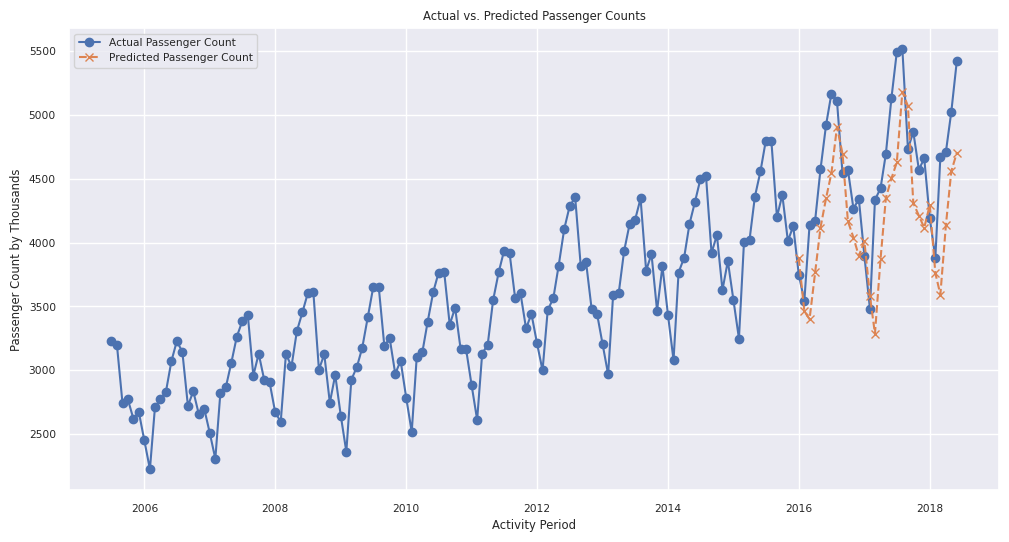

In [ ]:
plot_actual_vs_predicted(air_passenger_byperiod, y_test_lr, y_test_pred, SEQ_LENGTH)

In [ ]:

def plot_actual_vs_predicted_range(original_df, train_actual, train_pred, val_actual, val_pred, test_actual, test_pred,
                                   sequence_length, start_idx=None, end_idx=None, title='Actual vs. Predicted Passenger Counts'):
    """
    Plots actual vs. predicted values for training, validation, and test sets, with an optional range.

    Parameters:
    - original_df (pd.DataFrame): DataFrame containing the original time series data.
    - train_actual (np.array): Array of actual values for the training set.
    - train_pred (np.array): Array of predicted values for the training set.
    - val_actual (np.array): Array of actual values for the validation set.
    - val_pred (np.array): Array of predicted values for the validation set.
    - test_actual (np.array): Array of actual values for the test set.
    - test_pred (np.array): Array of predicted values for the test set.
    - sequence_length (int): Length of the sequences used for prediction.
    - start_idx (int, optional): Start index for the range of points to display.
    - end_idx (int, optional): End index for the range of points to display.
    - title (str): Title of the plot.
    """
    # Initialize 'Predicted Count' columns
    full_series = original_df.copy()
    full_series['Train Predicted Count'] = np.nan
    full_series['Val Predicted Count'] = np.nan
    full_series['Test Predicted Count'] = np.nan

    # Calculate indices for different sets
    train_end = len(train_actual) + sequence_length
    val_end = train_end + len(val_actual)
    test_end = val_end + len(test_actual)

    # Assign predicted values to the correct indices
    full_series.loc[sequence_length:train_end-1, 'Train Predicted Count'] = train_pred
    full_series.loc[train_end:val_end-1, 'Val Predicted Count'] = val_pred
    full_series.loc[val_end:test_end-1, 'Test Predicted Count'] = test_pred

    # Plot the actual vs. predicted values
    plt.figure(figsize=(12, 6))

    if start_idx is None: start_idx = sequence_length
    if end_idx is None: end_idx = len(full_series)

    plt.plot(full_series['Activity Period'][start_idx:end_idx], full_series['Passenger Count'][start_idx:end_idx], label='Actual Passenger Count', marker='o')
    plt.plot(full_series['Activity Period'][start_idx:end_idx], full_series['Train Predicted Count'][start_idx:end_idx], label='Train Predicted Count', linestyle='--', marker='x')
    plt.plot(full_series['Activity Period'][start_idx:end_idx], full_series['Val Predicted Count'][start_idx:end_idx], label='Val Predicted Count', linestyle='--', marker='x')
    plt.plot(full_series['Activity Period'][start_idx:end_idx], full_series['Test Predicted Count'][start_idx:end_idx], label='Test Predicted Count', linestyle='--', marker='x')

    plt.xlabel('Activity Period')
    plt.ylabel('Passenger Count')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
train_pred = lr_model.predict(X_train_lr)
val_pred = lr_model.predict(X_val_lr)
test_pred = lr_model.predict(X_test_lr)

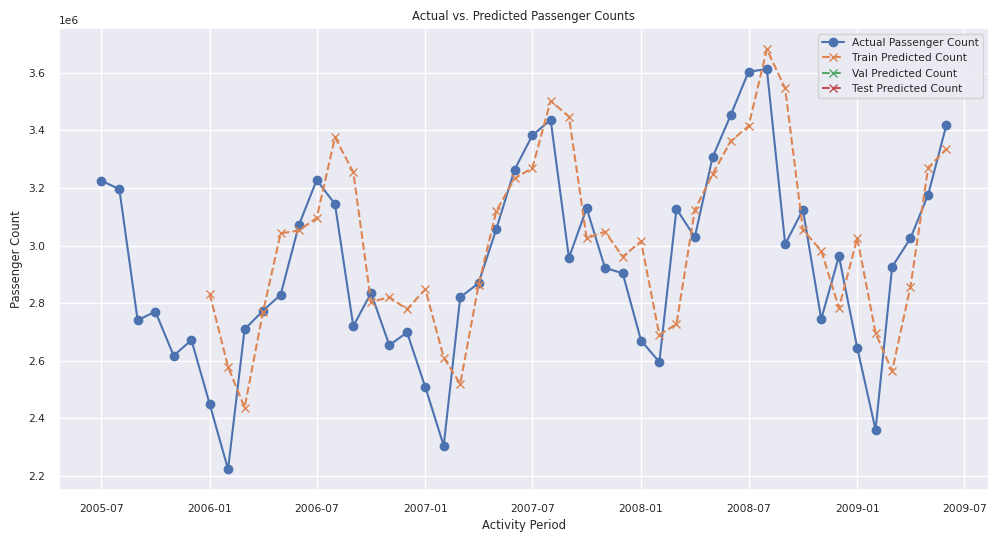

In [ ]:
# Plot using the function with a specific range
plot_actual_vs_predicted_range(air_passenger_byperiod, y_train_lr.values, train_pred, y_val_lr.values, val_pred, y_test_lr.values, test_pred, SEQ_LENGTH, start_idx=0, end_idx=48)

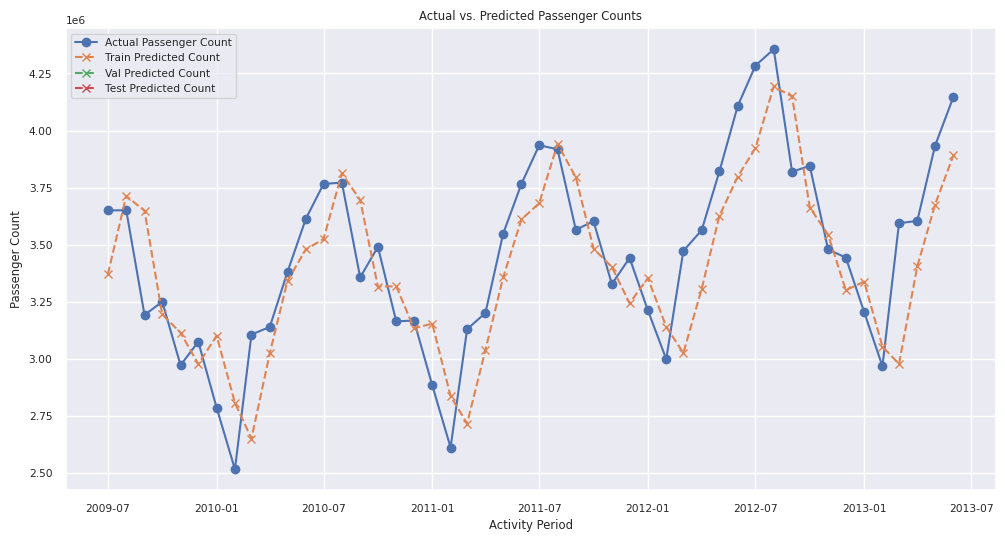

In [ ]:
plot_actual_vs_predicted_range(air_passenger_byperiod, y_train_lr.values, train_pred, y_val_lr.values, val_pred, y_test_lr.values, test_pred, SEQ_LENGTH, start_idx=48, end_idx=96)

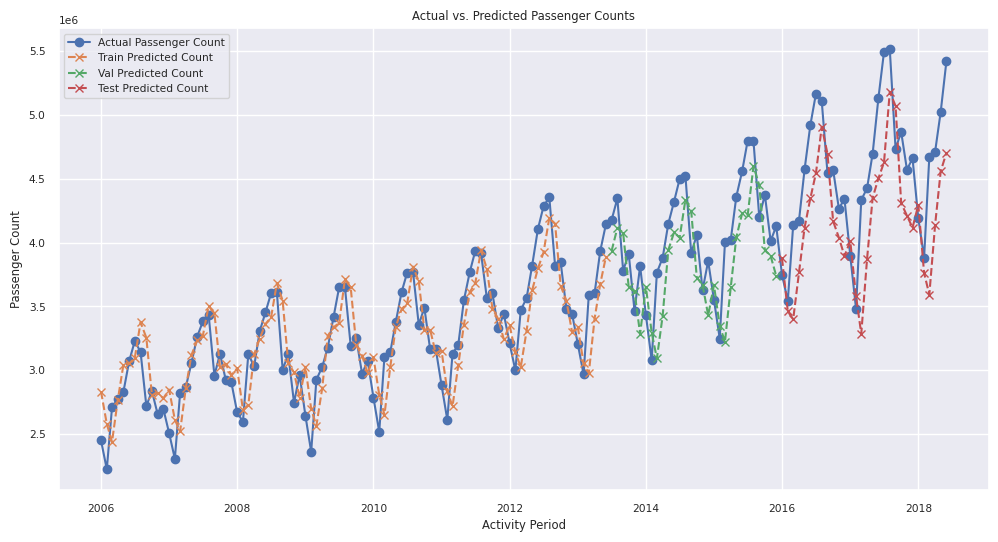

In [ ]:
plot_actual_vs_predicted_range(air_passenger_byperiod, y_train_lr.values, train_pred, y_val_lr.values, val_pred, y_test_lr.values, test_pred, SEQ_LENGTH)

### Linear Regression with Correlated Features

#### Predicting Passenger Count Using Activity Period and Operating Airlines Frequency

In [ ]:
# Count the number of times each airline appears in each activity period
airline_count_by_period = air_passenger_df.groupby(['Activity Period', 'Operating Airline']).size().reset_index(name='Frequency in Data')

# Pivot the DataFrame to have airlines as columns
airline_flights_pivot = airline_count_by_period.pivot(index='Activity Period', columns='Operating Airline', values='Frequency in Data').fillna(0)

airline_flights_pivot

Operating Airline  ABC Aerolineas S.A. de C.V. dba Interjet  ATA Airlines  \
Activity Period                                                             
2005-07-01                                              0.0           3.0   
2005-08-01                                              0.0           3.0   
2005-09-01                                              0.0           3.0   
2005-10-01                                              0.0           3.0   
2005-11-01                                              0.0           5.0   
...                                                     ...           ...   
2018-02-01                                              0.0           0.0   
2018-03-01                                              2.0           0.0   
2018-04-01                                              2.0           0.0   
2018-05-01                                              2.0           0.0   
2018-06-01                                              2.0           0.0   

Operating Airline  Aer Lingus  Aeromexico  Air Berlin  Air Canada  \
Activity Period                                                     
2005-07-01                0.0         0.0         0.0         2.0   
2005-08-01                0.0         0.0         0.0         2.0   
2005-09-01                0.0         0.0         0.0         2.0   
2005-10-01                0.0         0.0         0.0         2.0   
2005-11-01                0.0         0.0         0.0         2.0   
...                       ...         ...         ...         ...   
2018-02-01                2.0         2.0         0.0         2.0   
2018-03-01                2.0         2.0         0.0         2.0   
2018-04-01                2.0         2.0         0.0         2.0   
2018-05-01                2.0         2.0         0.0         2.0   
2018-06-01                2.0         2.0         0.0         2.0   

Operating Airline  Air Canada Jazz  Air China  Air France  Air India Limited  \
Activity Period                                                                
2005-07-01                     0.0        2.0         2.0                0.0   
2005-08-01                     0.0        2.0         2.0                0.0   
2005-09-01                     0.0        2.0         2.0                0.0   
2005-10-01                     0.0        2.0         2.0                0.0   
2005-11-01                     0.0        2.0         2.0                0.0   
...                            ...        ...         ...                ...   
2018-02-01                     0.0        2.0         2.0                2.0   
2018-03-01                     0.0        2.0         2.0                2.0   
2018-04-01                     0.0        2.0         2.0                2.0   
2018-05-01                     0.0        2.0         2.0                2.0   
2018-06-01                     0.0        2.0         2.0                2.0   

Operating Airline  ...  United Airlines  United Airlines - Pre 07/01/2013  \
Activity Period    ...                                                      
2005-07-01         ...              2.0                              20.0   
2005-08-01         ...              2.0                              22.0   
2005-09-01         ...              2.0                              23.0   
2005-10-01         ...              2.0                              23.0   
2005-11-01         ...              2.0                              19.0   
...                ...              ...                               ...   
2018-02-01         ...             28.0                               0.0   
2018-03-01         ...             27.0                               0.0   
2018-04-01         ...             27.0                               0.0   
2018-05-01         ...             26.0                               0.0   
2018-06-01         ...             29.0                               0.0   

Operating Airline  Virgin America  Virgin Atlantic  Volar

In [ ]:
# Group by Activity Period to get the sum of passenger counts
passenger_count_by_period = air_passenger_df.groupby('Activity Period')['Passenger Count'].sum().reset_index()

In [ ]:
# Merge with the Passenger Counts
# Keep only the 'Activity Period' column in the original DataFrame for merging
air_passenger_with_frequency = pd.merge(
    airline_flights_pivot,
    passenger_count_by_period,
    on='Activity Period',
    how='left')
air_passenger_with_frequency.head()

Activity Period  ABC Aerolineas S.A. de C.V. dba Interjet  ATA Airlines  \
0      2005-07-01                                       0.0           3.0   
1      2005-08-01                                       0.0           3.0   
2      2005-09-01                                       0.0           3.0   
3      2005-10-01                                       0.0           3.0   
4      2005-11-01                                       0.0           5.0   

   Aer Lingus  Aeromexico  Air Berlin  Air Canada  Air Canada Jazz  Air China  \
0         0.0         0.0         0.0         2.0              0.0        2.0   
1         0.0         0.0         0.0         2.0              0.0        2.0   
2         0.0         0.0         0.0         2.0              0.0        2.0   
3         0.0         0.0         0.0         2.0              0.0        2.0   
4         0.0         0.0         0.0         2.0              0.0        2.0   

   Air France  ...  United Airlines - Pre 07/01/2013  Virgin America  \
0         2.0  ...                              20.0             0.0   
1         2.0  ...                              22.0             0.0   
2         2.0  ...                              23.0             0.0   
3         2.0  ...                              23.0             0.0   
4         2.0  ...                              19.0             0.0   

   Virgin Atlantic  Volaris Airlines  WOW Air  WestJet Airlines  \
0              2.0               0.0      0.0               2.0   
1              2.0               0.0      0.0               2.0   
2              2.0               0.0      0.0               2.0   
3              2.0               0.0      0.0               2.0   
4              2.0               0.0      0.0               2.0   

   World Airways  XL Airways France  Xtra Airways  Passenger Count  
0            0.0                0.0           0.0          3225769  
1            0.0                0.0           0.0          3195866  
2            0.0                0.0           0.0          2740553  
3            0.0                0.0           0.0          2770715  
4            0.0                0.0           0.0          2617333  

[5 rows x 91 columns]

In [ ]:
air_passenger_with_frequency.shape

(156, 91)

#### Train Test Split

In [ ]:
# Create sequences
def create_sequences_with_features(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

In [ ]:
# Extract features and target
features = air_passenger_with_frequency.drop(columns=['Activity Period'])
target = air_passenger_with_frequency['Passenger Count']

# Create sequences
X, y = create_sequences_with_features(features.values, target.values, SEQ_LENGTH)
y_target = target[SEQ_LENGTH:].values

In [ ]:
# lr_freq_model: Split data into train and temporary sets
X_train_lr_freq, X_temp_lr_freq, y_train_lr_freq, y_temp_lr_freq = train_test_split(X, y_target, test_size=0.4, shuffle=False)

# Further split the temporary set into validation and test sets
X_val_lr_freq, X_test_lr_freq, y_val_lr_freq, y_test_lr_freq = train_test_split(X_temp_lr_freq, y_temp_lr_freq, test_size=0.5, shuffle=False)

# Example to check the shapes
print(f'Train X shape (lr_freq_model): {X_train_lr_freq.shape}')
print(f'Train y shape (lr_freq_model): {y_train_lr_freq.shape}')
print(f'Val X shape (lr_freq_model): {X_val_lr_freq.shape}')
print(f'Val y shape (lr_freq_model): {y_val_lr_freq.shape}')
print(f'Test X shape (lr_freq_model): {X_test_lr_freq.shape}')
print(f'Test y shape (lr_freq_model): {y_test_lr_freq.shape}')

Train X shape (lr_freq_model): (90, 6, 90)
Train y shape (lr_freq_model): (90,)
Val X shape (lr_freq_model): (30, 6, 90)
Val y shape (lr_freq_model): (30,)
Test X shape (lr_freq_model): (30, 6, 90)
Test y shape (lr_freq_model): (30,)


#### Train Model

In [ ]:
# Initialize and train the model
lr_freq_model = LinearRegression()
lr_freq_model.fit(X_train_lr_freq.reshape(X_train_lr_freq.shape[0], -1), y_train_lr_freq)

LinearRegression()

In [ ]:
X_train_lr_freq.shape

(90, 6, 90)

In [ ]:
# Make predictions
train_pred = lr_freq_model.predict(X_train_lr_freq.reshape(X_train_lr_freq.shape[0], -1))
val_pred = lr_freq_model.predict(X_val_lr_freq.reshape(X_val_lr_freq.shape[0], -1))
test_pred = lr_freq_model.predict(X_test_lr_freq.reshape(X_test_lr_freq.shape[0], -1))

# Evaluate the model
train_mse = mse(y_train_lr_freq, train_pred)
val_mse = mse(y_val_lr_freq, val_pred)
test_mse = mse(y_test_lr_freq, test_pred)

train_r2 = r2(y_train_lr_freq, train_pred)
val_r2 = r2(y_val_lr_freq, val_pred)
test_r2 = r2(y_test_lr_freq, test_pred)

print(f'Train MSE: {train_mse}')
print(f'Validation MSE: {val_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R^2: {train_r2}')
print(f'Validation R^2: {val_r2}')
print(f'Test R^2: {test_r2}')

Train MSE: 2.4560454954043434e-10
Validation MSE: 1325730042215.6514
Test MSE: 6523345053308.009
Train R^2: 1.0
Validation R^2: -6.568909018976888
Test R^2: -22.0018376887818


#### Graph Metrics

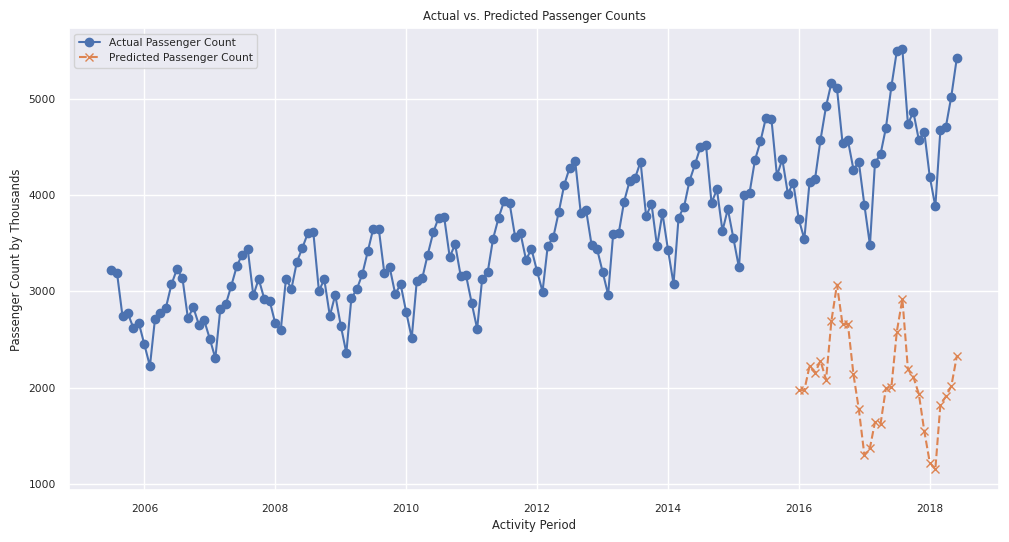

In [ ]:
plot_actual_vs_predicted(air_passenger_with_frequency, y_test_lr_freq, test_pred, SEQ_LENGTH)

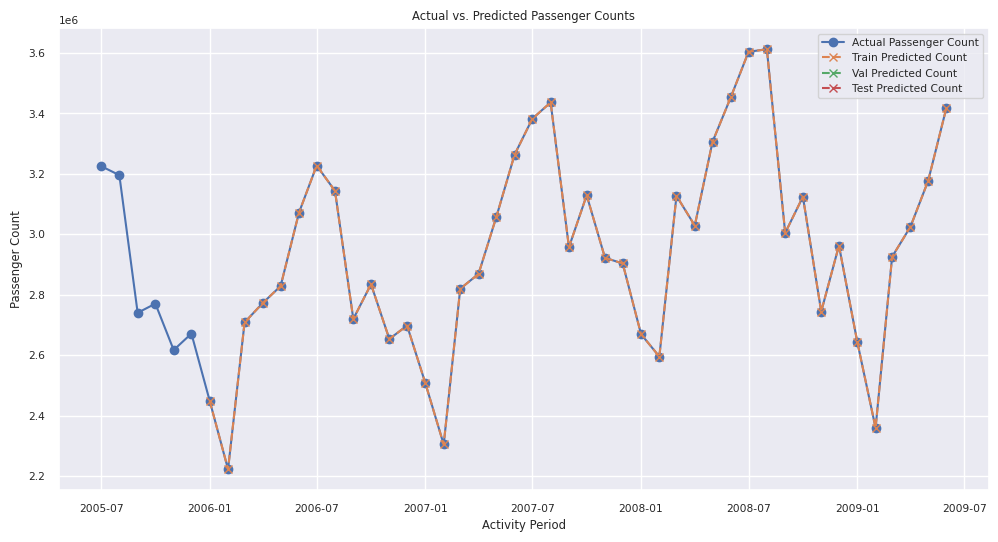

In [ ]:
plot_actual_vs_predicted_range(air_passenger_with_frequency, y_train_lr_freq, train_pred, y_val_lr_freq, val_pred, y_test_lr_freq, test_pred, SEQ_LENGTH, start_idx=0, end_idx=48)

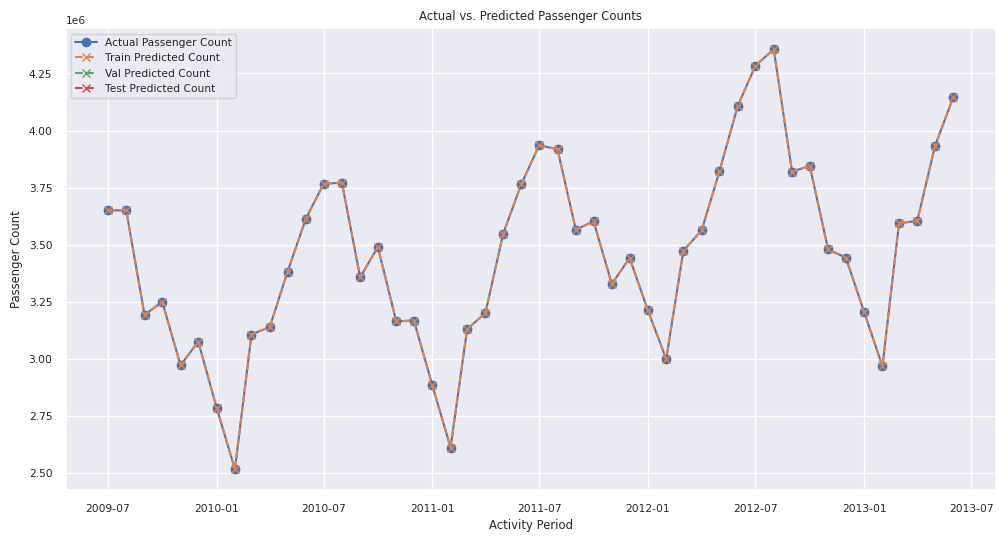

In [ ]:
plot_actual_vs_predicted_range(air_passenger_with_frequency, y_train_lr_freq, train_pred, y_val_lr_freq, val_pred, y_test_lr_freq, test_pred, SEQ_LENGTH, start_idx=48, end_idx=96)

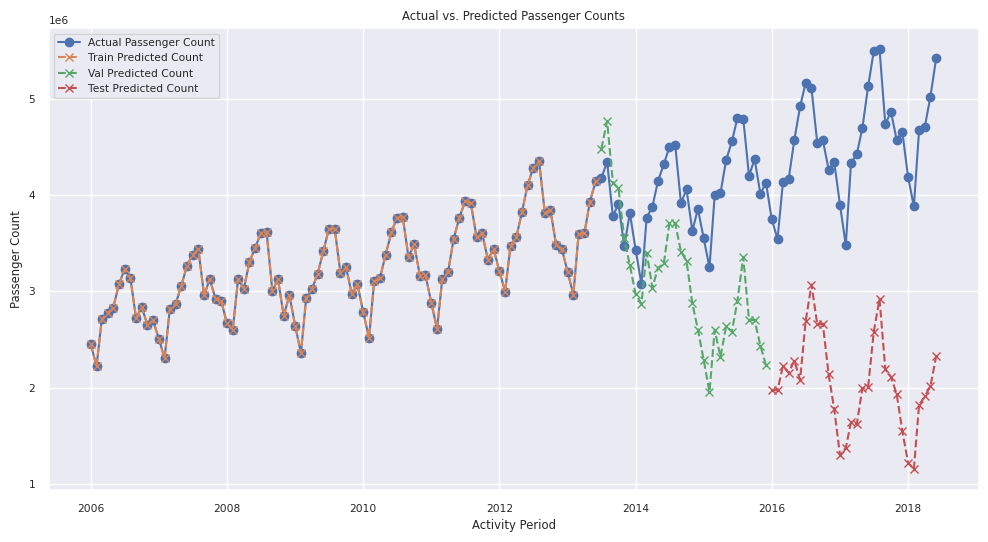

In [ ]:
plot_actual_vs_predicted_range(air_passenger_with_frequency, y_train_lr_freq, train_pred, y_val_lr_freq, val_pred, y_test_lr_freq, test_pred, SEQ_LENGTH)

This Model Overfits to the Training Data

### 2. Predicting Passenger Count by Season

In [ ]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

air_passenger_season_df = air_passenger_df[['Activity Period', 'Passenger Count']]

# Apply the function to create the Season feature
air_passenger_season_df['Season'] = air_passenger_df['Activity Period'].dt.month.apply(get_season)

# Group by Activity Period and Season to Get Total Passenger Count
air_passenger_season_df = air_passenger_season_df.groupby(['Activity Period', 'Season'])['Passenger Count'].sum().reset_index()

air_passenger_season_df.head()

Activity Period  Season  Passenger Count
0      2005-07-01  Summer          3225769
1      2005-08-01  Summer          3195866
2      2005-09-01    Fall          2740553
3      2005-10-01    Fall          2770715
4      2005-11-01    Fall          2617333

In [ ]:
# One-hot encode the Season feature
air_passenger_season_df = pd.get_dummies(air_passenger_season_df, columns=['Season'])

# Display the DataFrame with one-hot encoded Season feature
air_passenger_season_df.head()

Activity Period  Passenger Count  Season_Fall  Season_Spring  Season_Summer  \
0      2005-07-01          3225769        False          False           True   
1      2005-08-01          3195866        False          False           True   
2      2005-09-01          2740553         True          False          False   
3      2005-10-01          2770715         True          False          False   
4      2005-11-01          2617333         True          False          False   

   Season_Winter  
0          False  
1          False  
2          False  
3          False  
4          False

#### Train Test Split

In [ ]:
# Extract features and target
features = air_passenger_season_df.drop(columns=['Activity Period'])
target = air_passenger_season_df['Passenger Count']

# Create sequences
X, y = create_sequences_with_features(features.values, target.values, SEQ_LENGTH)

In [ ]:
# lr_season_model: Split data into train and temporary sets
X_train_lr_season, X_temp_lr_season, y_train_lr_season, y_temp_lr_season = train_test_split(X, y, test_size=0.4, shuffle=False)

# Further split the temporary set into validation and test sets
X_val_lr_season, X_test_lr_season, y_val_lr_season, y_test_lr_season = train_test_split(X_temp_lr_season, y_temp_lr_season, test_size=0.5, shuffle=False)

# Example to check the shapes
print(f'Train X shape (lr_season_model): {X_train_lr_season.shape}')
print(f'Train y shape (lr_season_model): {y_train_lr_season.shape}')
print(f'Val X shape (lr_season_model): {X_val_lr_season.shape}')
print(f'Val y shape (lr_season_model): {y_val_lr_season.shape}')
print(f'Test X shape (lr_season_model): {X_test_lr_season.shape}')
print(f'Test y shape (lr_season_model): {y_test_lr_season.shape}')

Train X shape (lr_season_model): (90, 6, 5)
Train y shape (lr_season_model): (90,)
Val X shape (lr_season_model): (30, 6, 5)
Val y shape (lr_season_model): (30,)
Test X shape (lr_season_model): (30, 6, 5)
Test y shape (lr_season_model): (30,)


#### Train Model

In [ ]:
# Initialize and train the model
lr_season_model = LinearRegression()
lr_season_model.fit(X_train_lr_season.reshape(X_train_lr_season.shape[0], -1), y_train_lr_season)

LinearRegression()

#### Evaluation of Model

In [ ]:
# Make predictions
train_pred = lr_season_model.predict(X_train_lr_season.reshape(X_train_lr_season.shape[0], -1))
val_pred = lr_season_model.predict(X_val_lr_season.reshape(X_val_lr_season.shape[0], -1))
test_pred = lr_season_model.predict(X_test_lr_season.reshape(X_test_lr_season.shape[0], -1))

# Evaluate the model
train_mse = mse(y_train_lr_season, train_pred)
val_mse = mse(y_val_lr_season, val_pred)
test_mse = mse(y_test_lr_season, test_pred)

train_r2 = r2(y_train_lr_season, train_pred)
val_r2 = r2(y_val_lr_season, val_pred)
test_r2 = r2(y_test_lr_season, test_pred)

print(f'Train MSE: {train_mse}')
print(f'Validation MSE: {val_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R^2: {train_r2}')
print(f'Validation R^2: {val_r2}')
print(f'Test R^2: {test_r2}')

Train MSE: 4494523002.920854
Validation MSE: 14528335118.989502
Test MSE: 26787243321.336082
Train R^2: 0.9781967208015596
Validation R^2: 0.9170542695637647
Test R^2: 0.9055460322929227


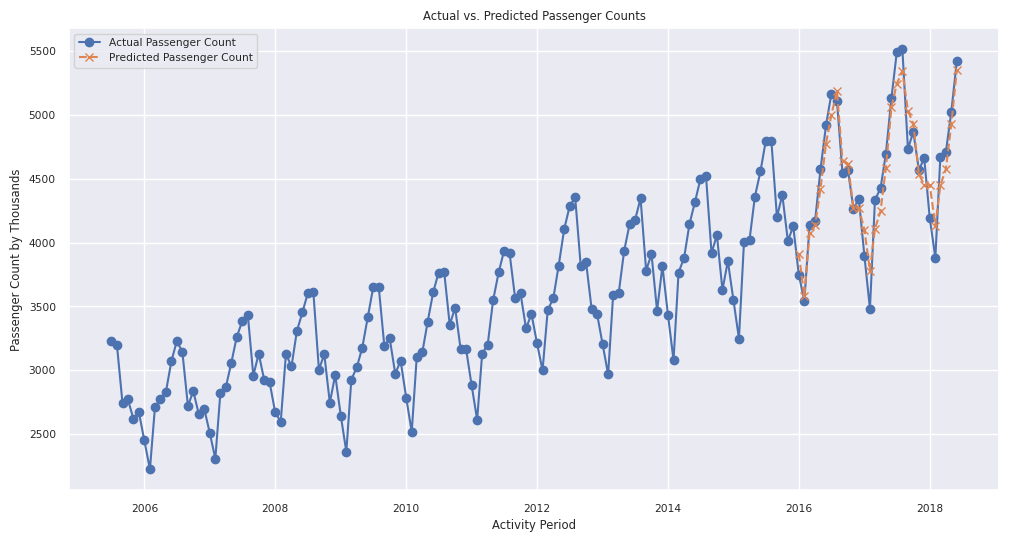

In [ ]:
plot_actual_vs_predicted(air_passenger_season_df, y_test_lr_season, lr_season_model.predict(X_test_lr_season.reshape(X_test_lr_season.shape[0], -1)), SEQ_LENGTH)

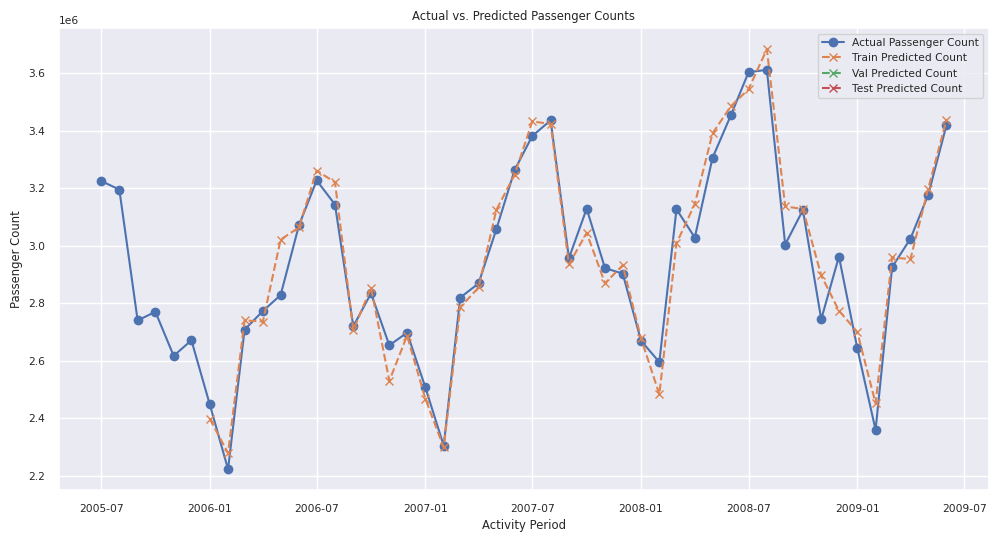

In [ ]:
plot_actual_vs_predicted_range(air_passenger_season_df, y_train_lr_season, train_pred, y_val_lr_season, val_pred, y_test_lr_season, test_pred, SEQ_LENGTH, start_idx=0, end_idx=48)

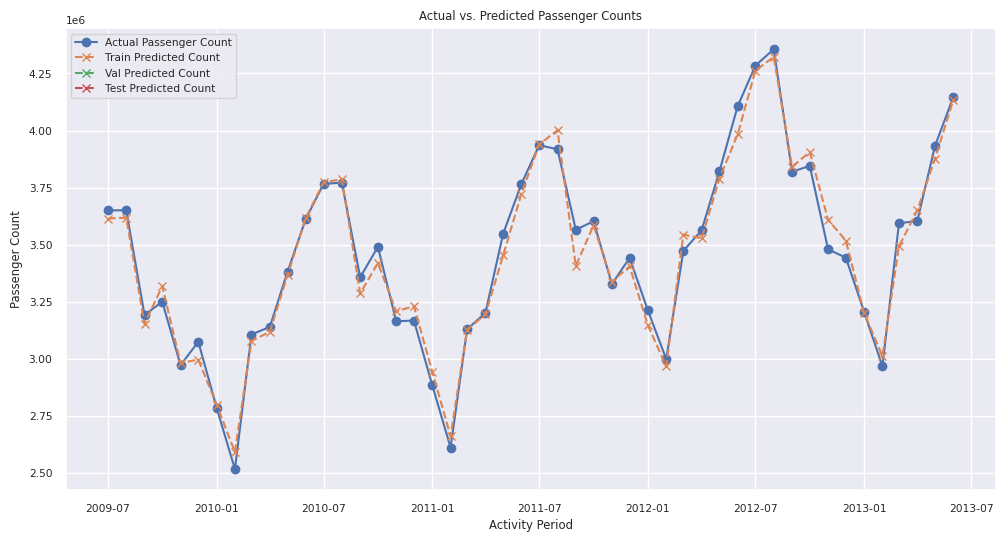

In [ ]:
plot_actual_vs_predicted_range(air_passenger_season_df, y_train_lr_season, train_pred, y_val_lr_season, val_pred, y_test_lr_season, test_pred, SEQ_LENGTH, start_idx=48, end_idx=96)

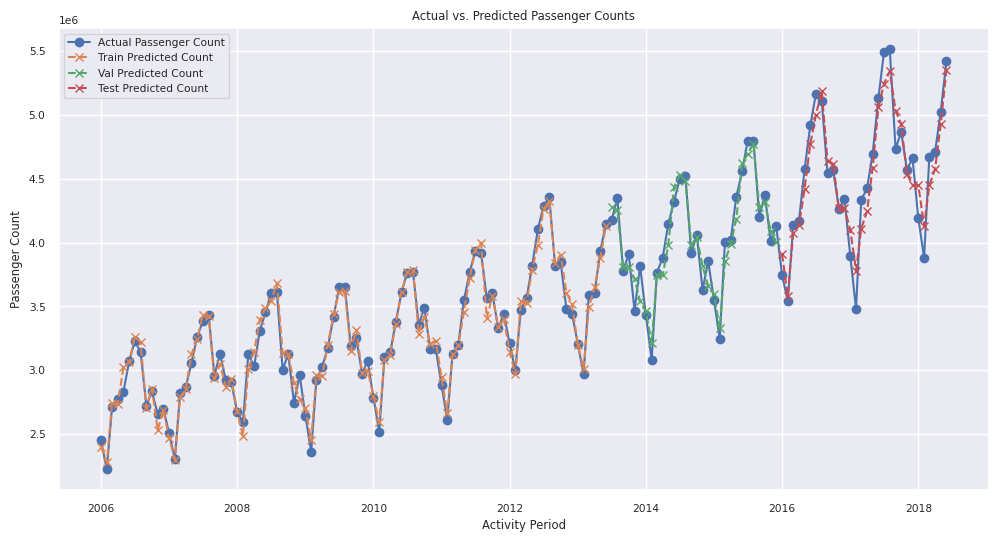

In [ ]:
plot_actual_vs_predicted_range(air_passenger_season_df, y_train_lr_season, train_pred, y_val_lr_season, val_pred, y_test_lr_season, test_pred, SEQ_LENGTH)

### Comparison of 3 Linear Regression Models

In [ ]:
# Predict using the trained lr_model
train_pred_lr = lr_model.predict(X_train_lr)
val_pred_lr = lr_model.predict(X_val_lr)
test_pred_lr = lr_model.predict(X_test_lr)

# Predict using the trained lr_freq_model
train_pred_lr_freq = lr_freq_model.predict(X_train_lr_freq.reshape(X_train_lr_freq.shape[0], -1))
val_pred_lr_freq = lr_freq_model.predict(X_val_lr_freq.reshape(X_val_lr_freq.shape[0], -1))
test_pred_lr_freq = lr_freq_model.predict(X_test_lr_freq.reshape(X_test_lr_freq.shape[0], -1))

# Predict using the trained lr_season_model
train_pred_lr_season = lr_season_model.predict(X_train_lr_season.reshape(X_train_lr_season.shape[0], -1))
val_pred_lr_season = lr_season_model.predict(X_val_lr_season.reshape(X_val_lr_season.shape[0], -1))
test_pred_lr_season = lr_season_model.predict(X_test_lr_season.reshape(X_test_lr_season.shape[0], -1))

In [ ]:
# Evaluate the models
def evaluate_model(y_train, train_pred, y_val, val_pred, y_test, test_pred):
    train_mse = mse(y_train, train_pred)
    val_mse = mse(y_val, val_pred)
    test_mse = mse(y_test, test_pred)

    train_r2 = r2(y_train, train_pred)
    val_r2 = r2(y_val, val_pred)
    test_r2 = r2(y_test, test_pred)

    return train_mse, val_mse, test_mse, train_r2, val_r2, test_r2

train_mse_lr, val_mse_lr, test_mse_lr, train_r2_lr, val_r2_lr, test_r2_lr = evaluate_model(y_train_lr, train_pred_lr, y_val_lr, val_pred_lr, y_test_lr, test_pred_lr)
train_mse_lr_freq, val_mse_lr_freq, test_mse_lr_freq, train_r2_lr_freq, val_r2_lr_freq, test_r2_lr_freq = evaluate_model(y_train_lr_freq, train_pred_lr_freq, y_val_lr_freq, val_pred_lr_freq, y_test_lr_freq, test_pred_lr_freq)
train_mse_lr_season, val_mse_lr_season, test_mse_lr_season, train_r2_lr_season, val_r2_lr_season, test_r2_lr_season = evaluate_model(y_train_lr_season, train_pred_lr_season, y_val_lr_season, val_pred_lr_season, y_test_lr_season, test_pred_lr_season)

In [ ]:
# Print the results
print(f'lr_model: Train MSE: {train_mse_lr}, Val MSE: {val_mse_lr}, Test MSE: {test_mse_lr}')
print(f'lr_model: Train R^2: {train_r2_lr}, Val R^2: {val_r2_lr}, Test R^2: {test_r2_lr}')

print(f'lr_freq_model: Train MSE: {train_mse_lr_freq}, Val MSE: {val_mse_lr_freq}, Test MSE: {test_mse_lr_freq}')
print(f'lr_freq_model: Train R^2: {train_r2_lr_freq}, Val R^2: {val_r2_lr_freq}, Test R^2: {test_r2_lr_freq}')

print(f'lr_season_model: Train MSE: {train_mse_lr_season}, Val MSE: {val_mse_lr_season}, Test MSE: {test_mse_lr_season}')
print(f'lr_season_model: Train R^2: {train_r2_lr_season}, Val R^2: {val_r2_lr_season}, Test R^2: {test_r2_lr_season}')

lr_model: Train MSE: 60271950052.27326, Val MSE: 128466878653.38383, Test MSE: 268771214222.81955
lr_model: Train R^2: 0.7076161020935583, Val R^2: 0.2665519483481409, Test R^2: 0.05229114902712839
lr_freq_model: Train MSE: 2.4560454954043434e-10, Val MSE: 1325730042215.6514, Test MSE: 6523345053308.009
lr_freq_model: Train R^2: 1.0, Val R^2: -6.568909018976888, Test R^2: -22.0018376887818
lr_season_model: Train MSE: 4494523002.920854, Val MSE: 14528335118.989502, Test MSE: 26787243321.336082
lr_season_model: Train R^2: 0.9781967208015596, Val R^2: 0.9170542695637647, Test R^2: 0.9055460322929227


In [ ]:
# Function to plot comparison of actual vs predicted values for all models
def plot_actual_vs_predicted_all(y_train, y_val, y_test, preds, labels):
    # Define x-axis ranges
    x_train = np.arange(len(y_train))
    x_val = np.arange(len(y_train), len(y_train) + len(y_val))
    x_test = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test))

    # Define colors and markers for different plots
    colors = ['blue', 'green', 'orange', 'red']
    markers = ['o', 's', 'D', '^']

    # Create subplots
    plt.figure(figsize=(15, 15))

    # Plot for training data
    plt.subplot(3, 1, 1)
    plt.plot(x_train, y_train, label='Actual Train', color='blue', marker='o', linestyle='-', markersize=5)
    for i, (pred, label) in enumerate(zip(preds, labels)):
        plt.plot(x_train, pred[0], label=f'Predicted Train ({label})', color=colors[i +1 % len(colors)], marker=markers[i % len(markers)], linestyle='--', markersize=5)
    plt.title('Actual vs Predicted (Train)')
    plt.xlabel('Time Period')
    plt.ylabel('Passenger Count')
    plt.legend()

    # Plot for validation data
    plt.subplot(3, 1, 2)
    plt.plot(x_val, y_val, label='Actual Validation', color='blue', marker='o', linestyle='-', markersize=5)
    for i, (pred, label) in enumerate(zip(preds, labels)):
        plt.plot(x_val, pred[1], label=f'Predicted Validation ({label})', color=colors[i +1 % len(colors)], marker=markers[i % len(markers)], linestyle='--', markersize=5)
    plt.title('Actual vs Predicted (Validation)')
    plt.xlabel('Time Period')
    plt.ylabel('Passenger Count')
    plt.legend()

    # Plot for test data
    plt.subplot(3, 1, 3)
    plt.plot(x_test, y_test, label='Actual Test', color='blue', marker='o', linestyle='-', markersize=5)
    for i, (pred, label) in enumerate(zip(preds, labels)):
        plt.plot(x_test, pred[2], label=f'Predicted Test ({label})', color=colors[i + 1 % len(colors)], marker=markers[i % len(markers)], linestyle='--', markersize=5)
    plt.title('Actual vs Predicted (Test)')
    plt.xlabel('Time Period')
    plt.ylabel('Passenger Count')
    plt.legend()

    plt.tight_layout()
    plt.show()


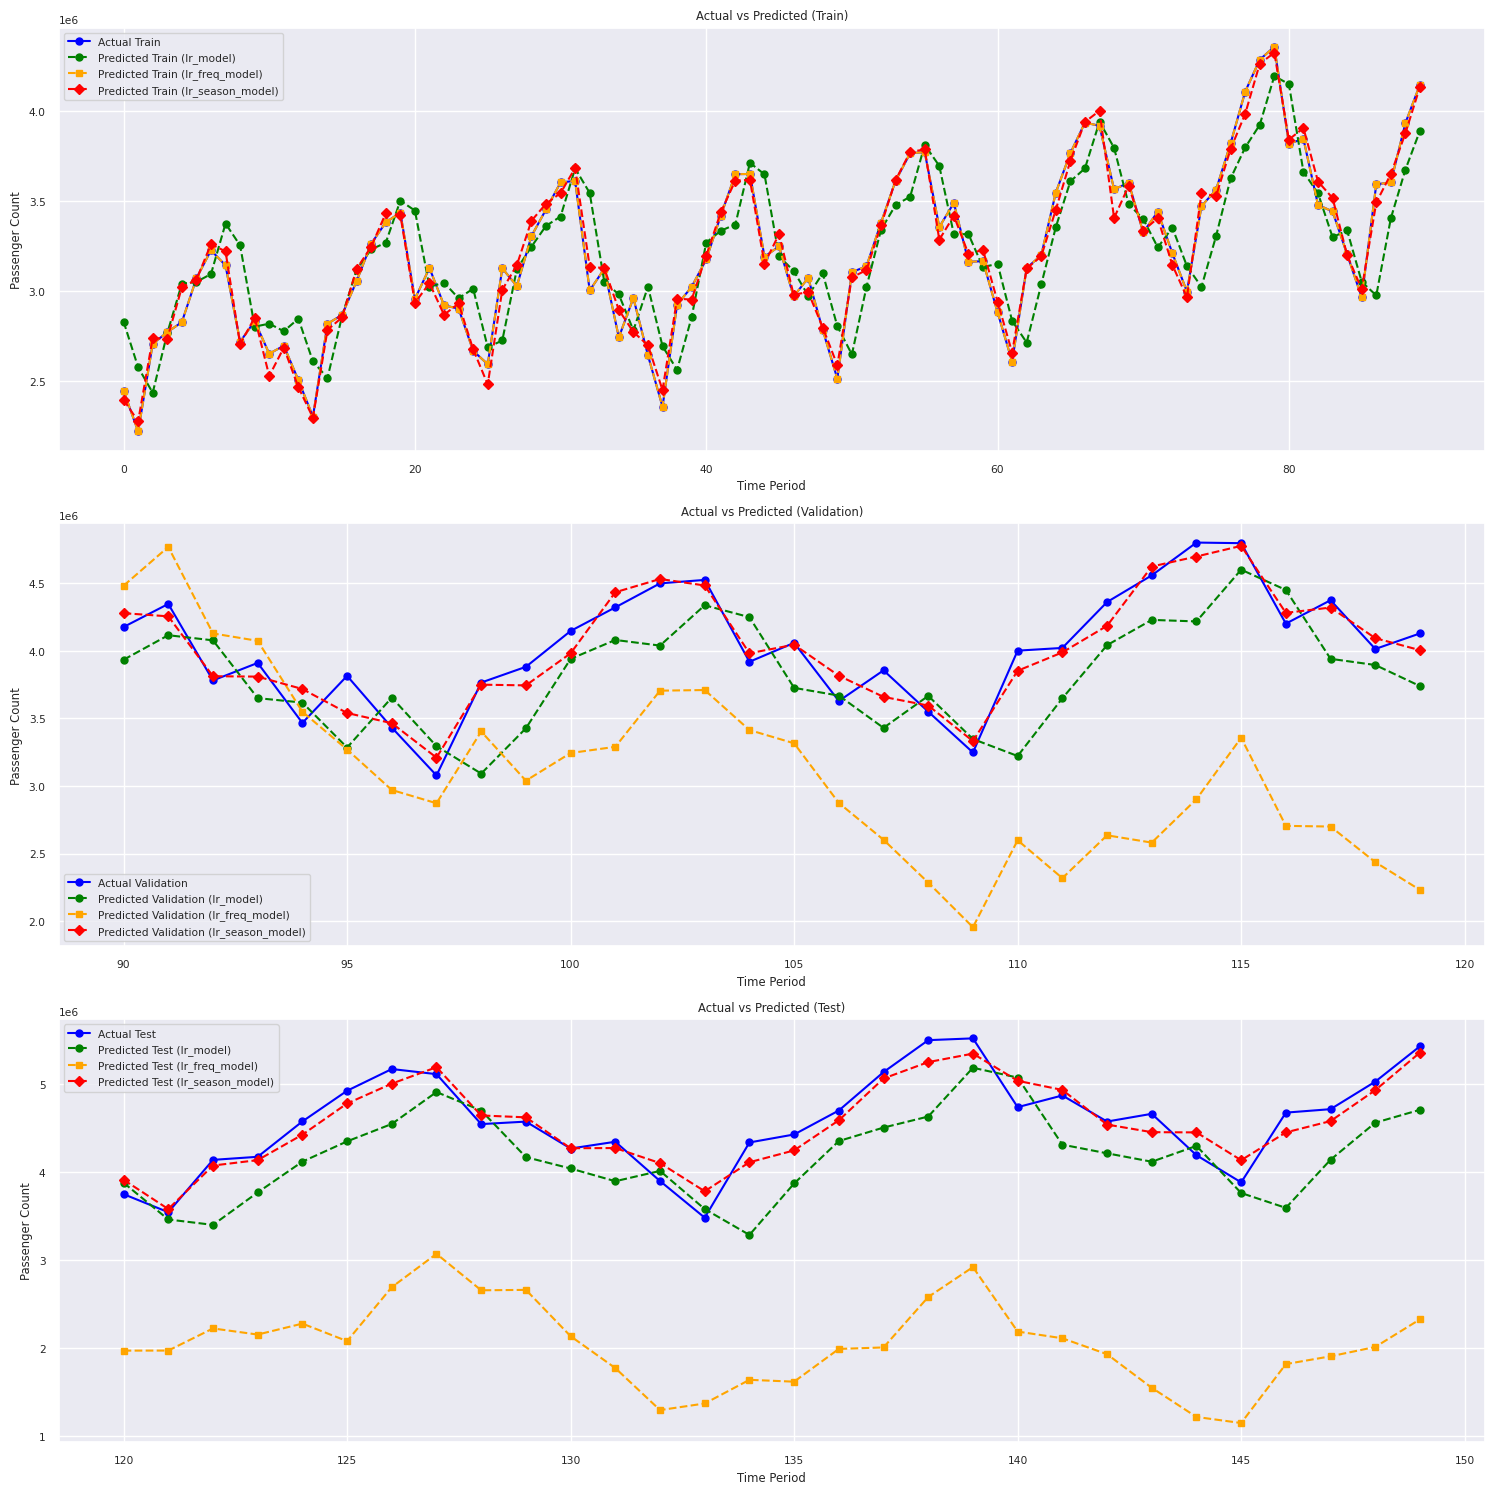

In [ ]:
# Plot the results
plot_actual_vs_predicted_all(
    y_train=y_train_lr, y_val=y_val_lr, y_test=y_test_lr,
    preds=[
        (train_pred_lr, val_pred_lr, test_pred_lr),
        (train_pred_lr_freq, val_pred_lr_freq, test_pred_lr_freq),
        (train_pred_lr_season, val_pred_lr_season, test_pred_lr_season)
    ],
    labels=['lr_model', 'lr_freq_model', 'lr_season_model']
)


The analysis of the linear regression models reveals the following:

- lr_model: This model shows a significant drop in performance from training to validation and test sets. While it achieves a reasonably good training MSE of approximately 60.3 billion and an R² score of 0.71, its validation and test MSE values rise sharply to around 128.5 billion and 268.8 billion, respectively. The R² score drops substantially to 0.27 and 0.05 for validation and test sets, indicating poor generalization and a high level of overfitting.

- lr_freq_model: This model exhibits an exceptional fit on the training data, with an MSE close to zero and an R² score of 1.0, suggesting perfect training accuracy. However, it performs poorly on validation and test sets with very high MSE values (over 1.3 trillion for validation and over 6.5 trillion for test) and negative R² scores, indicating a severe overfitting issue and a model that does not generalize well to new data.

- lr_season_model: This model performs consistently across training, validation, and test sets. The training MSE is relatively low at approximately 4.5 billion with a high R² score of 0.98, suggesting good fit and low overfitting. Validation and test MSE values are higher but still reasonable, at around 14.5 billion and 26.8 billion, respectively. The R² scores for validation and test sets are 0.92 and 0.91, reflecting a strong generalization capability and overall better performance compared to the other models.

Overall, the lr_season_model demonstrates the best balance between fitting the training data and generalizing to unseen data, while the lr_model and lr_freq_model show issues with overfitting and poor predictive performance on validation and test sets.

# Deep Learning Models
### Train, Test Split

## Transformers
### Train Test Split

In [ ]:
# Get DataFrame of Passenger Counts Grouped by Activity Period
air_passenger_transformer = air_passenger_df.groupby('Activity Period')['Passenger Count'].sum().reset_index()
air_passenger_transformer.head()

Activity Period  Passenger Count
0      2005-07-01          3225769
1      2005-08-01          3195866
2      2005-09-01          2740553
3      2005-10-01          2770715
4      2005-11-01          2617333

In [ ]:
# Scale Passenger Count
scaler = MinMaxScaler()
air_passenger_transformer['Passenger Count'] = scaler.fit_transform(air_passenger_transformer['Passenger Count'].values.reshape(-1, 1))

In [ ]:
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

X, y = to_sequences(SEQ_LENGTH, air_passenger_transformer['Passenger Count'].values)

In [ ]:
X[1]

tensor([[0.2954],
        [0.1571],
        [0.1663],
        [0.1197],
        [0.1362],
        [0.0686]])

In [ ]:
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, shuffle=False)

X_train.shape

torch.Size([105, 6, 1])

In [ ]:
# Setup data loaders for batch
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The Following Transformer Code is Adapted from Jeff Heaton:

Heaton, J. (2023, November 1). Transformer-Based Time Series with PyTorch (10.3). YouTube. Retrieved July 31, 2024, from https://www.youtube.com/watch?v=NGzQpphf_Vc
### Positional Encoding
Adding Cosine and Sine to the Inputs


In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### Model Definition

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

transformer_model = TransformerModel().to(device)

#### Train Model

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    transformer_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = transformer_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    transformer_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = transformer_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Validation Loss: 0.0237
Epoch 2/100, Validation Loss: 0.0305
Epoch 3/100, Validation Loss: 0.0180
Epoch 4/100, Validation Loss: 0.0164
Epoch 5/100, Validation Loss: 0.0160
Epoch 6/100, Validation Loss: 0.0148
Epoch 7/100, Validation Loss: 0.0121
Epoch 8/100, Validation Loss: 0.0129
Epoch 9/100, Validation Loss: 0.0102
Epoch 10/100, Validation Loss: 0.0107
Epoch 11/100, Validation Loss: 0.0135
Epoch 12/100, Validation Loss: 0.0107
Epoch 13/100, Validation Loss: 0.0170
Early stopping!


### Evaluate

In [ ]:
def evaluate_transformer_model(transformer_model, loader):
    transformer_model.eval()
    predictions = []
    with torch.no_grad():
        for batch in loader:
          x_batch, y_batch = batch
          x_batch = x_batch.to(device)
          outputs = transformer_model(x_batch)
          for output in outputs:
            predictions.append(output.item())
    return predictions

In [ ]:
# Evaluation
y_train_pred = evaluate_transformer_model(transformer_model, train_loader)
y_val_pred = evaluate_transformer_model(transformer_model, val_loader)
y_test_pred = evaluate_transformer_model(transformer_model, test_loader)


In [ ]:
# Unscale Prediction
y_train_pred = scaler.inverse_transform(np.array(y_train_pred).reshape(-1, 1))
y_val_pred = scaler.inverse_transform(np.array(y_val_pred).reshape(-1, 1))
y_test_pred = scaler.inverse_transform(np.array(y_test_pred).reshape(-1, 1))

y_train_unscaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
y_test_unscaled

array([[5110637.94912285],
       [4543758.9641484 ],
       [4571997.00503766],
       [4266481.08238959],
       [4343369.03964239],
       [3897684.9885872 ],
       [3481404.96182442],
       [4335287.06072777],
       [4425920.03634018],
       [4698066.92361486],
       [5134109.96659154],
       [5496516.02372014],
       [5516837.        ],
       [4736005.06687534],
       [4868673.91357958],
       [4572702.01369244],
       [4660503.96039873],
       [4190367.04441196],
       [3882181.08063191],
       [4674034.98281467],
       [4713183.08662635],
       [5025594.9794774 ],
       [5427144.03592729]])

In [ ]:
y_test_pred

array([[4705096.59220099],
       [4729707.5000084 ],
       [4501975.56900477],
       [4544742.95283615],
       [4369743.35255623],
       [4425252.13340408],
       [3891243.90700942],
       [3819411.35851753],
       [4412257.67145973],
       [4467714.22944426],
       [4641422.39365315],
       [4701144.93132567],
       [4788556.38451642],
       [4812272.82854462],
       [4602471.0090484 ],
       [4647341.24659777],
       [4528395.62600565],
       [4575421.13646287],
       [4194069.17423737],
       [4180712.09714812],
       [4560426.8922413 ],
       [4600911.9798845 ],
       [4658803.96876919]])

In [ ]:
# Create Passenger Count DF, with Passenger Count Column
transformer_passenger_counts_df = air_passenger_df[['Activity Period', 'Passenger Count']]

# Group by Activity Period
transformer_passenger_counts_df = transformer_passenger_counts_df.groupby('Activity Period')['Passenger Count'].sum().reset_index()

transformer_passenger_counts_df.head()

Activity Period  Passenger Count
0      2005-07-01          3225769
1      2005-08-01          3195866
2      2005-09-01          2740553
3      2005-10-01          2770715
4      2005-11-01          2617333

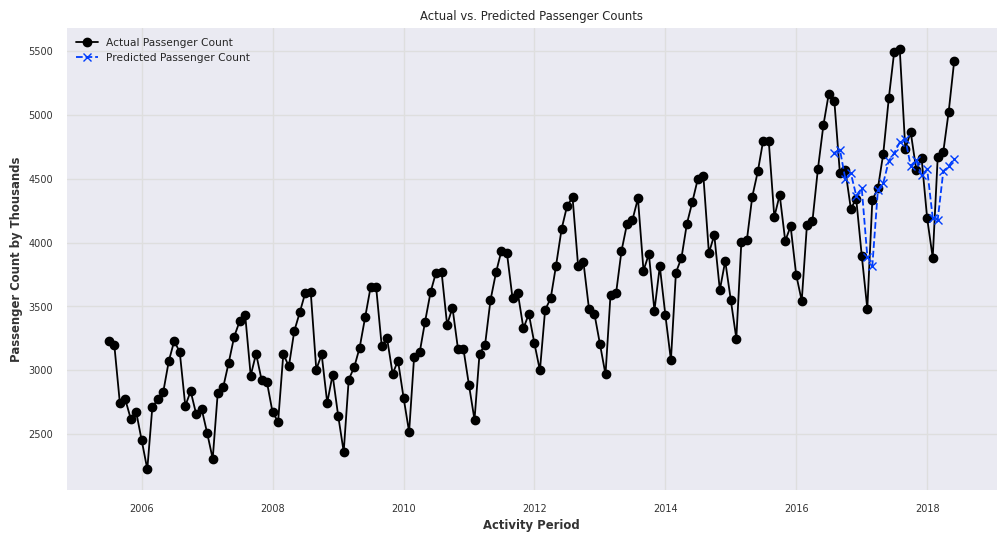

In [ ]:
plot_actual_vs_predicted(transformer_passenger_counts_df, y_test_unscaled, y_test_pred, SEQ_LENGTH)

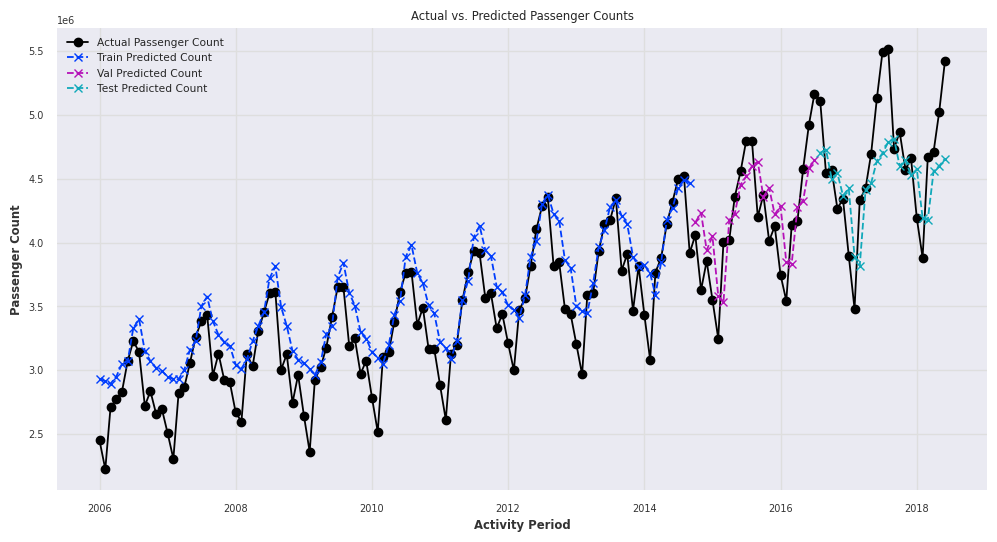

In [ ]:
plot_actual_vs_predicted_range(transformer_passenger_counts_df, y_train_unscaled, y_train_pred, y_val_unscaled, y_val_pred, y_test_unscaled, y_test_pred, SEQ_LENGTH)

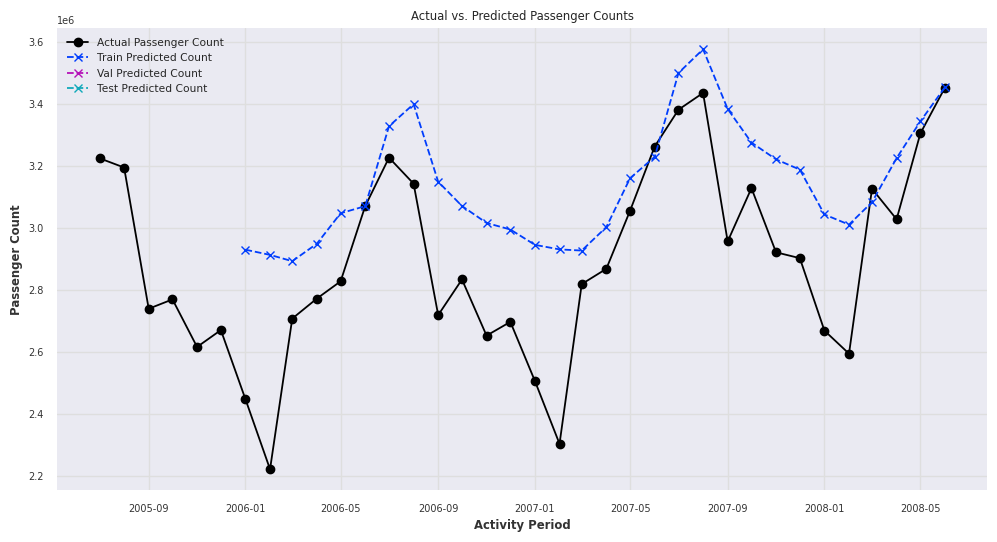

In [ ]:
plot_actual_vs_predicted_range(transformer_passenger_counts_df, y_train_unscaled, y_train_pred, y_val_unscaled, y_val_pred, y_test_unscaled, y_test_pred, SEQ_LENGTH, start_idx=0, end_idx=36)

In [ ]:
# Collect and Print MSE and R2
train_pred_mse = mse(y_train_unscaled, y_train_pred)
val_pred_mse = mse(y_val_unscaled, y_val_pred)
test_pred_mse = mse(y_test_unscaled, y_test_pred)

print(f'Train MSE: {train_pred_mse}')
print(f'Validation MSE: {val_pred_mse}')
print(f'Test MSE: {test_pred_mse}')

train_pred_r2 = r2(y_train_unscaled, y_train_pred)
val_pred_r2 = r2(y_val_unscaled, y_val_pred)
test_pred_r2 = r2(y_test_unscaled, y_test_pred)

print(f'Train R^2: {train_pred_r2}')
print(f'Validation R^2: {val_pred_r2}')
print(f'Test R^2: {test_pred_r2}')

Train MSE: 83279161768.3555
Validation MSE: 110933142902.68936
Test MSE: 166788646567.2442
Train R^2: 0.6832513839191882
Validation R^2: 0.5150408606830703
Test R^2: 0.34555764829664926


## Transformer No Dropout, Higher Learning Rate
### Model Definition

In [ ]:
transformer_nd_model = TransformerModel(dropout=0).to(device)

### Training

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_nd_model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    transformer_nd_model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = transformer_nd_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    transformer_nd_model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = transformer_nd_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Validation Loss: 0.0268
Epoch 2/100, Validation Loss: 0.0211
Epoch 3/100, Validation Loss: 0.0253
Epoch 4/100, Validation Loss: 0.0275
Epoch 5/100, Validation Loss: 0.0218
Epoch 6/100, Validation Loss: 0.0228
Early stopping!


### Evaluate

In [ ]:
y_pred_nd_transformer_train = evaluate_transformer_model(transformer_nd_model, train_loader)
y_pred_nd_transformer_val = evaluate_transformer_model(transformer_nd_model, val_loader)
y_pred_nd_transformer_test = evaluate_transformer_model(transformer_nd_model, test_loader)

#Unscale
y_pred_nd_transformer_train = scaler.inverse_transform(np.array(y_pred_nd_transformer_train).reshape(-1, 1))
y_pred_nd_transformer_val = scaler.inverse_transform(np.array(y_pred_nd_transformer_val).reshape(-1, 1))
y_pred_nd_transformer_test = scaler.inverse_transform(np.array(y_pred_nd_transformer_test).reshape(-1, 1))

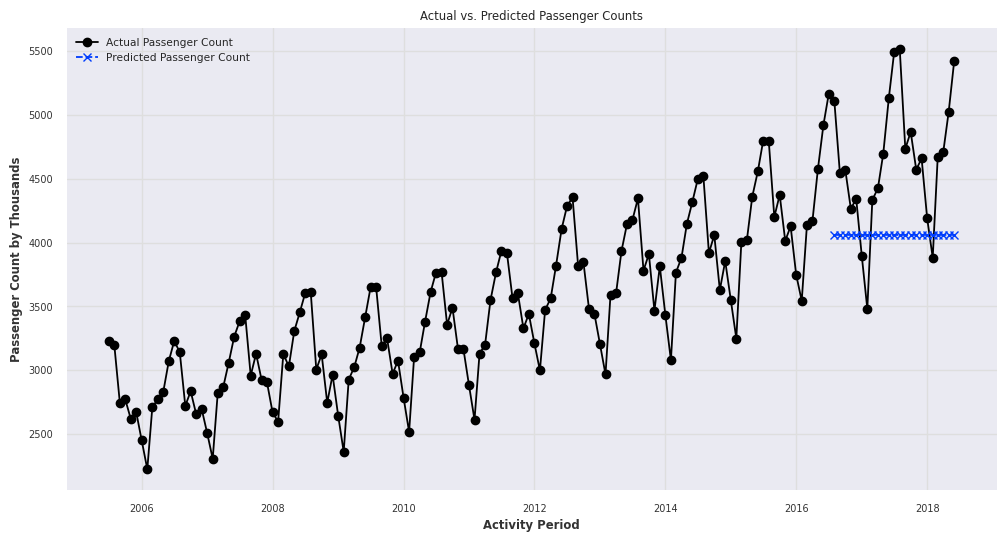

In [ ]:
plot_actual_vs_predicted(transformer_passenger_counts_df, y_test_unscaled, y_pred_nd_transformer_test, SEQ_LENGTH)

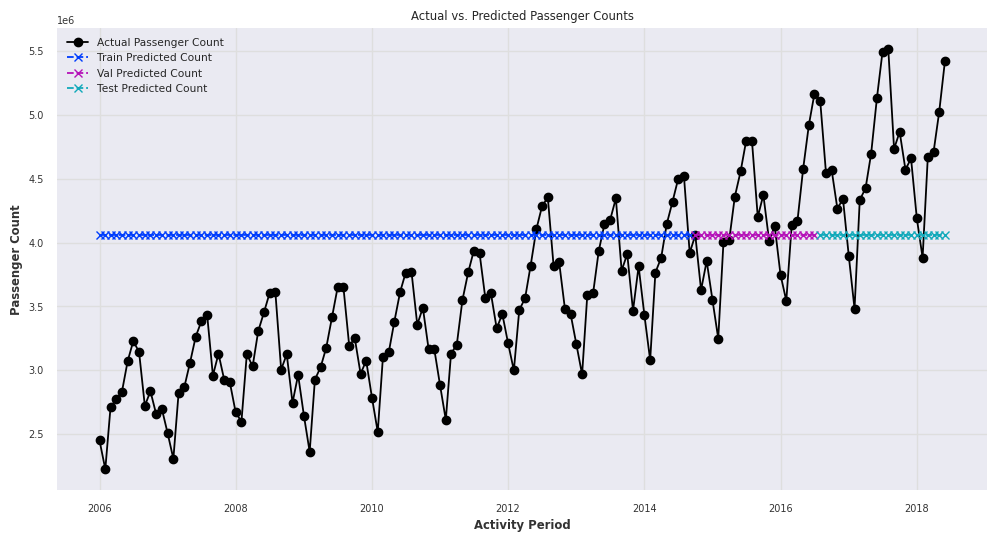

In [ ]:
plot_actual_vs_predicted_range(transformer_passenger_counts_df, y_train_unscaled, y_pred_nd_transformer_train, y_val_unscaled, y_pred_nd_transformer_val, y_test_unscaled, y_pred_nd_transformer_test, SEQ_LENGTH)

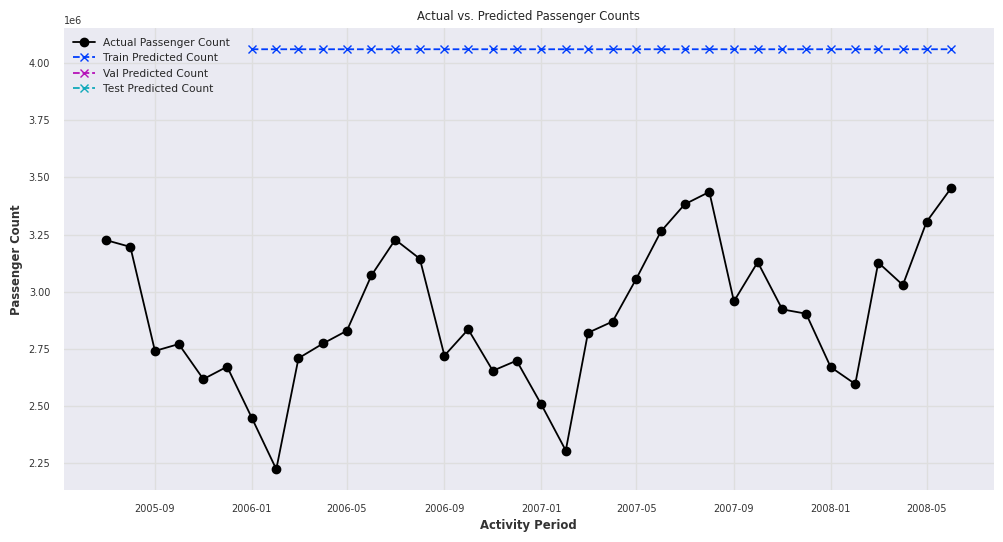

In [ ]:
plot_actual_vs_predicted_range(transformer_passenger_counts_df, y_train_unscaled, y_pred_nd_transformer_train, y_val_unscaled, y_pred_nd_transformer_val, y_test_unscaled, y_pred_nd_transformer_test, SEQ_LENGTH, start_idx=0, end_idx=36)

In [ ]:
# Calculate MSE and R2
y_train_nd_transformer_mse = mse(y_train_unscaled, y_pred_nd_transformer_train)
y_val_nd_transformer_mse = mse(y_val_unscaled, y_pred_nd_transformer_val)
y_test_nd_transformer_mse = mse(y_test_unscaled, y_pred_nd_transformer_test)

print(f'Train MSE: {y_train_nd_transformer_mse}')
print(f'Validation MSE: {y_val_nd_transformer_mse}')
print(f'Test MSE: {y_test_nd_transformer_mse}')

y_train_nd_transformer_r2 = r2(y_train_unscaled, y_pred_nd_transformer_train)
y_val_nd_transformer_r2 = r2(y_val_unscaled, y_pred_nd_transformer_val)
y_test_nd_transformer_r2 = r2(y_test_unscaled, y_pred_nd_transformer_test)

print(f'Train R^2: {y_train_nd_transformer_r2}')
print(f'Validation R^2: {y_val_nd_transformer_r2}')
print(f'Test R^2: {y_test_nd_transformer_r2}')

Train MSE: 811914720582.4504
Validation MSE: 242026394195.458
Test MSE: 583151843623.658
Train R^2: -2.0880818041308746
Validation R^2: -0.05805090119883172
Test R^2: -1.288160925793866


## Compare Transformer Performances

In [ ]:
# Compare Test MSE and R2 to Determine Best Performing Transformer
def compare_transformers(y_test_original_transformer_mse, y_test_original_transformer_r2, y_test_nd_transformer_mse, y_test_nd_transformer_r2):
    # Determine the best model based on MSE
    if y_test_original_transformer_mse < y_test_nd_transformer_mse:
        best_mse_model = "Original Transformer"
        best_mse = y_test_original_transformer_mse
    else:
        best_mse_model = "Transformer without Dropout"
        best_mse = y_test_nd_transformer_mse

    # Determine the best model based on R²
    if y_test_original_transformer_r2 > y_test_nd_transformer_r2:
        best_r2_model = "Original Transformer"
        best_r2 = y_test_original_transformer_r2
    else:
        best_r2_model = "Transformer without Dropout"
        best_r2 = y_test_nd_transformer_r2

    # Print the results
    print(f"Best Model based on MSE:\nModel: {best_mse_model}, MSE: {best_mse}\n")
    print(f"Best Model based on R²:\nModel: {best_r2_model}, R²: {best_r2}\n")

In [ ]:
compare_transformers(test_pred_mse, test_pred_r2, y_test_nd_transformer_mse, y_test_nd_transformer_r2)

Best Model based on MSE:
Model: Original Transformer, MSE: 166788646567.2442

Best Model based on R²:
Model: Original Transformer, R²: 0.34555764829664926



The results indicate that the Transformer with Dropout is the best performer



## LSTM Model
### Train Test Split

In [ ]:
passenger_counts = air_passenger_df.groupby('Activity Period')['Passenger Count'].sum()

# Normalize the data
scaler = MinMaxScaler()
passenger_counts_scaled = scaler.fit_transform(passenger_counts.values.reshape(-1, 1))

In [ ]:
# Create Passenger Count DF, with Passenger Count Column
passenger_counts_df = air_passenger_df[['Activity Period', 'Passenger Count']]

# Group by Activity Period
passenger_counts_df = passenger_counts_df.groupby('Activity Period')['Passenger Count'].sum().reset_index()

passenger_counts_df.head()

Activity Period  Passenger Count
0      2005-07-01          3225769
1      2005-08-01          3195866
2      2005-09-01          2740553
3      2005-10-01          2770715
4      2005-11-01          2617333

In [ ]:
# Define sequence length
SEQ_LENGTH = 6

# Create sequences
X, y = create_sequences(passenger_counts_scaled, SEQ_LENGTH)

In [ ]:
X[-1]

array([[0.74001772],
       [0.59728436],
       [0.50371925],
       [0.74412573],
       [0.75601104],
       [0.85085917]])

In [ ]:
y[-1]

array([0.97276925])

In [ ]:
# Split the data into training and remaining (validation + test) sets
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, shuffle=False)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, shuffle=False)


### Baseline Model

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=5, input_shape=(SEQ_LENGTH, 1), return_sequences=True))
lstm_model.add(Dropout(0.2))
# add second LSTM layer
lstm_model.add(LSTM(
          units=3,
          return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# Summary of the model
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 5)              140       
                                                                 
 dropout (Dropout)           (None, 6, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 252 (1008.00 Byte)
Trainable params: 252 (1008.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,             # Set a high number of epochs; early stopping will handle the termination
    batch_size=2,
    callbacks=[early_stopping]
)

Epoch 1/50
53/53 [==============================] - 7s 45ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 2/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.1106 - val_mse: 0.1106
Epoch 3/50
53/53 [==============================] - 1s 12ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 4/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 5/50
53/53 [==============================] - 1s 15ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0469 - val_mse: 0.0469
Epoch 6/50
53/53 [==============================] - 0s 9ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 7/50
53/53 [==============================] - 1s 9ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 8/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0131 - mse:

In [ ]:
# Evaluate the model
loss = lstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 2s 2s/step - loss: 0.0505 - mse: 0.0505
Test Loss: [0.05045512318611145, 0.05045512318611145]


In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation loss over epochs.

    Args:
    history: A history object returned by the `fit` method of a Keras model.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

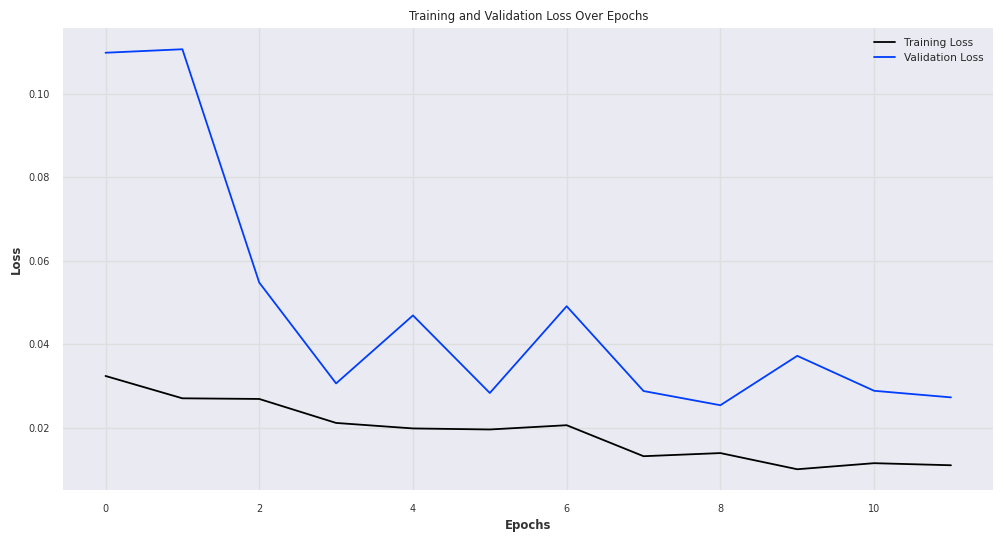

In [ ]:
plot_training_history(lstm_history)

#### Metric Evaluation

1/1 [==============================] - 0s 23ms/step


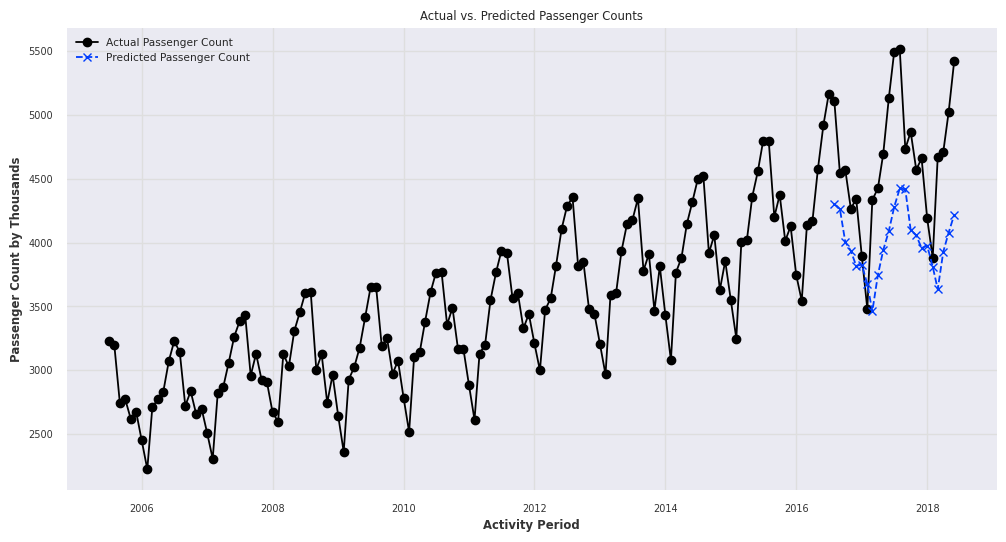

In [ ]:
# Make predictions
y_train_pred_lstm = lstm_model.predict(X_train)
y_val_pred_lstm = lstm_model.predict(X_val)
y_test_pred_lstm = lstm_model.predict(X_test)

# Unscale Predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm)
y_val_pred_lstm = scaler.inverse_transform(y_val_pred_lstm)
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm)

plot_actual_vs_predicted(passenger_counts_df, y_test, y_test_pred_lstm, SEQ_LENGTH)


In [ ]:
# Unscale
y_train_unscaled = scaler.inverse_transform(y_train)
y_val_unscaled = scaler.inverse_transform(y_val)
y_test_unscaled = scaler.inverse_transform(y_test)

# Evaluate Model
train_mse_lstm, val_mse_lstm, test_mse_lstm, train_r2_lstm, val_r2_lstm, test_r2_lstm = evaluate_model(y_train_unscaled, y_train_pred_lstm, y_val_unscaled, y_val_pred_lstm, y_test_unscaled, y_test_pred_lstm)

# Print Results
print(f'lstm_model: Train MSE: {train_mse_lstm}, Val MSE: {val_mse_lstm}, Test MSE: {test_mse_lstm}')
print(f'lstm_model: Train R^2: {train_r2_lstm}, Val R^2: {val_r2_lstm}, Test R^2: {test_r2_lstm}')

lstm_model: Train MSE: 106978022795.0607, Val MSE: 274949984421.4119, Test MSE: 547398029075.682
lstm_model: Train R^2: 0.5931138047489244, Val R^2: -0.20198076515384966, Test R^2: -1.1478706603637132


#### LSTM (No Dropouts)


In [ ]:
# Build the LSTM model
lstm_no_drop_model = Sequential()
lstm_no_drop_model.add(LSTM(units=5, input_shape=(SEQ_LENGTH, 1), return_sequences=True))
# add second LSTM layer
lstm_no_drop_model.add(LSTM(
          units=3,
          return_sequences=False))
lstm_no_drop_model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
lstm_no_drop_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# Summary of the model
lstm_no_drop_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6, 5)              140       
                                                                 
 lstm_3 (LSTM)               (None, 3)                 108       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 252 (1008.00 Byte)
Trainable params: 252 (1008.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

lstm_no_drop_history = lstm_no_drop_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,             # Set a high number of epochs; early stopping will handle the termination
    batch_size=2,
    callbacks=[early_stopping]
)

Epoch 1/50
53/53 [==============================] - 7s 31ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.1129 - val_mse: 0.1129
Epoch 2/50
53/53 [==============================] - 0s 8ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 3/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0519 - val_mse: 0.0519
Epoch 4/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 5/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 6/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 7/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 8/50
53/53 [==============================] - 1s 12ms/step - loss: 0.0077 - ms

In [ ]:
# Calculate Loss
loss = lstm_no_drop_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 1s 1s/step - loss: 0.0141 - mse: 0.0141
Test Loss: [0.014067146927118301, 0.014067146927118301]


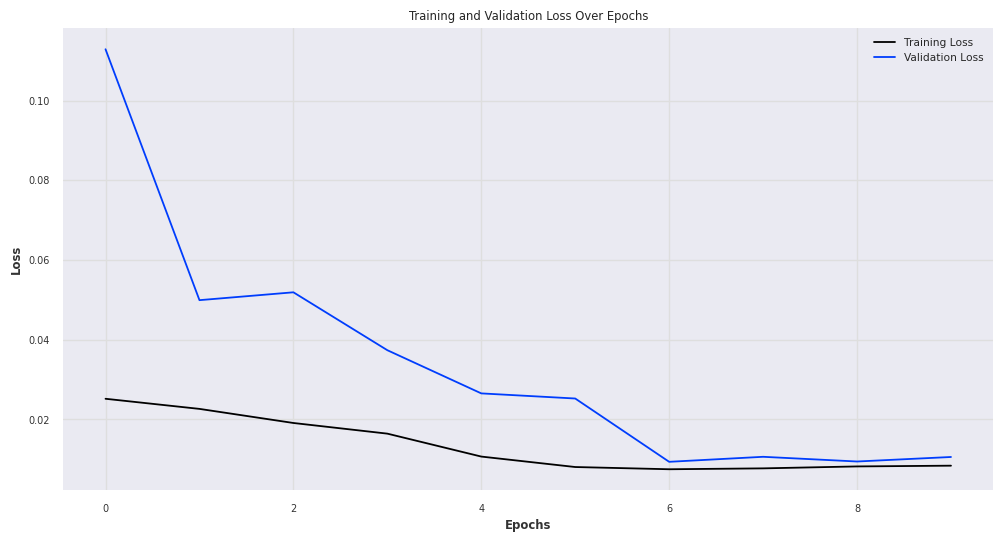

In [ ]:
plot_training_history(lstm_no_drop_history)

#### Evaluate

1/1 [==============================] - 0s 42ms/step


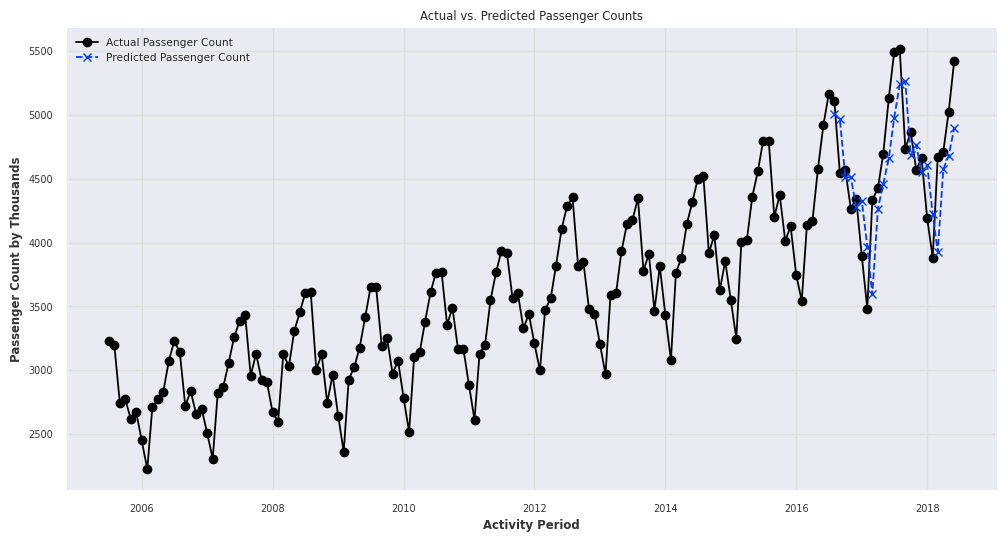

In [ ]:
# Make Predictions
y_train_pred_lstm_no_drop = lstm_no_drop_model.predict(X_train)
y_val_pred_lstm_no_drop = lstm_no_drop_model.predict(X_val)
y_test_pred_lstm_no_drop = lstm_no_drop_model.predict(X_test)

# Unscale
y_train_pred_lstm_no_drop = scaler.inverse_transform(y_train_pred_lstm_no_drop)
y_val_pred_lstm_no_drop = scaler.inverse_transform(y_val_pred_lstm_no_drop)
y_test_pred_lstm_no_drop = scaler.inverse_transform(y_test_pred_lstm_no_drop)

plot_actual_vs_predicted(passenger_counts_df, y_test, y_test_pred_lstm_no_drop, SEQ_LENGTH)

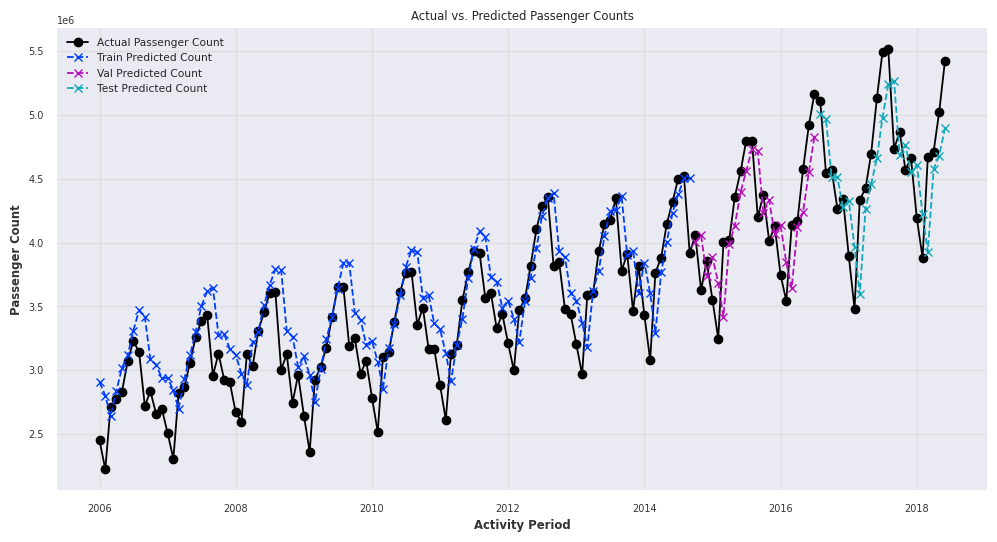

In [ ]:
plot_actual_vs_predicted_range(passenger_counts_df, y_train_unscaled, y_train_pred_lstm_no_drop, y_val_unscaled, y_val_pred_lstm_no_drop, y_test_unscaled, y_test_pred_lstm_no_drop, SEQ_LENGTH)

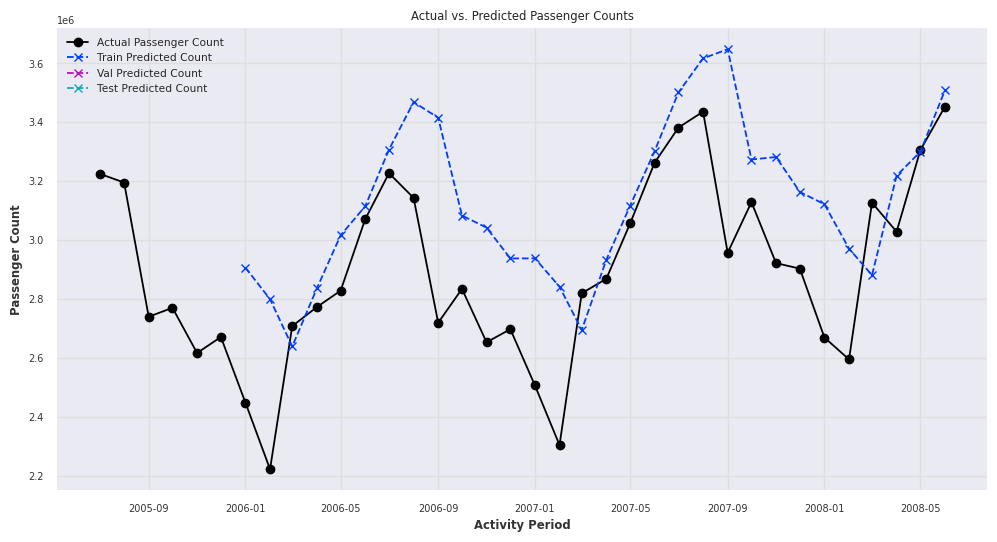

In [ ]:
plot_actual_vs_predicted_range(passenger_counts_df, y_train_unscaled, y_train_pred_lstm_no_drop, y_val_unscaled, y_val_pred_lstm_no_drop, y_test_unscaled, y_test_pred_lstm_no_drop, SEQ_LENGTH, start_idx=0, end_idx=36)

In [ ]:
# Evaluate
train_mse_lstm_no_drop, val_mse_lstm_no_drop, test_mse_lstm_no_drop, train_r2_lstm_no_drop, val_r2_lstm_no_drop, test_r2_lstm_no_drop = evaluate_model(y_train_unscaled, y_train_pred_lstm_no_drop, y_val_unscaled, y_val_pred_lstm_no_drop, y_test_unscaled, y_test_pred_lstm_no_drop)

# Print Results
print(f'lstm_no_drop_model: Train MSE: {train_mse_lstm_no_drop}, Val MSE: {val_mse_lstm_no_drop}, Test MSE: {test_mse_lstm_no_drop}')
print(f'lstm_no_drop_model: Train R^2: {train_r2_lstm_no_drop}, Val R^2: {val_r2_lstm_no_drop}, Test R^2: {test_r2_lstm_no_drop}')

lstm_no_drop_model: Train MSE: 100726272506.15775, Val MSE: 101708336301.68755, Test MSE: 152617401295.39673
lstm_no_drop_model: Train R^2: 0.6168920614623117, Val R^2: 0.5553683549112176, Test R^2: 0.4011625524906367


### LSTM (Smaller Learning Rate)

In [ ]:
# Build the LSTM model
lstm_001_model = Sequential()
lstm_001_model.add(LSTM(units=5, input_shape=(SEQ_LENGTH, 1), return_sequences=True))
lstm_001_model.add(Dropout(0.2))
# add second LSTM layer
lstm_001_model.add(LSTM(
          units=3,
          return_sequences=False))
lstm_001_model.add(Dropout(0.2))
lstm_001_model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
lstm_001_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# Summary of the model
lstm_001_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 6, 5)              140       
                                                                 
 dropout_2 (Dropout)         (None, 6, 5)              0         
                                                                 
 lstm_5 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 252 (1008.00 Byte)
Trainable params: 252 (1008.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_001_model_history = lstm_001_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,             # Set a high number of epochs; early stopping will handle the termination
    batch_size=2,
    callbacks=[early_stopping]
)

Epoch 1/50
53/53 [==============================] - 12s 71ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 2/50
53/53 [==============================] - 1s 20ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 3/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 4/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 5/50
53/53 [==============================] - 1s 16ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 6/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 7/50
53/53 [==============================] - 1s 20ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 8/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0283 - 

In [ ]:
# Loss Check
loss = lstm_001_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 1s 1s/step - loss: 0.0718 - mse: 0.0718
Test Loss: [0.07175708562135696, 0.07175708562135696]


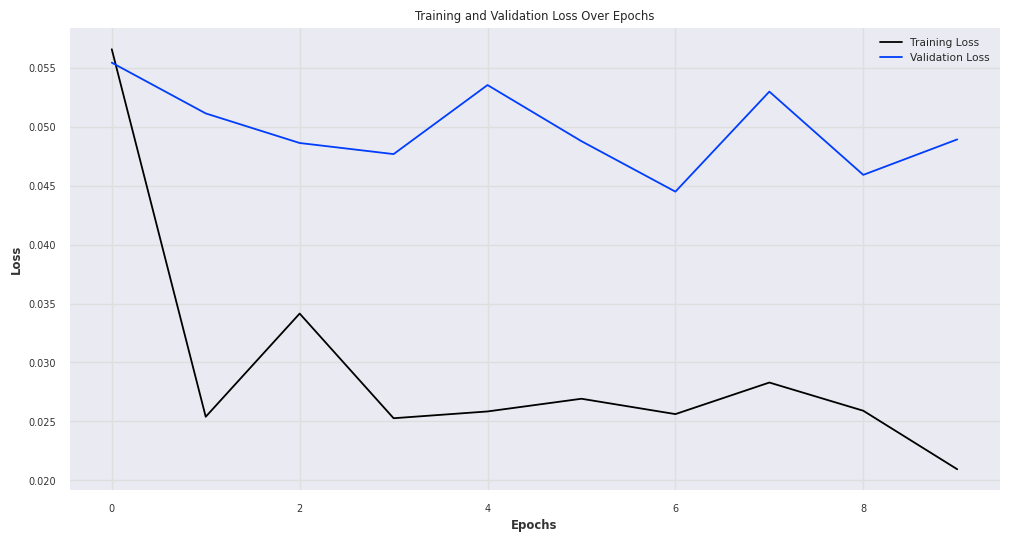

In [ ]:
plot_training_history(lstm_001_model_history)

#### Evaluate

1/1 [==============================] - 0s 26ms/step


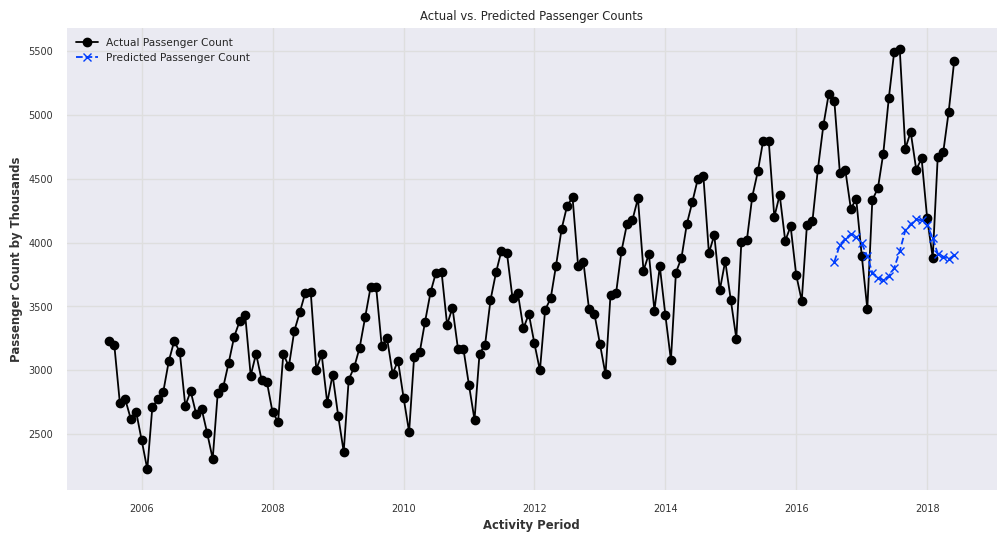

In [ ]:
# Predict
y_train_pred_lstm_001 = lstm_001_model.predict(X_train)
y_val_pred_lstm_001 = lstm_001_model.predict(X_val)
y_test_pred_lstm_001 = lstm_001_model.predict(X_test)

# Unscale
y_train_pred_lstm_001 = scaler.inverse_transform(y_train_pred_lstm_001)
y_val_pred_lstm_001 = scaler.inverse_transform(y_val_pred_lstm_001)
y_test_pred_lstm_001 = scaler.inverse_transform(y_test_pred_lstm_001)

plot_actual_vs_predicted(passenger_counts_df, y_test, y_test_pred_lstm_001, SEQ_LENGTH)


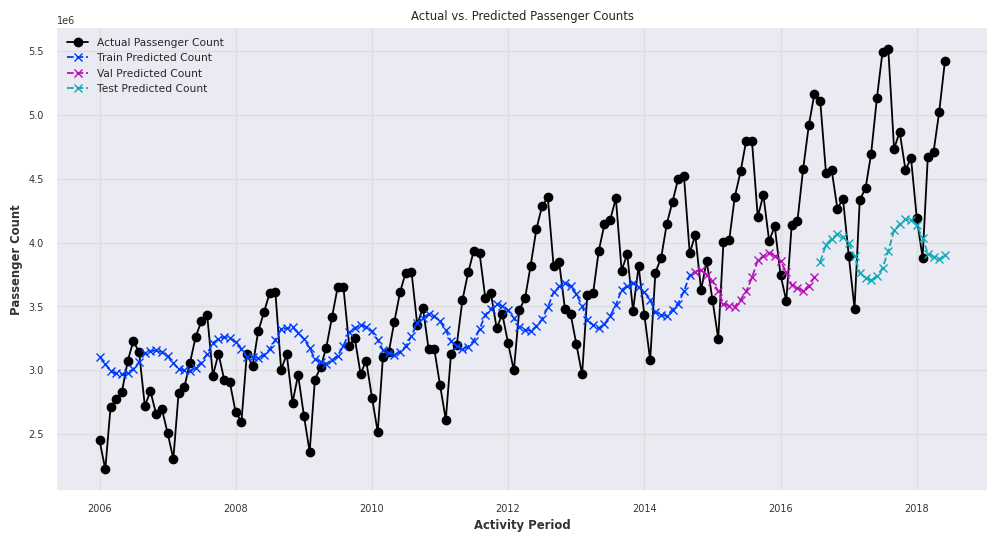

In [ ]:
plot_actual_vs_predicted_range(passenger_counts_df, y_train_unscaled, y_train_pred_lstm_001, y_val_unscaled, y_val_pred_lstm_001, y_test_unscaled, y_test_pred_lstm_001, SEQ_LENGTH)

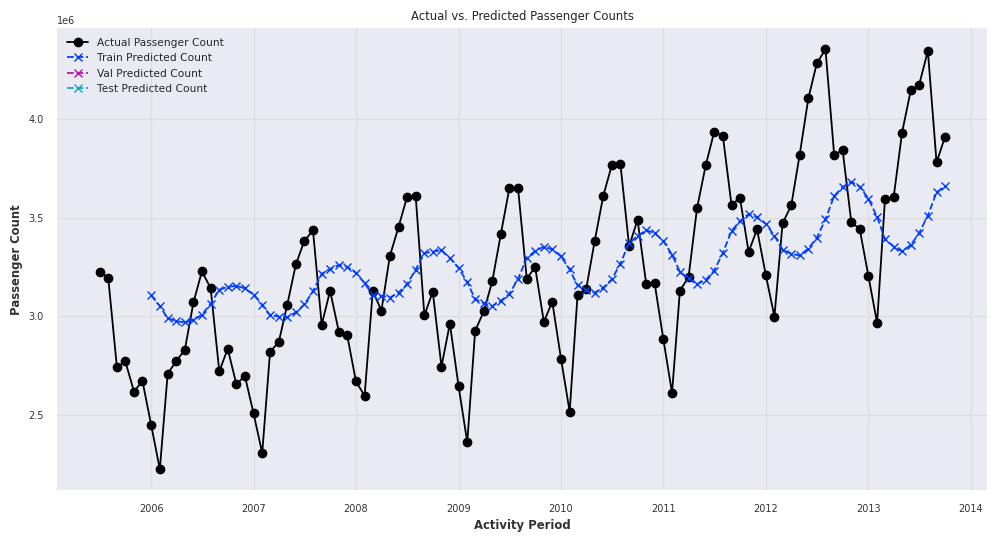

In [ ]:
plot_actual_vs_predicted_range(passenger_counts_df, y_train_unscaled, y_train_pred_lstm_001, y_val_unscaled, y_val_pred_lstm_001, y_test_unscaled, y_test_pred_lstm_001, SEQ_LENGTH, start_idx=0, end_idx=100)

In [ ]:
# Evaluate Model
train_mse_lstm_001, val_mse_lstm_001, test_mse_lstm_001, train_r2_lstm_001, val_r2_lstm_001, test_r2_lstm_001 = evaluate_model(y_train_unscaled, y_train_pred_lstm_001, y_val_unscaled, y_val_pred_lstm_001, y_test_unscaled, y_test_pred_lstm_001)

# Print Results
print(f'lstm_001_model: Train MSE: {train_mse_lstm_001}, Val MSE: {val_mse_lstm_001}, Test MSE: {test_mse_lstm_001}')
print(f'lstm_001_model: Train R^2: {train_r2_lstm_001}, Val R^2: {val_r2_lstm_001}, Test R^2: {test_r2_lstm_001}')

lstm_001_model: Train MSE: 196462658984.20892, Val MSE: 482624219201.13354, Test MSE: 778507195558.1357
lstm_001_model: Train R^2: 0.2527629345315855, Val R^2: -1.109856559904506, Test R^2: -2.0546927014787815


### LSTM (No Drop Out and Smaller Learning Rate)

In [ ]:
# Build the LSTM model
lstm_001_nd_model = Sequential()
lstm_001_nd_model.add(LSTM(units=5, input_shape=(SEQ_LENGTH, 1), return_sequences=True))
# add second LSTM layer
lstm_001_nd_model.add(LSTM(
          units=3,
          return_sequences=False))
lstm_001_nd_model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
lstm_001_nd_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# Summary of the model
lstm_001_nd_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6, 5)              140       
                                                                 
 lstm_7 (LSTM)               (None, 3)                 108       
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 252 (1008.00 Byte)
Trainable params: 252 (1008.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_001_nd_history = lstm_001_nd_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,             # Set a high number of epochs; early stopping will handle the termination
    batch_size=2,
    callbacks=[early_stopping]
)

Epoch 1/50
53/53 [==============================] - 8s 44ms/step - loss: 0.0882 - mse: 0.0882 - val_loss: 0.1301 - val_mse: 0.1301
Epoch 2/50
53/53 [==============================] - 1s 13ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 3/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 4/50
53/53 [==============================] - 0s 9ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0592 - val_mse: 0.0592
Epoch 5/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 6/50
53/53 [==============================] - 0s 9ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0612 - val_mse: 0.0612
Epoch 7/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 8/50
53/53 [==============================] - 0s 9ms/step - loss: 0.0202 - mse:

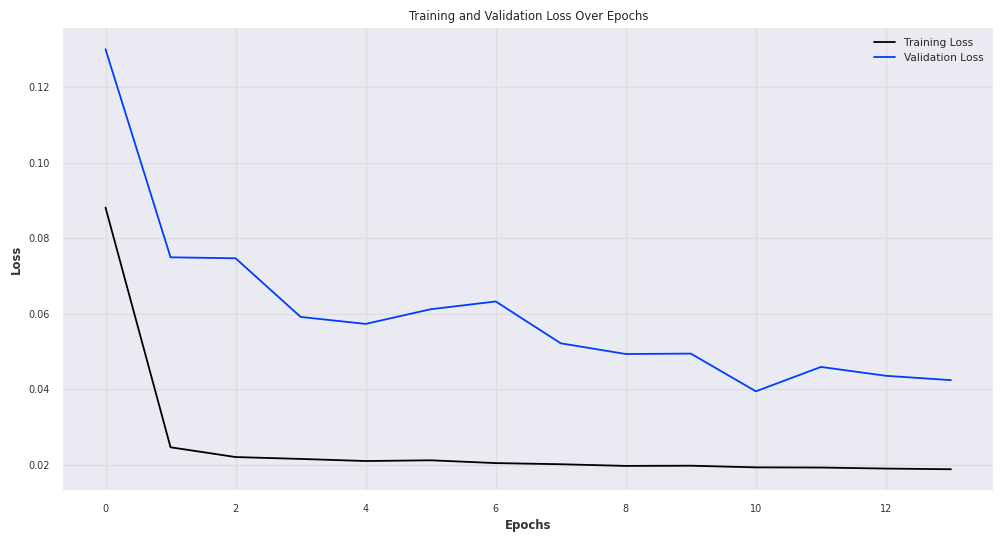

In [ ]:
plot_training_history(lstm_001_nd_history)

In [ ]:
# Get Loss
loss = lstm_001_nd_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 2s 2s/step - loss: 0.0708 - mse: 0.0708
Test Loss: [0.07077894359827042, 0.07077894359827042]


#### Evaluate

1/1 [==============================] - 0s 27ms/step


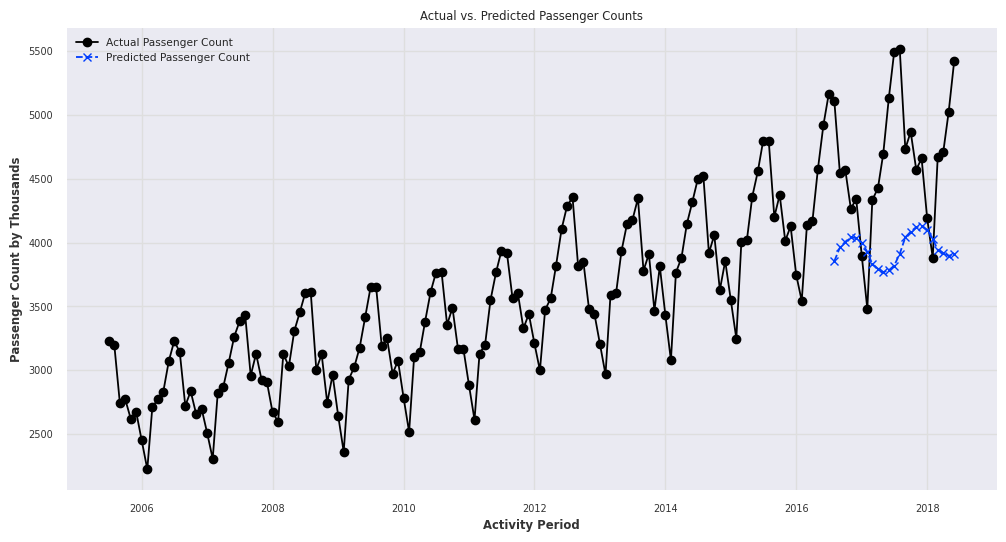

In [ ]:
# Predict
y_train_pred_lstm_001_nd = lstm_001_nd_model.predict(X_train)
y_val_pred_lstm_001_nd = lstm_001_nd_model.predict(X_val)
y_test_pred_lstm_001_nd = lstm_001_nd_model.predict(X_test)

# Unscale
y_train_pred_lstm_001_nd = scaler.inverse_transform(y_train_pred_lstm_001_nd)
y_val_pred_lstm_001_nd = scaler.inverse_transform(y_val_pred_lstm_001_nd)
y_test_pred_lstm_001_nd = scaler.inverse_transform(y_test_pred_lstm_001_nd)

plot_actual_vs_predicted(passenger_counts_df, y_test, y_test_pred_lstm_001_nd, SEQ_LENGTH)

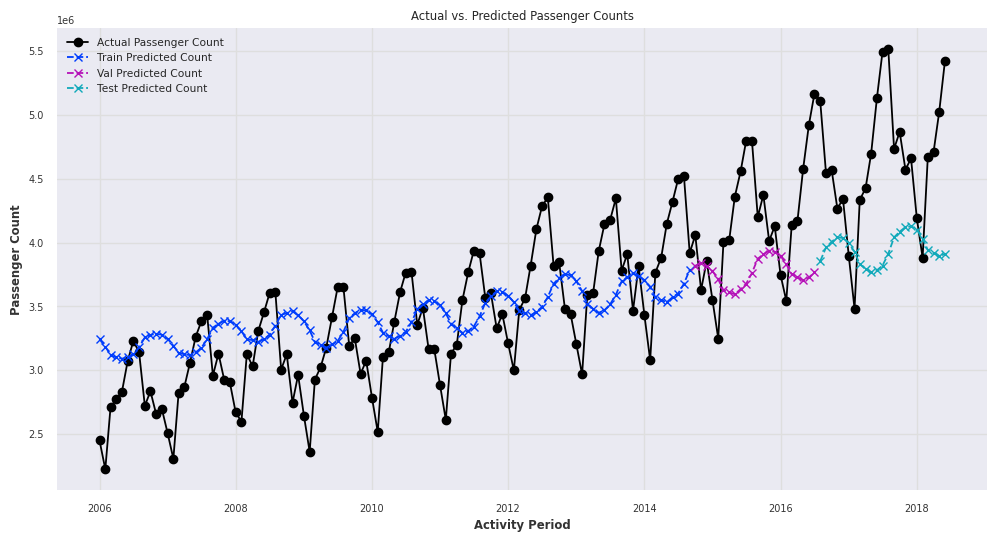

In [ ]:
plot_actual_vs_predicted_range(passenger_counts_df, y_train_unscaled, y_train_pred_lstm_001_nd, y_val_unscaled, y_val_pred_lstm_001_nd, y_test_unscaled, y_test_pred_lstm_001_nd, SEQ_LENGTH)

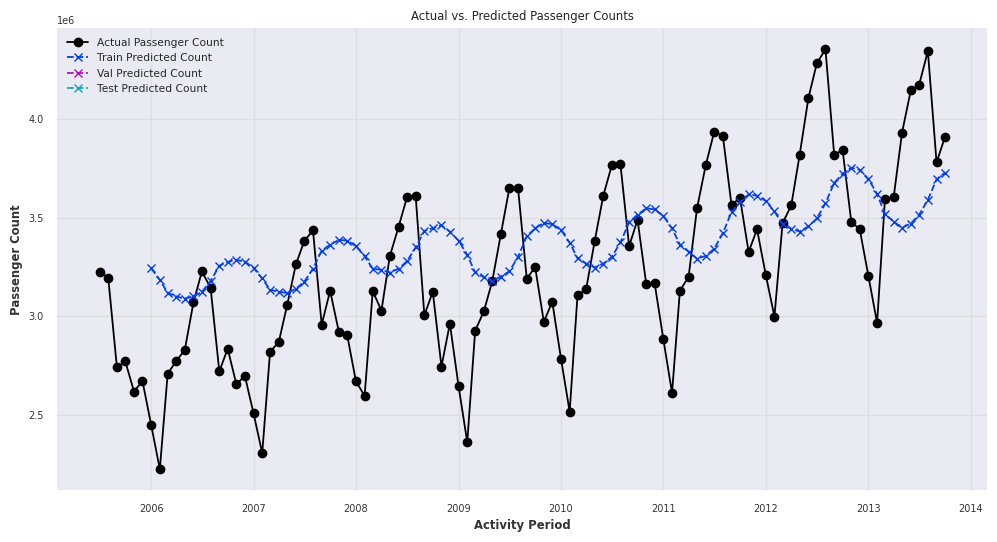

In [ ]:
plot_actual_vs_predicted_range(passenger_counts_df, y_train_unscaled, y_train_pred_lstm_001_nd, y_val_unscaled, y_val_pred_lstm_001_nd, y_test_unscaled, y_test_pred_lstm_001_nd, SEQ_LENGTH, start_idx=0, end_idx=100)

In [ ]:
# Evaluate Model
train_mse_lstm_001_nd, val_mse_lstm_001_nd, test_mse_lstm_001_nd, train_r2_lstm_001_nd, val_r2_lstm_001_nd, test_r2_lstm_001_nd = evaluate_model(y_train_unscaled, y_train_pred_lstm_001_nd, y_val_unscaled, y_val_pred_lstm_001_nd, y_test_unscaled, y_test_pred_lstm_001_nd)

# Print Results
print(f'lstm_001_nd_model: Train MSE: {train_mse_lstm_001_nd}, Val MSE: {val_mse_lstm_001_nd}, Test MSE: {test_mse_lstm_001_nd}')
print(f'lstm_001_nd_model: Train R^2: {train_r2_lstm_001_nd}, Val R^2: {val_r2_lstm_001_nd}, Test R^2: {test_r2_lstm_001_nd}')

lstm_001_nd_model: Train MSE: 211878592467.03156, Val MSE: 428358824325.3494, Test MSE: 767895233566.1112
lstm_001_nd_model: Train R^2: 0.19412911089955098, Val R^2: -0.872628101821745, Test R^2: -2.013053673566949


### Evaluation Across LSTMs

In [ ]:
def evaluate_lstm_models(metrics):
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_mse_model = ""
    best_r2_model = ""

    for model, scores in metrics.items():
        mse, r2 = scores['mse'], scores['r2']
        if mse < best_mse:
            best_mse = mse
            best_mse_model = model
        if r2 > best_r2:
            best_r2 = r2
            best_r2_model = model

    print(f"Best MSE Model: {best_mse_model}")
    print(f"Best R^2 Model: {best_r2_model}")

In [ ]:
metrics = {
    "Original LSTM": {"mse": test_mse_lstm, "r2": test_r2_lstm},
    "LSTM without Drop Layers": {"mse": test_mse_lstm_no_drop, "r2": test_r2_lstm_no_drop},
    "LSTM with Smaller Learning Rate": {"mse": test_mse_lstm_001, "r2": test_r2_lstm_001},
    "LSTM without Drop Layers and Smaller Learning Rate": {"mse": test_mse_lstm_001_nd, "r2": test_r2_lstm_001_nd}
}

evaluate_lstm_models(metrics)

Best MSE Model: LSTM without Drop Layers
Best R^2 Model: LSTM without Drop Layers


Given that both the best MSE and R² scores were achieved by the "LSTM without Drop Layers" model, it seems likely that the characteristics of our dataset influenced this outcome. With only 156 entries, our dataset is relatively small for training deep learning models. In such cases, Dropout layers might lead to an excessive reduction in the model's capacity, impairing its ability to learn from the data effectively. Additionally, the data exhibits both trend and seasonal patterns, which LSTM models are well-suited to capture due to their ability to retain long-term dependencies. However, Dropout can disrupt this ability by randomly setting some neurons to zero during training, potentially hindering the model's learning of these patterns. Typically, Dropout is used to prevent overfitting in larger datasets by introducing noise during training, but in our case, this noise might be preventing the model from learning effectively. By removing Dropout, the LSTM can utilize all available information to fit the data better, as reflected in the improved MSE and R² scores. When we reduced the learning rate, the model performed poorly even without Dropout layers, suggesting that while fine-tuning the learning rate is important, maintaining an optimal balance is crucial for effective learning. This indicates that the model benefits more from having access to all the information without the regularization effect of Dropout and with an appropriately tuned learning rate

## Pretrained Algorithms
### Facebook's Prophet

In [ ]:
passenger_counts_prophet_df = passenger_counts_df.copy()
passenger_counts_prophet_df.columns = ['ds', 'y']
passenger_counts_prophet_df.head()

ds        y
0 2005-07-01  3225769
1 2005-08-01  3195866
2 2005-09-01  2740553
3 2005-10-01  2770715
4 2005-11-01  2617333

In [ ]:
train_prophet_df = passenger_counts_prophet_df.iloc[:-len(y_test)]
test_prophet_df = passenger_counts_prophet_df.iloc[-len(y_test):]

train_prophet_df.head()

ds        y
0 2005-07-01  3225769
1 2005-08-01  3195866
2 2005-09-01  2740553
3 2005-10-01  2770715
4 2005-11-01  2617333

In [ ]:
# Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6gkaavux/3y49rem4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6gkaavux/chc8b868.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90531', 'data', 'file=/tmp/tmp6gkaavux/3y49rem4.json', 'init=/tmp/tmp6gkaavux/chc8b868.json', 'output', 'file=/tmp/tmp6gkaavux/prophet_modelaipq3knw/prophet_model-20240726034903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Evaluate

In [ ]:
# Define a Period to Make a Prediction
future_dates = pd.date_range(
    end=passenger_counts_prophet_df['ds'].max(),
    periods=SEQ_LENGTH,
    freq='M'
)

future_dates_df = pd.DataFrame({'ds': future_dates})
future_dates_df.head()

ds
0 2017-12-31
1 2018-01-31
2 2018-02-28
3 2018-03-31
4 2018-04-30

In [ ]:
forecast = prophet_model.predict(future_dates_df)
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2017-12-31  4.713032e+06  4.111835e+06  4.336263e+06  4.713032e+06   
1 2018-01-31  4.730600e+06  4.012486e+06  4.238896e+06  4.730445e+06   
2 2018-02-28  4.746469e+06  4.377783e+06  4.593439e+06  4.746027e+06   
3 2018-03-31  4.764038e+06  4.576607e+06  4.801767e+06  4.763104e+06   
4 2018-04-30  4.781040e+06  4.838076e+06  5.063173e+06  4.779542e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  4.713049e+06  -486735.370520        -486735.370520        -486735.370520   
1  4.730837e+06  -602648.526588        -602648.526588        -602648.526588   
2  4.747071e+06  -258422.404902        -258422.404902        -258422.404902   
3  4.765065e+06   -77398.118192         -77398.118192         -77398.118192   
4  4.782585e+06   171595.743922         171595.743922         171595.743922   

          yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0 -486735.370520 -486735.370520 -486735.370520                   0.0   
1 -602648.526588 -602648.526588 -602648.526588                   0.0   
2 -258422.404902 -258422.404902 -258422.404902                   0.0   
3  -77398.118192  -77398.118192  -77398.118192                   0.0   
4  171595.743922  171595.743922  171595.743922                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  4.226296e+06  
1                         0.0                         0.0  4.127952e+06  
2                         0.0                         0.0  4.488047e+06  
3                         0.0                         0.0  4.686640e+06  
4                         0.0                         0.0  4.952636e+06

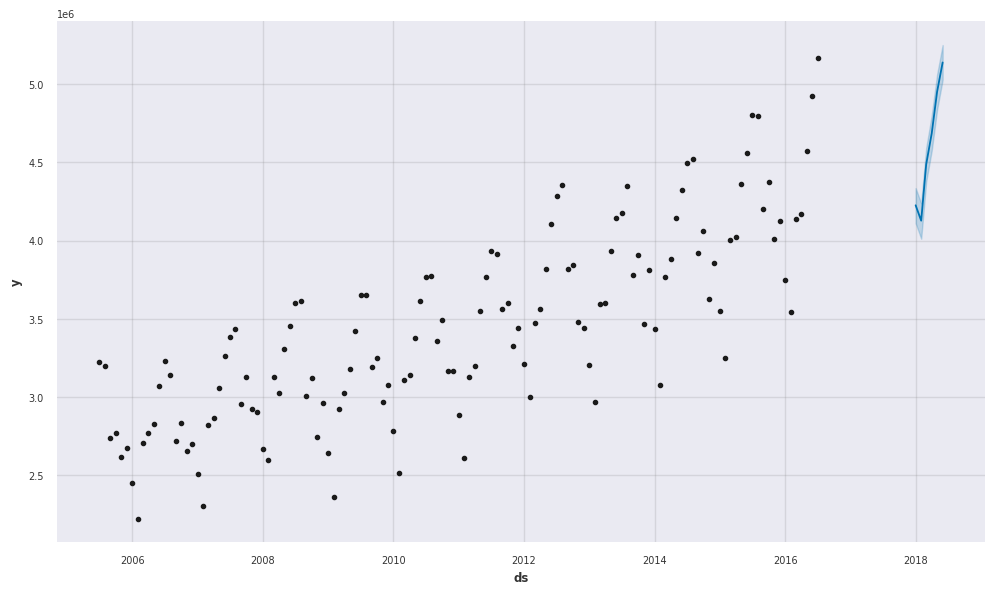

In [ ]:
# Plot
fig = prophet_model.plot(forecast)
plt.show()

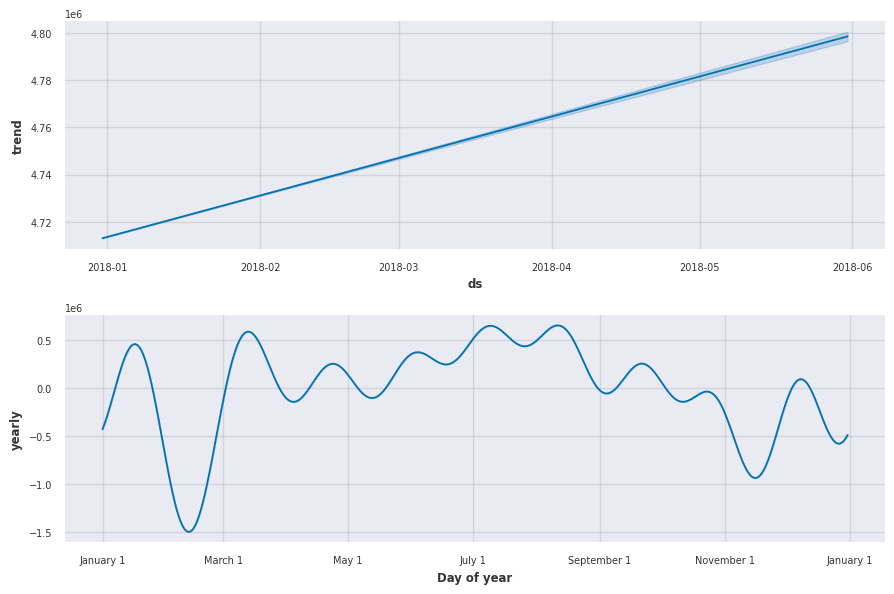

In [ ]:
# Plot Components
fig = prophet_model.plot_components(forecast)
plt.show()

#### Evaluate with Unseen Data

In [ ]:
# Forecast y_test dates
y_test_dates = pd.DataFrame()
y_test_dates['ds'] = test_prophet_df['ds']
forecast_y_test = prophet_model.predict(y_test_dates)

# Get y_test dates
y_test_prophet = test_prophet_df['y'].values
y_test_prophet

array([5110638, 4543759, 4571997, 4266481, 4343369, 3897685, 3481405,
       4335287, 4425920, 4698067, 5134110, 5496516, 5516837, 4736005,
       4868674, 4572702, 4660504, 4190367, 3882181, 4674035, 4713183,
       5025595, 5427144])

In [ ]:
y_test_pred_prophet = forecast_y_test['yhat'].values
y_test_pred_prophet

array([4921705.23480812, 4411387.78034826, 4514371.68605556,
       4201943.76294673, 4359379.96727017, 4079673.82636164,
       3775987.20255305, 4418759.70688406, 4450102.24329449,
       4713289.41334791, 4951482.66743145, 5124601.72577775,
       5123947.37153429, 4622972.78307248, 4729155.46002029,
       4421680.33249287, 4550886.49533943, 4273548.10059575,
       4011670.58248609, 4598710.29350188, 4662267.07407761,
       4927008.45938069, 5155195.50762687])

In [ ]:
# Calculate MSE and R2
y_test_mse_prophet = mse(y_test_prophet, y_test_pred_prophet)
y_test_r2_prophet = r2(y_test_prophet, y_test_pred_prophet)

y_train_mse_prophet = mse(train_prophet_df['y'], prophet_model.predict(train_prophet_df)['yhat'])
y_train_r2_prophet = r2(train_prophet_df['y'], prophet_model.predict(train_prophet_df)['yhat'])

print(f"Prophet MSE: {y_test_mse_prophet}")
print(f"Prophet R2: {y_test_r2_prophet}")

Prophet MSE: 30320490017.209713
Prophet R2: 0.8810290000024614


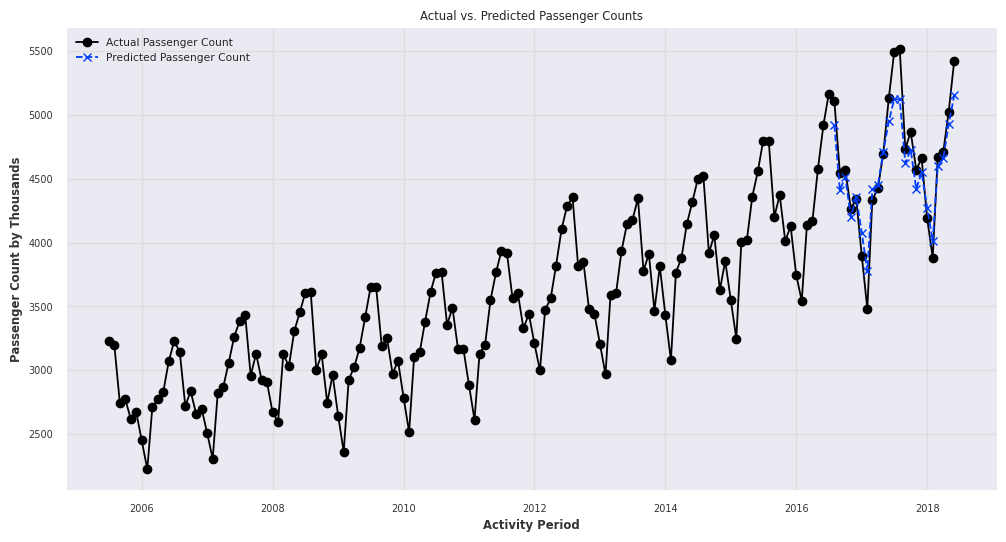

In [ ]:
plot_actual_vs_predicted(passenger_counts_df, y_test, y_test_pred_prophet, SEQ_LENGTH)

## Statistical Model
### Baseline SARIMAX

#### Train Test Split

In [ ]:
train_sairmax_df = passenger_counts_df.iloc[:-len(y_test)]
test_sairmax_df = passenger_counts_df.iloc[-len(y_test):]

train_sairmax_df.head()

Activity Period  Passenger Count
0      2005-07-01          3225769
1      2005-08-01          3195866
2      2005-09-01          2740553
3      2005-10-01          2770715
4      2005-11-01          2617333

#### Model Implementation

In [ ]:
# Baseline SARIMAX Model
sairmax_model = SARIMAX(train_sairmax_df['Passenger Count'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sairmax_model_fit = sairmax_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Evaluate Model

In [ ]:
# Forecast on Test Data
y_test_pred_sairmax = sairmax_model_fit.predict(start=test_sairmax_df.index[0], end=test_sairmax_df.index[-1], dynamic=False)
y_train_pred_sairmax = sairmax_model_fit.predict(start=train_sairmax_df.index[0], end=train_sairmax_df.index[-1])

# Loss
mse_sairmax = mse(test_sairmax_df['Passenger Count'], y_test_pred_sairmax)
r2_sairmax = r2(test_sairmax_df['Passenger Count'], y_test_pred_sairmax)

y_train_sarimax_mse = mse(train_sairmax_df['Passenger Count'], y_train_pred_sairmax)
y_train_sarimax_r2 = r2(train_sairmax_df['Passenger Count'], y_train_pred_sairmax)

print(f"MSE: {mse_sairmax}")
print(f"R2: {r2_sairmax}")

MSE: 47632509654.153404
R2: 0.8131004049495719


In [ ]:
y_test_pred_sairmax

133    5.169123e+06
134    4.581207e+06
135    4.747867e+06
136    4.386729e+06
137    4.505779e+06
138    4.133537e+06
139    3.922608e+06
140    4.519092e+06
141    4.555279e+06
142    4.946132e+06
143    5.281217e+06
144    5.523621e+06
145    5.527069e+06
146    4.943725e+06
147    5.106224e+06
148    4.744962e+06
149    4.866389e+06
150    4.499302e+06
151    4.284618e+06
152    4.882627e+06
153    4.919658e+06
154    5.303900e+06
155    5.630872e+06
Name: predicted_mean, dtype: float64

In [ ]:
# Function to Plot All Actuals with Predicted Test
def plot_actual_vs_predicted_sarimax(train_sairmax_df, test_sairmax_df, y_test_pred_sairmax):
  # Concatenate Actual Train and Test
  actual_train_test = pd.concat([train_sairmax_df, test_sairmax_df])
  plt.figure(figsize=(12, 6))

  # Plot Actual
  plt.plot(actual_train_test.index, actual_train_test['Passenger Count'] / 1000, label='Actual')

  # Plot Pred Test, Starts after Train DF Index
  plt.plot(test_sairmax_df.index, y_test_pred_sairmax / 1000, marker='x', color='red', label='Test Pred')

  plt.xlabel('Activity Period')
  plt.ylabel('Passenger Count by Thousand')
  plt.title('Actual vs Predicted')
  plt.legend()
  plt.show()

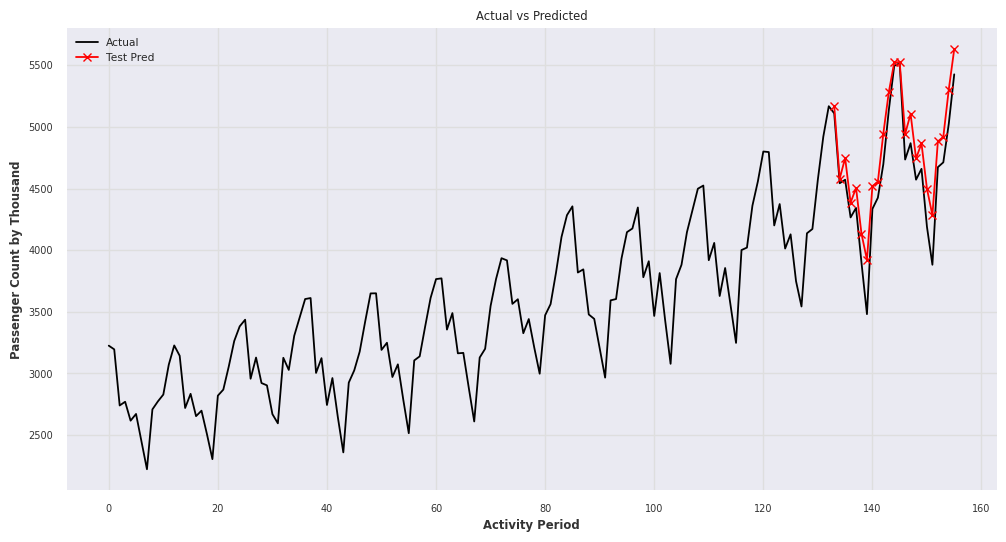

In [ ]:
plot_actual_vs_predicted_sarimax(train_sairmax_df, test_sairmax_df, y_test_pred_sairmax)

In [ ]:
# Create Function to Plot Actual Train and Test, Against Predicted Train and Test
def plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sairmax, test_sairmax_df, y_test_pred_sairmax, start=0, end=-1):
  # Concatenate Actual Train and Test
  actual_train_test = pd.concat([train_sairmax_df, test_sairmax_df])

  plt.figure(figsize=(12, 6))

  # Plot Actual with Range
  plt.plot(actual_train_test.index[start:end], actual_train_test['Passenger Count'][start:end] / 1000, label='Actual')

  # Plot Train Pred with Different Marker and Color with Range
  plt.plot(train_sairmax_df.index[start:end], y_train_pred_sairmax[start:end] / 1000, marker='x', color='orange', linestyle='--', label='Train Pred')

  # Plot Test Pred, Index Will Start After Train Pred with Range, Test Might not be in Range
  if end > len(train_sairmax_df) + len(test_sairmax_df) or end == -1:
    plt.plot(test_sairmax_df.index[start:end], y_test_pred_sairmax[start:end] / 1000, marker='x', color='red', linestyle='--', label='Test Pred')

  plt.xlabel('Activity Period')
  plt.ylabel('Passenger Count by Thousand')
  plt.title('Actual vs Predicted')
  plt.legend()
  plt.show()


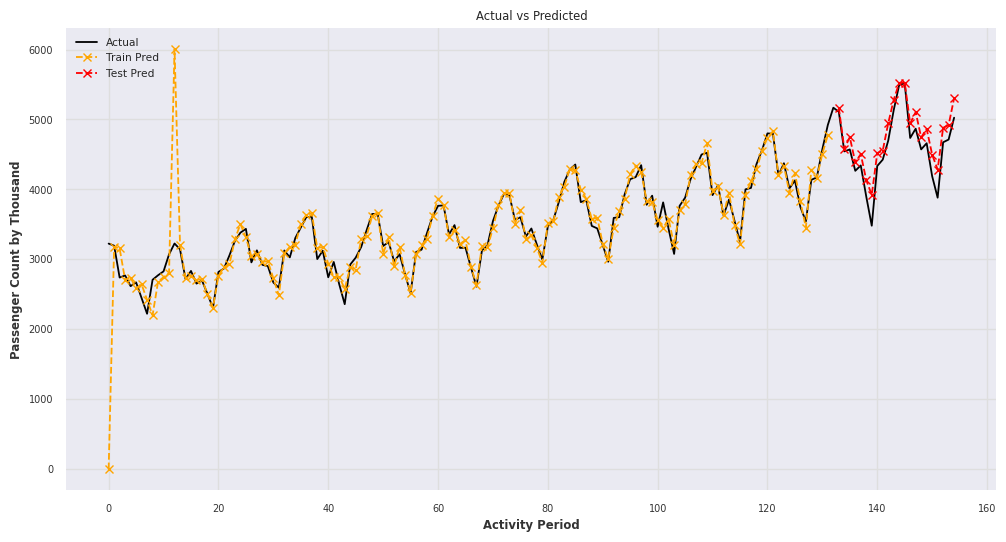

In [ ]:
plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sairmax, test_sairmax_df, y_test_pred_sairmax)

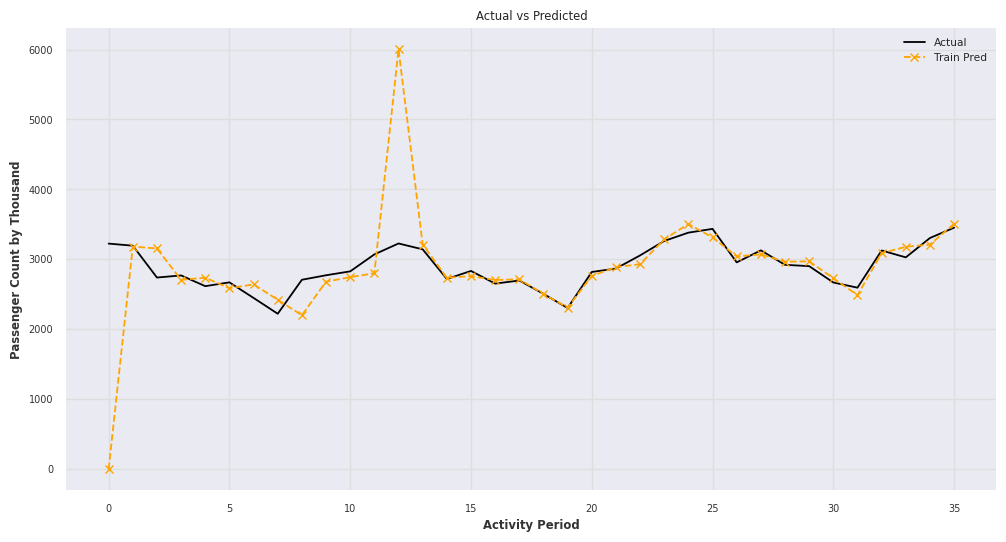

In [ ]:
plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sairmax, test_sairmax_df, y_test_pred_sairmax, start=0, end=36)

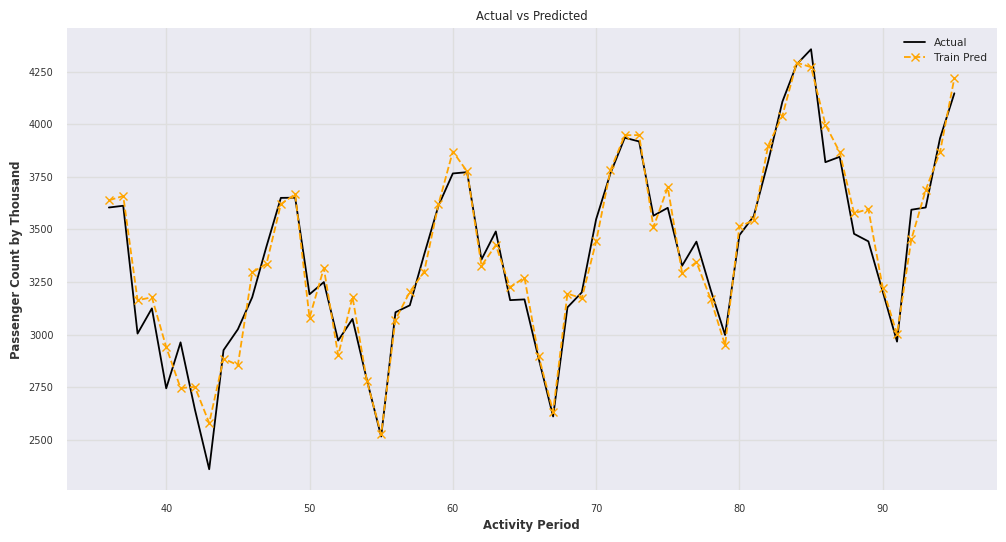

In [ ]:
plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sairmax, test_sairmax_df, y_test_pred_sairmax, start=36, end=96)

### SAIRMAX with Season Variable

In [ ]:
# Add Seasons to Train DF and Test DF
train_sairmax_df['Season'] = train_sairmax_df['Activity Period'].dt.month.apply(get_season)
test_sairmax_df['Season'] = test_sairmax_df['Activity Period'].dt.month.apply(get_season)

train_sairmax_df.head()

Activity Period  Passenger Count  Season
0      2005-07-01          3225769  Summer
1      2005-08-01          3195866  Summer
2      2005-09-01          2740553    Fall
3      2005-10-01          2770715    Fall
4      2005-11-01          2617333    Fall

In [ ]:
# Encode Season with Dict
season_dict = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
train_sairmax_df['Season'] = train_sairmax_df['Season'].map(season_dict)
test_sairmax_df['Season'] = test_sairmax_df['Season'].map(season_dict)

train_sairmax_df.head()


Activity Period  Passenger Count  Season
0      2005-07-01          3225769       3
1      2005-08-01          3195866       3
2      2005-09-01          2740553       4
3      2005-10-01          2770715       4
4      2005-11-01          2617333       4

#### Create Model

In [ ]:
sarimax_season_model = SARIMAX(train_sairmax_df['Passenger Count'], exog=train_sairmax_df['Season'] ,order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_season_model_fit = sarimax_season_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Evaluation

In [ ]:
y_test_pred_sarimax_season =  sarimax_season_model_fit.predict(start=test_sairmax_df.index[0], end=test_sairmax_df.index[-1], exog=test_sairmax_df['Season'], dynamic=False)
y_train_pred_sarimax_season = sarimax_season_model_fit.predict(start=train_sairmax_df.index[0], end=train_sairmax_df.index[-1], exog=train_sairmax_df['Season'])

# Loss
mse_sarimax_season = mse(test_sairmax_df['Passenger Count'], y_test_pred_sarimax_season)
r2_sarimax_season = r2(test_sairmax_df['Passenger Count'], y_test_pred_sarimax_season)

y_train_sarimax_season = mse(train_sairmax_df['Passenger Count'], y_train_pred_sarimax_season)
y_train_r2_sarimax_season = r2(train_sairmax_df['Passenger Count'], y_train_pred_sarimax_season)

print(f"MSE: {mse_sarimax_season}")
print(f"R2: {r2_sarimax_season}")

MSE: 47625352840.57075
R2: 0.8131284867275459


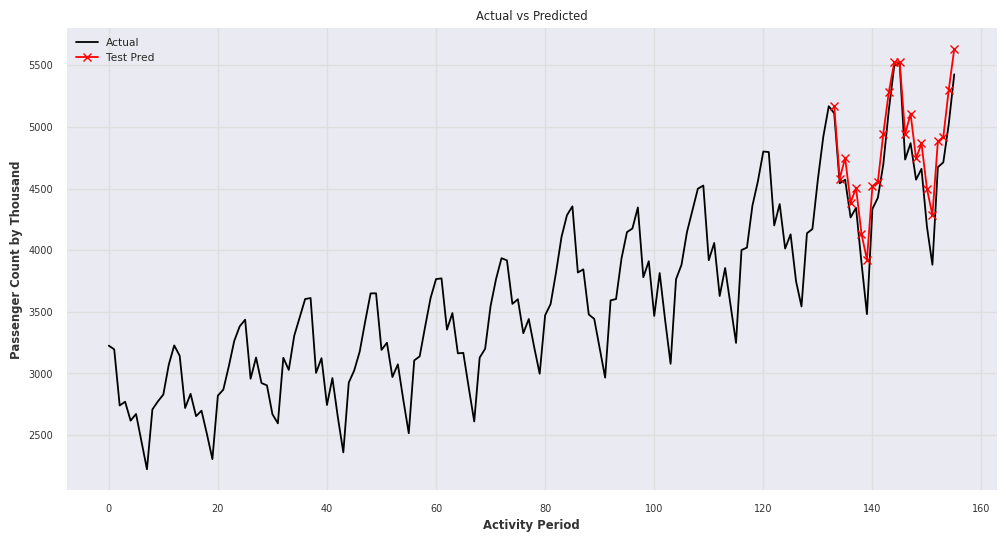

In [ ]:
plot_actual_vs_predicted_sarimax(train_sairmax_df, test_sairmax_df, y_test_pred_sarimax_season)

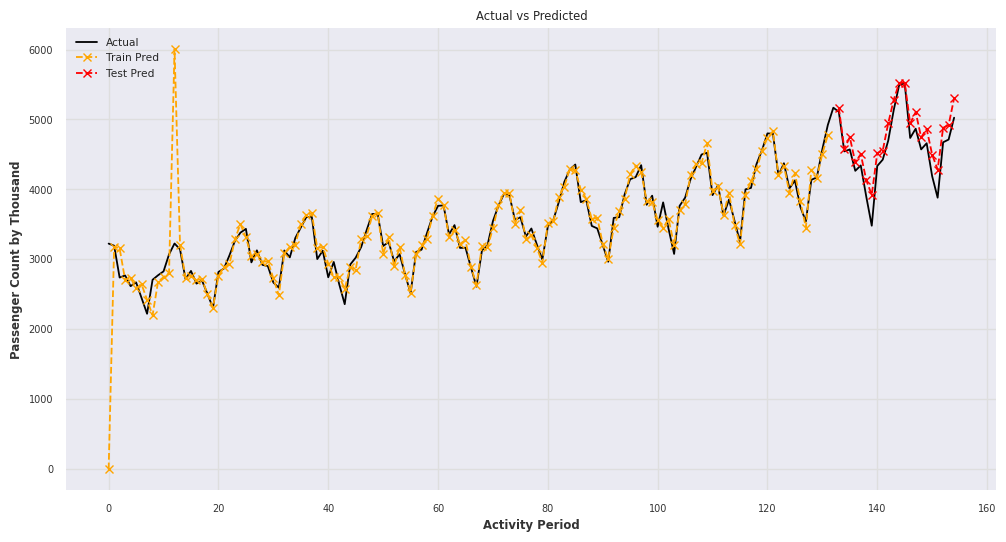

In [ ]:
plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sarimax_season, test_sairmax_df, y_test_pred_sarimax_season)

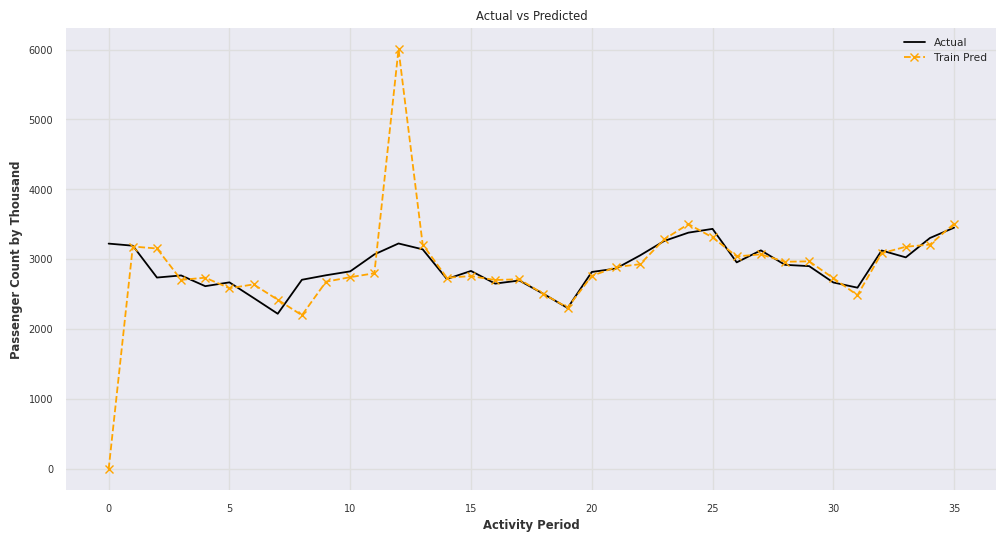

In [ ]:
plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sarimax_season, test_sairmax_df, y_test_pred_sarimax_season, start=0, end=36)

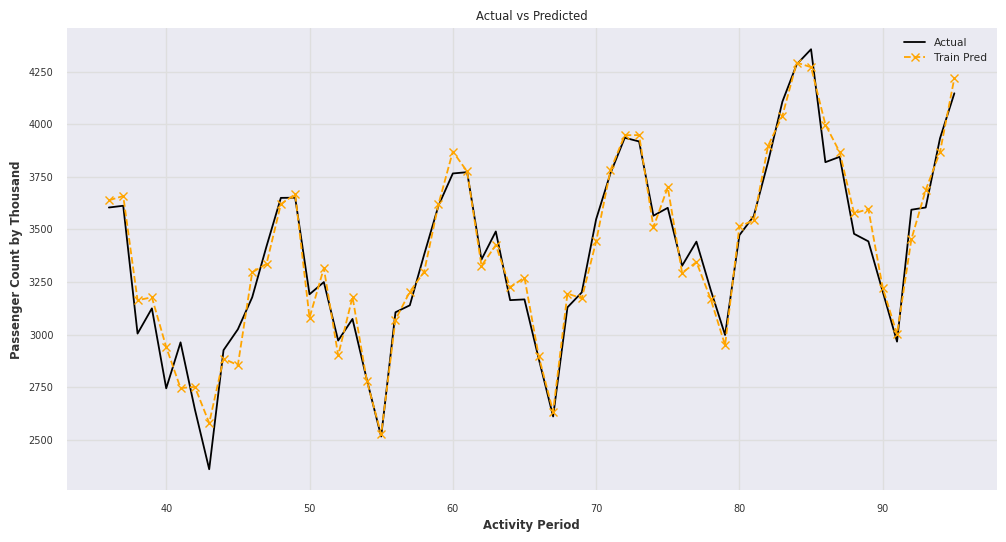

In [ ]:
plot_actual_vs_predicted_sarimax_range(train_sairmax_df, y_train_pred_sarimax_season, test_sairmax_df, y_test_pred_sarimax_season, start=36, end=96)

### Determine Best Performing SARIMAX Model

In [ ]:
# Function to Determine Best Perfomring SARIMAX Model
def determine_best_sarimax_model(sarimax_test_mse, sarimax_season_test_mse, sarimax_test_r2, sarimax_season_test_r2):
  best_mse = float('inf')
  best_r2 = float('-inf')

  if sarimax_test_mse < best_mse:
    best_mse = sarimax_test_mse
    best_mse_model = "Original SARIMAX"
  else:
    best_mse = sarimax_season_test_mse
    best_mse_model = "SARIMAX with Season"

  if sarimax_test_r2 > best_r2:
    best_r2 = sarimax_test_r2
    best_r2_model = "Original SARIMAX"
  else:
    best_r2 = sarimax_season_test_r2
    best_r2_model = "SARIMAX with Season"

  print(f"Best MSE: {best_mse}")
  print(f"Best R2: {best_r2}")
  print(f"Best MSE Model: {best_mse_model}")
  print(f"Best R2 Model: {best_r2_model}")

In [ ]:
determine_best_sarimax_model(mse_sairmax, mse_sarimax_season, r2_sairmax, r2_sarimax_season)

Best MSE: 47632509654.153404
Best R2: 0.8131004049495719
Best MSE Model: Original SARIMAX
Best R2 Model: Original SARIMAX


### Performance Across Transformer, LSTM, Linear Regression, Prophet and SAIRMAX

In [ ]:
# Function to Compare the Best Transformer, LSTM, Linear Regression, Prophet and SARIMAX Model
def compare_models(metrics):
  best_model = ""
  best_mse = float('inf')
  best_r2 = float('-inf')
  for model in metrics:
    train_mse, train_r2, val_mse, val_r2, test_mse, test_r2 = metrics[model]['train_mse'], metrics[model]['train_r2'], metrics[model]['val_mse'], metrics[model]['val_r2'], metrics[model]['test_mse'], metrics[model]['test_r2']
    if test_mse < best_mse and test_r2 > best_r2:
      best_model = model
      best_mse = test_mse
      best_r2 = test_r2

  print(f"Best Model: {best_model}")
  print(f"Best Test MSE: {best_mse}")
  print(f"Best Test R2: {best_r2}")


In [ ]:
# Create a Table of Best Peforming Models and Their Metrics
def compare_models_table(metrics):
  table = PrettyTable()
  table.field_names = ["Model", "Train MSE", "Train R2", "Val MSE", "Val R2", "Test MSE", "Test R2"]
  for model in metrics:
    train_mse, train_r2, val_mse, val_r2, test_mse, test_r2 = metrics[model]['train_mse'], metrics[model]['train_r2'], metrics[model]['val_mse'], metrics[model]['val_r2'], metrics[model]['test_mse'], metrics[model]['test_r2']
    table.add_row([model, train_mse, train_r2, val_mse, val_r2, test_mse, test_r2])
  print(table)

In [ ]:
# Function to Return a Dictionary of Train MSE and R2, Val MSE and R2, Test MSE and R2
def create_metric_dict(train_mse, train_r2, val_mse, val_r2, test_mse, test_r2):
  return {"train_mse": train_mse, "train_r2": train_r2, "val_mse": val_mse, "val_r2": val_r2, "test_mse": test_mse, "test_r2": test_r2}

In [ ]:
# Create Metrics Dict of Best Peforming
metrics = dict()
metrics['Linear Regression with Seasons'] = dict()
metrics['Transformer No Dropout'] = dict()
metrics['LSTM No Dropout'] = dict()
metrics['Prophet'] = dict()
metrics['SARIMAX No Extraneous Features'] = dict()

metrics['Linear Regression with Seasons'] = create_metric_dict(train_mse_lr_season, train_r2_lr_season, val_mse_lr_season, val_r2_lr_season, test_mse_lr_season, test_r2_lr_season)
metrics['Transformer No Dropout'] = create_metric_dict(y_train_nd_transformer_mse, y_train_nd_transformer_r2, y_val_nd_transformer_mse, y_val_nd_transformer_r2, y_test_nd_transformer_mse, y_test_nd_transformer_r2)
metrics['LSTM No Dropout'] = create_metric_dict(train_mse_lstm_no_drop, train_r2_lstm_no_drop, val_mse_lstm_no_drop, val_r2_lstm_no_drop, test_mse_lstm_no_drop, test_r2_lstm_no_drop)
metrics['Prophet'] = create_metric_dict(y_train_mse_prophet, y_train_r2_prophet, None, None, y_test_mse_prophet, y_test_r2_prophet)
metrics['SARIMAX No Extraneous Features'] = create_metric_dict(y_train_sarimax_mse, y_train_sarimax_r2, None, None, mse_sairmax, r2_sairmax)

compare_models_table(metrics)

+--------------------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
|             Model              |     Train MSE      |       Train R2      |      Val MSE       |        Val R2        |      Test MSE      |      Test R2       |
+--------------------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+
| Linear Regression with Seasons | 4494523002.920854  |  0.9781967208015596 | 14528335118.989502 |  0.9170542695637647  | 26787243321.336082 | 0.9055460322929227 |
|     Transformer No Dropout     | 811914720582.4504  | -2.0880818041308746 |  242026394195.458  | -0.05805090119883172 |  583151843623.658  | -1.288160925793866 |
|        LSTM No Dropout         | 100726272506.15775 |  0.6168920614623117 | 101708336301.68755 |  0.5553683549112176  | 152617401295.39673 | 0.4011625524906367 |
|            Pro

In [ ]:
compare_models(metrics)

Best Model: Linear Regression with Seasons
Best Test MSE: 26787243321.336082
Best Test R2: 0.9055460322929227
